In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import xarray as xr
import netCDF4 as nc
from matplotlib import ticker, cm
from matplotlib import animation, rc
import matplotlib.tri as tri
import sys
#import metpy.calc as mpcalc
#from metpy.cbook import get_test_data
#from metpy.interpolate import cross_section
import scipy.ndimage as ndimage
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.setrecursionlimit(9000)
import scipy.ndimage
import statistics
import scipy.io
import h5py
from scipy.interpolate import griddata

In [2]:
# Change this part
sYear  = 2008
sMonth = 10
sDay   = 1
sHour  = 0
eYear  = 2008
eMonth = 10
eDay   = 7
eHour  = 0
# Set the location of the column
Center_lon = 5  # 417
Center_lat = -11.0 
Center_lon0 = 5
Center_lat0 = -11.0 

#Center_lon = 102  # 1194
#Center_lat = -30.0 
#Center_lon0 = 102
#Center_lat0 = -30.0  

#Center_lon = 272 #3426
#Center_lat = -14.0 
#Center_lon0 = 272
#Center_lat0 = -14.0  

In [3]:
UPsedi15_PATH = '/media/liran/PLR5/UPsedi/fixed15/'
UPhysedi15 = xr.open_mfdataset(UPsedi15_PATH+'HPhypersedi_sigmag_long_fixed15_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPsedi20_PATH = '/media/liran/PLR5/UPsedi/fixed20/'
UPhysedi20 = xr.open_mfdataset(UPsedi20_PATH+'HPhypersedi_sigmag_long_fixed20_L125_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_120z200m.5s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.*.nc')
UPhy_PATH = '/media/liran/Elements/Frontera_Cases/Peter_smooth_momentum/Ensemble/2008/'
UPhy2008 = xr.open_mfdataset(UPhy_PATH+'Multi-CRM_UPCTRL_hpv_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_x_125z200m.2s_crm_nx_rad_16_np_768_nlev_125.frontera.cam.h0.2008-10-*.nc')
UP_Case = 'Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
UP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_UP/Multi-CRM_UPCTRL_v3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_64_64x_125z200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
UP2008 = xr.open_mfdataset(UP_PATH+UP_Case+'.cam.h0.2008-10-*.nc')
SP_Case = 'Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera'
SP_PATH = '/media/liran/Elements/Frontera_Cases/ERA5_Ensemble_SP/Multi-CRM_SPCTRLv3_ERA5_2008_F-MMF1_frontera_ne16pg2_r05_oQU240_CRM1_32_32x_125z1200m.5s_crm_nx_rad_16_np_2048_nlev_125.frontera/'
SP2008 = xr.open_mfdataset(SP_PATH+SP_Case+'.cam.h0.2008-10-*.nc')

In [4]:
lon = SP2008.lon.isel(time=0).values
lat = SP2008.lat.isel(time=0).values
Z3 = SP2008.Z3.isel(time=0).values

In [5]:
# Function calculate the distance between two points
def distance2(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [6]:
def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

In [7]:
# Function calculate the distance between two points
def distancef(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a))

In [8]:
# Function calculate the distance between two points
def lonlat_in(lat, lon, lat1, lon1, lat2, lon2):
    flag = 0
    if lon >lon1:
        if lon <lon2:
            if lat >lat1:
                if lat <lat2:
                    flag = 1
    return flag

In [9]:
# Function calculate the distance between two points
def potential_temperature(Temperature_K,Pressure_Pa):
    kapa = 0.286
    P0 = 100000
    return Temperature_K*(P0/Pressure_Pa)**kapa

In [10]:
# UP ==============================================================
T_UP = UP2008.T.values # T vertical diffusion K/s
SPWWUP = UP2008.SPWW.values
CLOUD_UP  = UP2008.CLOUD.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
Q_UP  = UP2008.Q.values
TMQ_UP  = UP2008.TMQ.values
QRS_UP  = UP2008.QRS.values
QRL_UP  = UP2008.QRL.values
PTTEND_UP  = UP2008.PTTEND.values
Z3UP  = UP2008.Z3.values
# SP ==============================================================
T_SP = SP2008.T.values # T vertical diffusion K/s
SPWWSP = SP2008.SPWW.values
CLOUD_SP  = SP2008.CLOUD.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
Q_SP  = SP2008.Q.values
TMQ_SP  = SP2008.TMQ.values
QRS_SP  = SP2008.QRS.values
QRL_SP  = SP2008.QRL.values
PTTEND_SP  = SP2008.PTTEND.values
Z3SP  = SP2008.Z3.values
# UPhy ============================================================
T_UPhy = UPhy2008.T.values # T vertical diffusion K/s
SPWWUPhy = UPhy2008.SPWW.values
CLOUD_UPhy  = UPhy2008.CLOUD.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
Q_UPhy  = UPhy2008.Q.values
TMQ_UPhy  = UPhy2008.TMQ.values
QRS_UPhy  = UPhy2008.QRS.values
QRL_UPhy  = UPhy2008.QRL.values
PTTEND_UPhy  = UPhy2008.PTTEND.values
Z3UPhy  = UPhy2008.Z3.values
# UPhysedi15 ======================================================
T_UPhysedi15 = UPhysedi15.T.values # T vertical diffusion K/s
SPWWUPhysedi15 = UPhysedi15.SPWW.values
CLOUD_UPhysedi15  = UPhysedi15.CLOUD.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
Q_UPhysedi15  = UPhysedi15.Q.values
TMQ_UPhysedi15  = UPhysedi15.TMQ.values
QRS_UPhysedi15  = UPhysedi15.QRS.values
QRL_UPhysedi15  = UPhysedi15.QRL.values
PTTEND_UPhysedi15  = UPhysedi15.PTTEND.values
Z3UPhysedi15  = UPhysedi15.Z3.values
# UPhysedi20 ======================================================
T_UPhysedi20 = UPhysedi20.T.values # T vertical diffusion K/s
SPWWUPhysedi20 = UPhysedi20.SPWW.values
CLOUD_UPhysedi20  = UPhysedi20.CLOUD.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
Q_UPhysedi20  = UPhysedi20.Q.values
TMQ_UPhysedi20  = UPhysedi20.TMQ.values
QRS_UPhysedi20  = UPhysedi20.QRS.values
QRL_UPhysedi20  = UPhysedi20.QRL.values
PTTEND_UPhysedi20  = UPhysedi20.PTTEND.values
Z3UPhysedi20  = UPhysedi20.Z3.values
#  ======================================================
OCNFRAC = UPhysedi20.OCNFRAC.isel(time=0).values
#  ======================================================
hyam_SP  = SP2008.hyam.values
hyam_UP  = UP2008.hyam.values
hyam_UPhy  = UPhy2008.hyam.values
hyam_UPhysedi15  = UPhysedi15.hyam.values
hyam_UPhysedi20  = UPhysedi20.hyam.values
hybm_SP  = SP2008.hybm.values
hybm_UP  = UP2008.hybm.values
hybm_UPhy  = UPhy2008.hybm.values
hybm_UPhysedi15  = UPhysedi15.hybm.values
hybm_UPhysedi20  = UPhysedi20.hybm.values
P0_SP  = SP2008.P0.values
P0_UP  = UP2008.P0.values
P0_UPhy  = UPhy2008.P0.values
P0_UPhysedi15  = UPhysedi15.P0.values
P0_UPhysedi20  = UPhysedi20.P0.values
PS_SP  = SP2008.PS.values
PS_UP  = UP2008.PS.values
PS_UPhy  = UPhy2008.PS.values
PS_UPhysedi15  = UPhysedi15.PS.values
PS_UPhysedi20  = UPhysedi20.PS.values
CLDLIQ_SP  = SP2008.CLDLIQ.values
CLDLIQ_UP  = UP2008.CLDLIQ.values
CLDLIQ_UPhy  = UPhy2008.CLDLIQ.values
CLDLIQ_UPhysedi15  = UPhysedi15.CLDLIQ.values
CLDLIQ_UPhysedi20  = UPhysedi20.CLDLIQ.values
CLDICE_SP  = SP2008.CLDICE.values
CLDICE_UP  = UP2008.CLDICE.values
CLDICE_UPhy  = UPhy2008.CLDICE.values
CLDICE_UPhysedi15  = UPhysedi15.CLDICE.values
CLDICE_UPhysedi20  = UPhysedi20.CLDICE.values
level_SP  = SP2008.lev.values
level_UP  = UP2008.lev.values
level_UPhy  = UPhy2008.lev.values
level_UPhysedi15  = UPhysedi15.lev.values
level_UPhysedi20  = UPhysedi20.lev.values

In [11]:
CERES_PATH = '/media/liran/Elements/CERES/'
count = 0
ndays = 7
iy = 2008
CERES_FAME = 'CERES_SYN1deg-Day_Terra-Aqua-MODIS_Ed4.1_Subset_'+str(iy)+'1001-'+str(iy)+'1130.nc'
CERES_FILE = nc.Dataset(CERES_PATH+CERES_FAME, mode = 'r')
toa_sw_all_daily = CERES_FILE.variables['toa_sw_all_daily']
toa_lw_all_daily = CERES_FILE.variables['toa_lw_all_daily']
toa_solar_all_daily = CERES_FILE.variables['toa_solar_all_daily']
if count ==0: 
    fsntoa_obs      = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    toa_lw_obs      = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
else:
    work1           = toa_solar_all_daily[sDay-1:sDay-1+ndays,:,:]-toa_sw_all_daily[sDay-1:sDay-1+ndays,:,:]
    work2           = toa_lw_all_daily[sDay-1:sDay-1+ndays,:,:]
    fsntoa_obs      = fsntoa_obs+work1
    toa_lw_obs      = toa_lw_obs+work2
print(count)
fsntoa_obs = fsntoa_obs
toa_lw_obs = toa_lw_obs
fsntoa_obs_mean = np.mean(fsntoa_obs, axis=0)
toa_lw_obs_mean = np.mean(toa_lw_obs, axis=0)
# Read coordinates
lon_CERES  = CERES_FILE.variables['lon'] # 360
lat_CERES  = CERES_FILE.variables['lat'] # 180
time_CERES = CERES_FILE.variables['time']

0


/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  # This is added back by InteractiveShellApp.init_path()
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':
/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  if sys.path[0] == '':


In [12]:
# ERA5 data  ---------------------------------------------------------------------------------------------------
iy = 2008
ndays = 7
sDay = 1
eDay = 7
ERA5_Path = '/media/liran/PLR5/ERA5/'+str(iy)+'/'
ERA5_Ensemblelcc = np.zeros([7,24,721,1440])
ERA5_Ensemblelwp = np.zeros([7,24,721,1440])
for id in range(sDay,eDay+1,1):
    ERA5_files = xr.open_mfdataset(ERA5_Path+'ERA5_sfc_'+str(iy)+'10'+str(id).zfill(2)+'.nc')
    ERA5_hourly = ERA5_files.variables['lcc']
    ERA5_hourly2 = ERA5_files.variables['tclw']
    ERA5_Ensemblelcc[id-1,:,:,:] = ERA5_hourly
    ERA5_Ensemblelwp[id-1,:,:,:] = ERA5_hourly2

lon_ERA5  = ERA5_files.variables['longitude'] # 360
lat_ERA5  = ERA5_files.variables['latitude'] # 180Multi-CRM_Aqua_UPCTRL5_1month_frontera_ne16pg2_ne16pg2_CRM1_64_125z_200m.0.5s_crm_nx_rad_16_np_2048_nlev_125.frontera
xi = lon_ERA5[:]
yi = lat_ERA5[:]
XiERA5, YiERA5 = np.meshgrid(lon_ERA5, lat_ERA5)
XiERA5_1d = XiERA5.flatten()
YiERA5_1d = YiERA5.flatten()

ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [13]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_cc.nc')
ERA5_cchourly = ERA5_plfiles.variables['cc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_t.nc')
ERA5_thourly = ERA5_plfiles.variables['t']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_q.nc')
ERA5_qhourly = ERA5_plfiles.variables['q']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_ciwc.nc')
ERA5_ciwchourly = ERA5_plfiles.variables['ciwc']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_z.nc')
ERA5_zhourly = ERA5_plfiles.variables['z']
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/2008/ERA5_clwc.nc')
ERA5_clwchourly = ERA5_plfiles.variables['clwc']

In [14]:
ERA5_plfiles = xr.open_mfdataset('/media/liran/PLR5/ERA5/ERA5_sfc_landseamask.nc')
ERA5_lsm = np.array(ERA5_plfiles.isel(time=0).variables['lsm'])
ERA5_lsm_1d = ERA5_lsm.flatten()
ERA5_lsm.shape
ERA5_lsm_1d.shape

(1038240,)

In [21]:
ind_Teri_ERA5 = [-999] 
ind_Indian_ERA5 = [-999] 
ind_Warm_ERA5 = [-999] 
ind_Hawaii_ERA5 = [-999] 
for il in range(len(XiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],20,0,50,360) # Teri
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Teri_ERA5.append(il)
            
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,60,-10,100) # Indian
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Indian_ERA5.append(il)
    
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-10,140,10,160) # Warm
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Warm_ERA5.append(il)
            
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],10,180,30,220) # Hawaii
    if ERA5_lsm_1d[il]<0.05:
        if d0>0:
            ind_Hawaii_ERA5.append(il)
            
ind_Teri_ERA5 = ind_Teri_ERA5[1:]
ind_Indian_ERA5 = ind_Indian_ERA5[1:]
ind_Warm_ERA5 = ind_Warm_ERA5[1:]
ind_Hawaii_ERA5 = ind_Hawaii_ERA5[1:]

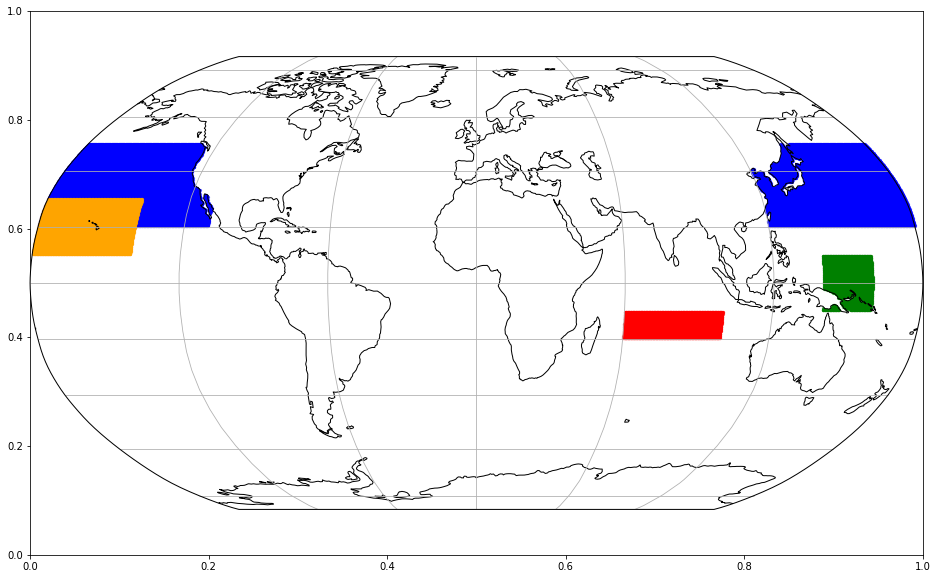

In [20]:
fig, ax = plt.subplots(figsize=(16,10))

#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()


for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],20,120,50,250) # Teri
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-20,60,-10,100) # Indian
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="red",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],-10,140,10,160) # Warm
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

for il in range(len(YiERA5_1d)):
    d0 = lonlat_in(YiERA5_1d[il], XiERA5_1d[il],10,180,30,220) # Hawaii
    if d0>0:
        if ERA5_lsm_1d[il]<0.05:
            plt.scatter(XiERA5_1d[il], YiERA5_1d[il],
                        color="orange",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
plt.savefig('Ocean_Land_Teri_ERA5.png')

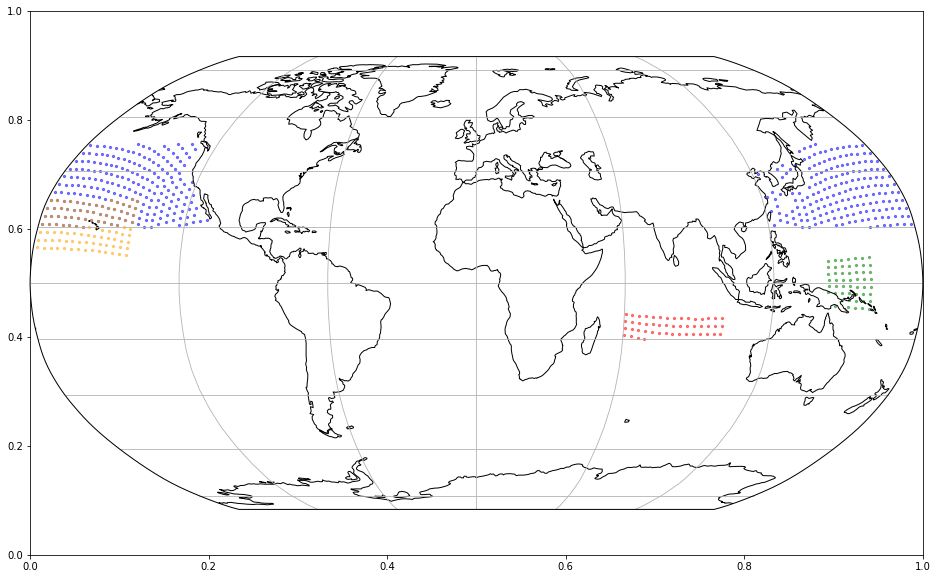

In [25]:
# Check the location of the selected column
#-- create figure and axes object
fig, ax = plt.subplots(figsize=(16,10))
ind_Teri = [-999] 
ind_Indian = [-999] 
ind_Warm = [-999] 
ind_Hawaii = [-999] 
#-- choose map projection
ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson())
ax.set_global()
#-- add coastlines, country border lines, and grid lines
ax.coastlines()
ax.gridlines()

ind_Namibian = [-999]        
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],20,120,50,250) # Teri
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Teri.append(il)
            plt.scatter(lon[il], lat[il],
                        color="blue",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important
    d0 = lonlat_in(lat[il], lon[il],-20,60,-10,100) # Indian
    if OCNFRAC[il]>0.95:
        if d0>0:
            ind_Indian.append(il)
            plt.scatter(lon[il], lat[il],
                        color="red",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Peruvian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],-10,140,10,160) # Warm
    if OCNFRAC[il]>0.5:
        if d0>0:
            ind_Warm.append(il)
            plt.scatter(lon[il], lat[il],
                        color="green",
                        s=5,
                        alpha=0.5,
                        transform=ccrs.PlateCarree()) ## Important

ind_Australian = [-999]
for il in range(len(lon)):
    d0 = lonlat_in(lat[il], lon[il],10,180,30,220) # Hawaii
    if d0>0:
        ind_Hawaii.append(il)
        plt.scatter(lon[il], lat[il],
                    color="orange",
                    s=5,
                    alpha=0.5,
                    transform=ccrs.PlateCarree()) ## Important
        
        

plt.savefig('Ocean_Land_Teri_Model.png')

In [26]:
ind_Teri = ind_Teri[1:]
ind_Indian = ind_Indian[1:]
ind_Warm = ind_Warm[1:]
ind_Hawaii = ind_Hawaii[1:]

# Teri

In [27]:
spww_SPTeri = np.zeros([1009,125])
spww_UPTeri = np.zeros([1009,125])
spww_UPhyTeri = np.zeros([1009,125])
spww_UPhysedi20Teri = np.zeros([1009,125])
spww_UPhysedi15Teri = np.zeros([1009,125])
Z3_SPTeri = np.zeros([1009,125])
Z3_UPTeri = np.zeros([1009,125])
Z3_UPhyTeri = np.zeros([1009,125])
Z3_UPhysedi20Teri = np.zeros([1009,125])
Z3_UPhysedi15Teri = np.zeros([1009,125])
pttend_SPTeri = np.zeros([1009,125])
pttend_UPTeri = np.zeros([1009,125])
pttend_UPhyTeri = np.zeros([1009,125])
pttend_UPhysedi20Teri = np.zeros([1009,125])
pttend_UPhysedi15Teri = np.zeros([1009,125])
cld_SPTeri = np.zeros([1009,125])
cld_UPTeri = np.zeros([1009,125])
cld_UPhyTeri = np.zeros([1009,125])
cld_UPhysedi20Teri = np.zeros([1009,125])
cld_UPhysedi15Teri = np.zeros([1009,125])
T_SPTeri = np.zeros([1009,125])
T_UPTeri = np.zeros([1009,125])
T_UPhyTeri = np.zeros([1009,125])
T_UPhysedi20Teri = np.zeros([1009,125])
T_UPhysedi15Teri = np.zeros([1009,125])
CLDLIQ_SPTeri = np.zeros([1009,125])
CLDLIQ_UPTeri = np.zeros([1009,125])
CLDLIQ_UPhyTeri = np.zeros([1009,125])
CLDLIQ_UPhysedi20Teri = np.zeros([1009,125])
CLDLIQ_UPhysedi15Teri = np.zeros([1009,125])
CLDICE_SPTeri = np.zeros([1009,125])
CLDICE_UPTeri = np.zeros([1009,125])
CLDICE_UPhyTeri = np.zeros([1009,125])
CLDICE_UPhysedi20Teri = np.zeros([1009,125])
CLDICE_UPhysedi15Teri = np.zeros([1009,125])
Q_SPTeri = np.zeros([1009,125])
Q_UPTeri = np.zeros([1009,125])
Q_UPhyTeri = np.zeros([1009,125])
Q_UPhysedi20Teri = np.zeros([1009,125])
Q_UPhysedi15Teri = np.zeros([1009,125])
P_SPTeri = np.zeros([1009,125])
P_UPTeri = np.zeros([1009,125])
P_UPhyTeri = np.zeros([1009,125])
P_UPhysedi20Teri = np.zeros([1009,125])
P_UPhysedi15Teri = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Teri)):
        spww_SPTeri[it,:] = spww_SPTeri[it,:] + SPWWSP[it,:,ind_Teri[il]]
        spww_UPTeri[it,:] = spww_UPTeri[it,:] + SPWWUP[it,:,ind_Teri[il]]
        spww_UPhyTeri[it,:] = spww_UPhyTeri[it,:] + SPWWUPhy[it,:,ind_Teri[il]]
        spww_UPhysedi15Teri[it,:] = spww_UPhysedi15Teri[it,:] + SPWWUPhysedi15[it,:,ind_Teri[il]]
        spww_UPhysedi20Teri[it,:] = spww_UPhysedi20Teri[it,:] + SPWWUPhysedi20[it,:,ind_Teri[il]]
        Z3_SPTeri[it,:] = Z3_SPTeri[it,:] + Z3SP[it,:,ind_Teri[il]]
        Z3_UPTeri[it,:] = Z3_UPTeri[it,:] + Z3UP[it,:,ind_Teri[il]]
        Z3_UPhyTeri[it,:] = Z3_UPhyTeri[it,:] + Z3UPhy[it,:,ind_Teri[il]]
        Z3_UPhysedi15Teri[it,:] = Z3_UPhysedi15Teri[it,:] + Z3UPhysedi15[it,:,ind_Teri[il]]
        Z3_UPhysedi20Teri[it,:] = Z3_UPhysedi20Teri[it,:] + Z3UPhysedi20[it,:,ind_Teri[il]]
        T_SPTeri[it,:] = T_SPTeri[it,:] + T_SP[it,:,ind_Teri[il]]
        T_UPTeri[it,:] = T_UPTeri[it,:] + T_UP[it,:,ind_Teri[il]]
        T_UPhyTeri[it,:] = T_UPhyTeri[it,:] + T_UPhy[it,:,ind_Teri[il]]
        T_UPhysedi15Teri[it,:] = T_UPhysedi15Teri[it,:] + T_UPhysedi15[it,:,ind_Teri[il]]
        T_UPhysedi20Teri[it,:] = T_UPhysedi20Teri[it,:] + T_UPhysedi20[it,:,ind_Teri[il]]
        CLDICE_SPTeri[it,:] = CLDICE_SPTeri[it,:] + CLDICE_SP[it,:,ind_Teri[il]]
        CLDICE_UPTeri[it,:] = CLDICE_UPTeri[it,:] + CLDICE_UP[it,:,ind_Teri[il]]
        CLDICE_UPhyTeri[it,:] = CLDICE_UPhyTeri[it,:] + CLDICE_UPhy[it,:,ind_Teri[il]]
        CLDICE_UPhysedi15Teri[it,:] = CLDICE_UPhysedi15Teri[it,:] + CLDICE_UPhysedi15[it,:,ind_Teri[il]]
        CLDICE_UPhysedi20Teri[it,:] = CLDICE_UPhysedi20Teri[it,:] + CLDICE_UPhysedi20[it,:,ind_Teri[il]]
        CLDLIQ_SPTeri[it,:] = CLDLIQ_SPTeri[it,:] + CLDLIQ_SP[it,:,ind_Teri[il]]
        CLDLIQ_UPTeri[it,:] = CLDLIQ_UPTeri[it,:] + CLDLIQ_UP[it,:,ind_Teri[il]]
        CLDLIQ_UPhyTeri[it,:] = CLDLIQ_UPhyTeri[it,:] + CLDLIQ_UPhy[it,:,ind_Teri[il]]
        CLDLIQ_UPhysedi15Teri[it,:] = CLDLIQ_UPhysedi15Teri[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Teri[il]]
        CLDLIQ_UPhysedi20Teri[it,:] = CLDLIQ_UPhysedi20Teri[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Teri[il]]
        Q_SPTeri[it,:] = Q_SPTeri[it,:] + Q_SP[it,:,ind_Teri[il]]
        Q_UPTeri[it,:] = Q_UPTeri[it,:] + Q_UP[it,:,ind_Teri[il]]
        Q_UPhyTeri[it,:] = Q_UPhyTeri[it,:] + Q_UPhy[it,:,ind_Teri[il]]
        Q_UPhysedi15Teri[it,:] = Q_UPhysedi15Teri[it,:] + Q_UPhysedi15[it,:,ind_Teri[il]]
        Q_UPhysedi20Teri[it,:] = Q_UPhysedi20Teri[it,:] + Q_UPhysedi20[it,:,ind_Teri[il]]
        pttend_SPTeri[it,:] = pttend_SPTeri[it,:] + PTTEND_SP[it,:,ind_Teri[il]]
        pttend_UPTeri[it,:] = pttend_UPTeri[it,:] + PTTEND_UP[it,:,ind_Teri[il]]
        pttend_UPhyTeri[it,:] = pttend_UPhyTeri[it,:] + PTTEND_UPhy[it,:,ind_Teri[il]]
        pttend_UPhysedi15Teri[it,:] = pttend_UPhysedi15Teri[it,:] + PTTEND_UPhysedi15[it,:,ind_Teri[il]]
        pttend_UPhysedi20Teri[it,:] = pttend_UPhysedi20Teri[it,:] + PTTEND_UPhysedi20[it,:,ind_Teri[il]]
        cld_SPTeri[it,:] = cld_SPTeri[it,:] + CLOUD_SP[it,:,ind_Teri[il]]
        cld_UPTeri[it,:] = cld_UPTeri[it,:] + CLOUD_UP[it,:,ind_Teri[il]]
        cld_UPhyTeri[it,:] = cld_UPhyTeri[it,:] + CLOUD_UPhy[it,:,ind_Teri[il]]
        cld_UPhysedi15Teri[it,:] = cld_UPhysedi15Teri[it,:] + CLOUD_UPhysedi15[it,:,ind_Teri[il]]
        cld_UPhysedi20Teri[it,:] = cld_UPhysedi20Teri[it,:] + CLOUD_UPhysedi20[it,:,ind_Teri[il]]
        P_SPTeri[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPTeri[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyTeri[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Teri[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Teri[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPTeri[it,:] = spww_SPTeri[it,:] /count
    spww_UPTeri[it,:] = spww_UPTeri[it,:]  /count
    spww_UPhyTeri[it,:] = spww_UPhyTeri[it,:] /count
    spww_UPhysedi15Teri[it,:] = spww_UPhysedi15Teri[it,:] /count
    spww_UPhysedi20Teri[it,:] = spww_UPhysedi20Teri[it,:] /count
    Z3_SPTeri[it,:] = Z3_SPTeri[it,:] /count
    Z3_UPTeri[it,:] = Z3_UPTeri[it,:]  /count
    Z3_UPhyTeri[it,:] = Z3_UPhyTeri[it,:] /count
    Z3_UPhysedi15Teri[it,:] = Z3_UPhysedi15Teri[it,:] /count
    Z3_UPhysedi20Teri[it,:] = Z3_UPhysedi20Teri[it,:] /count
    T_SPTeri[it,:] = T_SPTeri[it,:] /count
    T_UPTeri[it,:] = T_UPTeri[it,:]  /count
    T_UPhyTeri[it,:] = T_UPhyTeri[it,:] /count
    T_UPhysedi15Teri[it,:] = T_UPhysedi15Teri[it,:] /count
    T_UPhysedi20Teri[it,:] = T_UPhysedi20Teri[it,:] /count
    CLDICE_SPTeri[it,:] = CLDICE_SPTeri[it,:] /count
    CLDICE_UPTeri[it,:] = CLDICE_UPTeri[it,:]  /count
    CLDICE_UPhyTeri[it,:] = CLDICE_UPhyTeri[it,:] /count
    CLDICE_UPhysedi15Teri[it,:] = CLDICE_UPhysedi15Teri[it,:] /count
    CLDICE_UPhysedi20Teri[it,:] = CLDICE_UPhysedi20Teri[it,:] /count
    CLDLIQ_SPTeri[it,:] = CLDLIQ_SPTeri[it,:] /count
    CLDLIQ_UPTeri[it,:] = CLDLIQ_UPTeri[it,:]  /count
    CLDLIQ_UPhyTeri[it,:] = CLDLIQ_UPhyTeri[it,:] /count
    CLDLIQ_UPhysedi15Teri[it,:] = CLDLIQ_UPhysedi15Teri[it,:] /count
    CLDLIQ_UPhysedi20Teri[it,:] = CLDLIQ_UPhysedi20Teri[it,:] /count
    Q_SPTeri[it,:] = Q_SPTeri[it,:] /count
    Q_UPTeri[it,:] = Q_UPTeri[it,:]  /count
    Q_UPhyTeri[it,:] = Q_UPhyTeri[it,:] /count
    Q_UPhysedi15Teri[it,:] = Q_UPhysedi15Teri[it,:] /count
    Q_UPhysedi20Teri[it,:] = Q_UPhysedi20Teri[it,:] /count
    pttend_SPTeri[it,:] = pttend_SPTeri[it,:] /count
    pttend_UPTeri[it,:] = pttend_UPTeri[it,:]  /count
    pttend_UPhyTeri[it,:] = pttend_UPhyTeri[it,:] /count
    pttend_UPhysedi15Teri[it,:] = pttend_UPhysedi15Teri[it,:] /count
    pttend_UPhysedi20Teri[it,:] = pttend_UPhysedi20Teri[it,:] /count
    cld_SPTeri[it,:] = cld_SPTeri[it,:] /count
    cld_UPTeri[it,:] = cld_UPTeri[it,:]  /count
    cld_UPhyTeri[it,:] = cld_UPhyTeri[it,:] /count
    cld_UPhysedi15Teri[it,:] = cld_UPhysedi15Teri[it,:] /count
    cld_UPhysedi20Teri[it,:] = cld_UPhysedi20Teri[it,:] /count
    P_SPTeri[it,:] = P_SPTeri[it,:] /count
    P_UPTeri[it,:] = P_UPTeri[it,:]  /count
    P_UPhyTeri[it,:] = P_UPhyTeri[it,:] /count
    P_UPhysedi15Teri[it,:] = P_UPhysedi15Teri[it,:] /count
    P_UPhysedi20Teri[it,:] = P_UPhysedi20Teri[it,:] /count
    
spww_crossSPTeri = np.transpose(spww_SPTeri)
spww_crossUPTeri = np.transpose(spww_UPTeri)
spww_crossUPhyTeri = np.transpose(spww_UPhyTeri)
spww_crossUPhysedi15Teri = np.transpose(spww_UPhysedi15Teri)
spww_crossUPhysedi20Teri = np.transpose(spww_UPhysedi20Teri)
Z3_crossSPTeri = np.transpose(Z3_SPTeri)
Z3_crossUPTeri = np.transpose(Z3_UPTeri)
Z3_crossUPhyTeri = np.transpose(Z3_UPhyTeri)
Z3_crossUPhysedi15Teri = np.transpose(Z3_UPhysedi15Teri)
Z3_crossUPhysedi20Teri = np.transpose(Z3_UPhysedi20Teri)
T_crossSPTeri = np.transpose(T_SPTeri)
T_crossUPTeri = np.transpose(T_UPTeri)
T_crossUPhyTeri = np.transpose(T_UPhyTeri)
T_crossUPhysedi15Teri = np.transpose(T_UPhysedi15Teri)
T_crossUPhysedi20Teri = np.transpose(T_UPhysedi20Teri)
CLDICE_crossSPTeri = np.transpose(CLDICE_SPTeri)
CLDICE_crossUPTeri = np.transpose(CLDICE_UPTeri)
CLDICE_crossUPhyTeri = np.transpose(CLDICE_UPhyTeri)
CLDICE_crossUPhysedi15Teri = np.transpose(CLDICE_UPhysedi15Teri)
CLDICE_crossUPhysedi20Teri = np.transpose(CLDICE_UPhysedi20Teri)
CLDLIQ_crossSPTeri = np.transpose(CLDLIQ_SPTeri)
CLDLIQ_crossUPTeri = np.transpose(CLDLIQ_UPTeri)
CLDLIQ_crossUPhyTeri = np.transpose(CLDLIQ_UPhyTeri)
CLDLIQ_crossUPhysedi15Teri = np.transpose(CLDLIQ_UPhysedi15Teri)
CLDLIQ_crossUPhysedi20Teri = np.transpose(CLDLIQ_UPhysedi20Teri)
Q_crossSPTeri = np.transpose(Q_SPTeri)
Q_crossUPTeri = np.transpose(Q_UPTeri)
Q_crossUPhyTeri = np.transpose(Q_UPhyTeri)
Q_crossUPhysedi15Teri = np.transpose(Q_UPhysedi15Teri)
Q_crossUPhysedi20Teri = np.transpose(Q_UPhysedi20Teri)
pttend_crossSPTeri = np.transpose(pttend_SPTeri)
pttend_crossUPTeri = np.transpose(pttend_UPTeri)
pttend_crossUPhyTeri = np.transpose(pttend_UPhyTeri)
pttend_crossUPhysedi15Teri = np.transpose(pttend_UPhysedi15Teri)
pttend_crossUPhysedi20Teri = np.transpose(pttend_UPhysedi20Teri)
cld_crossSPTeri = np.transpose(cld_SPTeri)
cld_crossUPTeri = np.transpose(cld_UPTeri)
cld_crossUPhyTeri = np.transpose(cld_UPhyTeri)
cld_crossUPhysedi15Teri = np.transpose(cld_UPhysedi15Teri)
cld_crossUPhysedi20Teri = np.transpose(cld_UPhysedi20Teri)
P_crossSPTeri = np.transpose(P_SPTeri)
P_crossUPTeri = np.transpose(P_UPTeri)
P_crossUPhyTeri = np.transpose(P_UPhyTeri)
P_crossUPhysedi15Teri = np.transpose(P_UPhysedi15Teri)
P_crossUPhysedi20Teri = np.transpose(P_UPhysedi20Teri)

In [38]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tTeri = np.zeros([24*7,16])
ERA5_qTeri = np.zeros([24*7,16])
ERA5_zTeri = np.zeros([24*7,16])
ERA5_ccTeri = np.zeros([24*7,16])
ERA5_lwTeri = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Teri_ERA5)):
                ERA5_tTeri[countt,iz] = ERA5_tTeri[countt,iz] + temp1d[ind_Teri_ERA5[il]]
                ERA5_zTeri[countt,iz] = ERA5_zTeri[countt,iz] + temp1d2[ind_Teri_ERA5[il]]
                ERA5_ccTeri[countt,iz] = ERA5_ccTeri[countt,iz] + temp1d3[ind_Teri_ERA5[il]]
                ERA5_qTeri[countt,iz] = ERA5_qTeri[countt,iz] + temp1d4[ind_Teri_ERA5[il]]
                ERA5_lwTeri[countt,iz] = ERA5_lwTeri[countt,iz] + temp1d5[ind_Teri_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tTeri[countt,iz] = ERA5_tTeri[countt,iz]/(counttt3)
            ERA5_zTeri[countt,iz] = ERA5_zTeri[countt,iz]/(counttt3)
            ERA5_ccTeri[countt,iz] = ERA5_ccTeri[countt,iz]/(counttt3)
            ERA5_qTeri[countt,iz] = ERA5_qTeri[countt,iz]/(counttt3)
            ERA5_lwTeri[countt,iz] = ERA5_lwTeri[countt,iz]/(counttt3)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


0
24
1
24
2
24
3
24
4
24
5
24
6
24


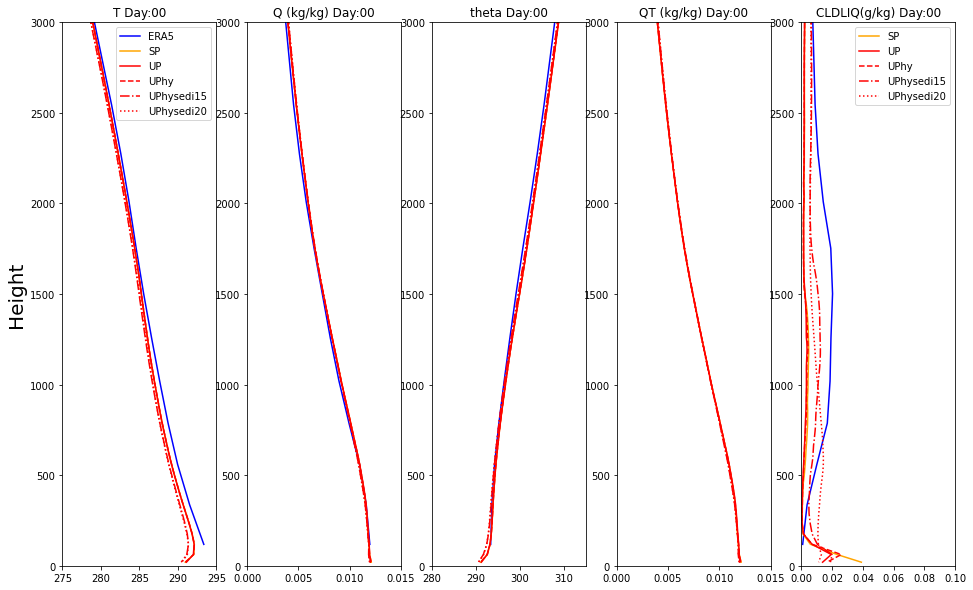

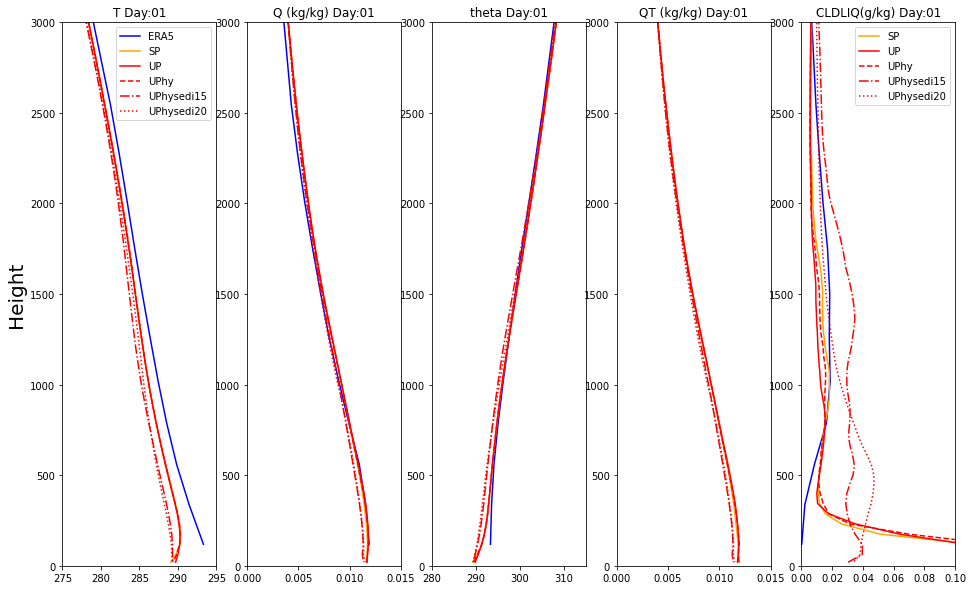

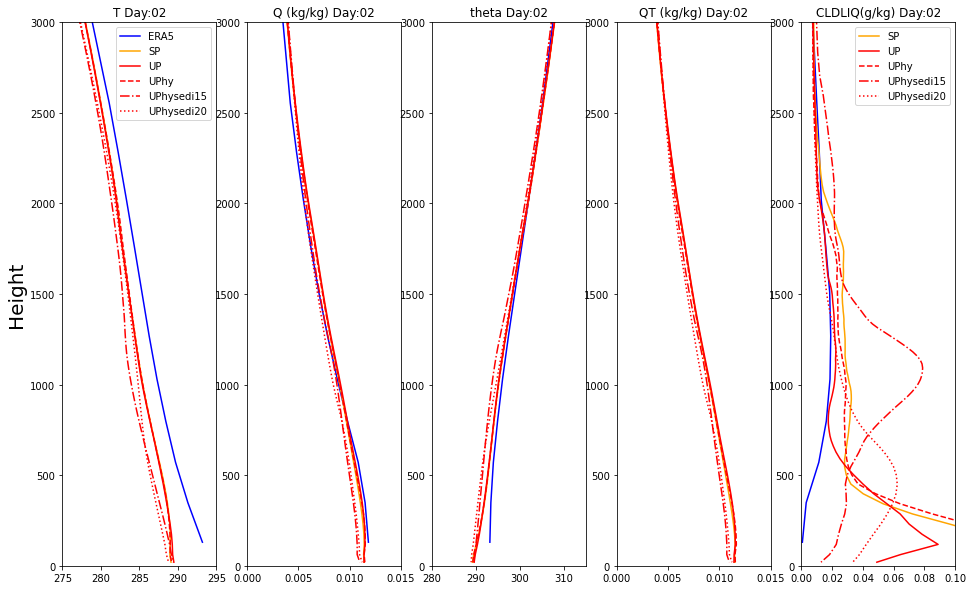

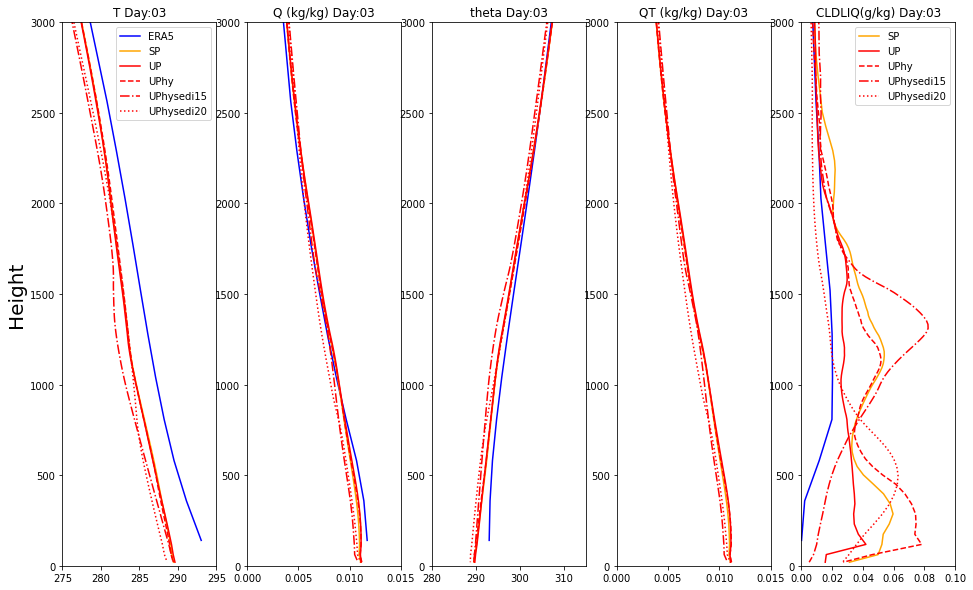

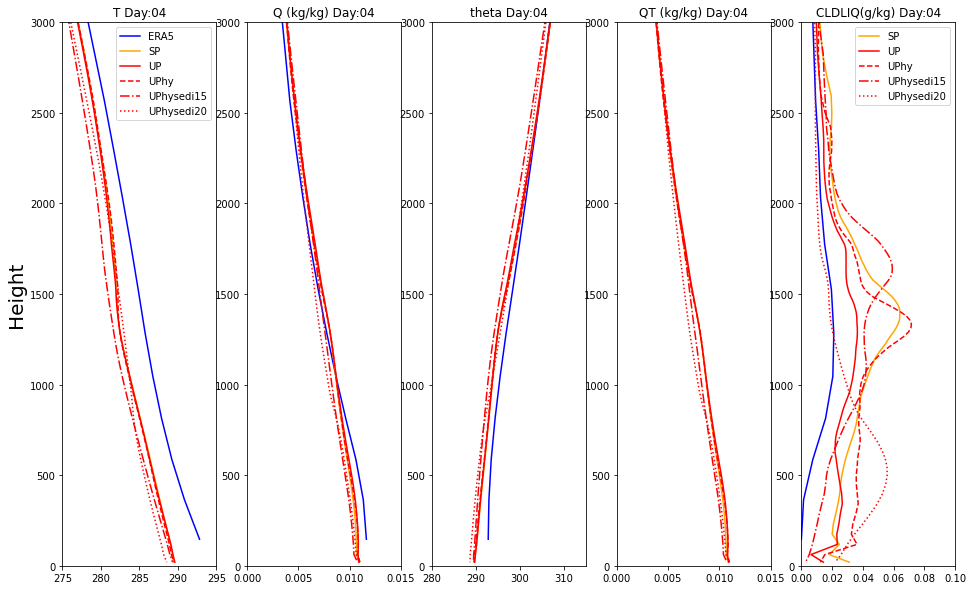

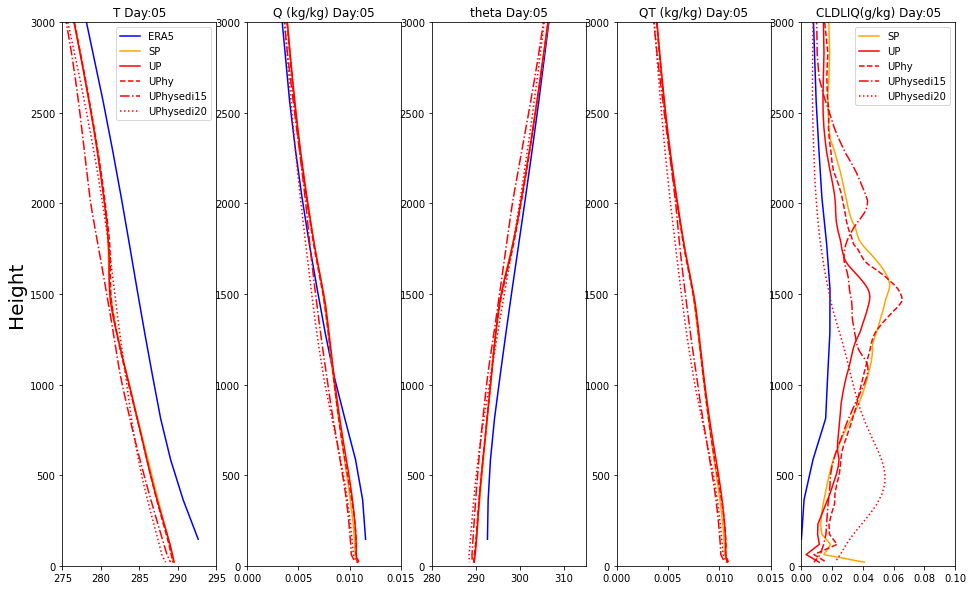

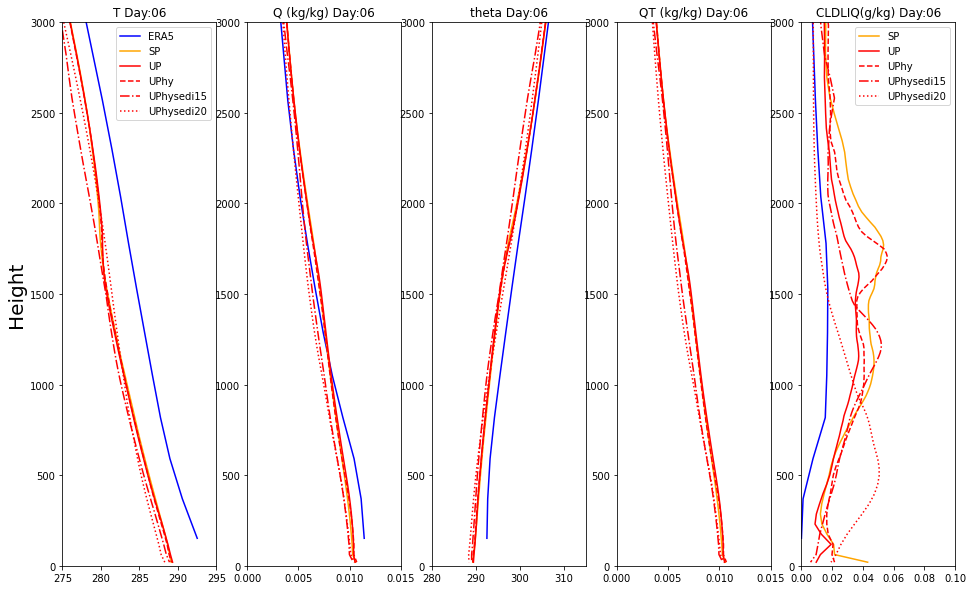

In [32]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Teri_dm = np.zeros([16])
    q_crossERA5Teri_dm = np.zeros([16])
    z_crossERA5Teri_dm = np.zeros([16])
    theta_crossERA5Teri_dm = np.zeros([16])
    lw_crossERA5Teri_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Teri_dm[:] = T_crossERA5Teri_dm[:] + ERA5_tTeri[(countday+24*iday),:]
        q_crossERA5Teri_dm[:] = q_crossERA5Teri_dm[:] + ERA5_qTeri[(countday+24*iday),:]
        z_crossERA5Teri_dm[:] = z_crossERA5Teri_dm[:] + ERA5_zTeri[(countday+24*iday),:]
        lw_crossERA5Teri_dm[:] = lw_crossERA5Teri_dm[:] + ERA5_lwTeri[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Teri_dm[izz] = potential_temperature(T_crossERA5Teri_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Teri_dm[:] = T_crossERA5Teri_dm[:]/(countday)
    q_crossERA5Teri_dm[:] = q_crossERA5Teri_dm[:]/(countday)
    z_crossERA5Teri_dm[:] = z_crossERA5Teri_dm[:]/(countday)
    theta_crossERA5Teri_dm[:] = theta_crossERA5Teri_dm[:]/(countday)
    lw_crossERA5Teri_dm[:] = lw_crossERA5Teri_dm[:]/(countday)
    T_crossSPTeri_dm = np.zeros([125])
    T_crossUPTeri_dm = np.zeros([125])
    T_crossUPhyTeri_dm = np.zeros([125])
    T_crossUPhysedi15Teri_dm = np.zeros([125])
    T_crossUPhysedi20Teri_dm = np.zeros([125])
    Q_crossSPTeri_dm = np.zeros([125])
    Q_crossUPTeri_dm = np.zeros([125])
    Q_crossUPhyTeri_dm = np.zeros([125])
    Q_crossUPhysedi15Teri_dm = np.zeros([125])
    Q_crossUPhysedi20Teri_dm = np.zeros([125])
    CLDICE_crossSPTeri_dm = np.zeros([125])
    CLDICE_crossUPTeri_dm = np.zeros([125])
    CLDICE_crossUPhyTeri_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Teri_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Teri_dm = np.zeros([125])
    CLDLIQ_crossSPTeri_dm = np.zeros([125])
    CLDLIQ_crossUPTeri_dm = np.zeros([125])
    CLDLIQ_crossUPhyTeri_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Teri_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Teri_dm = np.zeros([125])
    Z3_crossSPTeri_dm = np.zeros([125])
    Z3_crossUPTeri_dm = np.zeros([125])
    Z3_crossUPhyTeri_dm = np.zeros([125])
    Z3_crossUPhysedi15Teri_dm = np.zeros([125])
    Z3_crossUPhysedi20Teri_dm = np.zeros([125])
    theta_crossSPTeri_dm = np.zeros([125])
    theta_crossUPTeri_dm = np.zeros([125])
    theta_crossUPhyTeri_dm = np.zeros([125])
    theta_crossUPhysedi15Teri_dm = np.zeros([125])
    theta_crossUPhysedi20Teri_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPTeri_dm[:] = T_crossSPTeri_dm[:] + T_crossSPTeri[:,isec+144*iday]
        T_crossUPTeri_dm[:] = T_crossUPTeri_dm[:] + T_crossUPTeri[:,isec+144*iday]
        T_crossUPhyTeri_dm[:] = T_crossUPhyTeri_dm[:] + T_crossUPhyTeri[:,isec+144*iday]
        T_crossUPhysedi15Teri_dm[:] = T_crossUPhysedi15Teri_dm[:] + T_crossUPhysedi15Teri[:,isec+144*iday]
        T_crossUPhysedi20Teri_dm[:] = T_crossUPhysedi20Teri_dm[:] + T_crossUPhysedi20Teri[:,isec+144*iday]
        Q_crossSPTeri_dm[:] = Q_crossSPTeri_dm[:] + Q_crossSPTeri[:,isec+144*iday]
        Q_crossUPTeri_dm[:] = Q_crossUPTeri_dm[:] + Q_crossUPTeri[:,isec+144*iday]
        Q_crossUPhyTeri_dm[:] = Q_crossUPhyTeri_dm[:] + Q_crossUPhyTeri[:,isec+144*iday]
        Q_crossUPhysedi15Teri_dm[:] = Q_crossUPhysedi15Teri_dm[:] + Q_crossUPhysedi15Teri[:,isec+144*iday]
        Q_crossUPhysedi20Teri_dm[:] = Q_crossUPhysedi20Teri_dm[:] + Q_crossUPhysedi20Teri[:,isec+144*iday]
        CLDLIQ_crossSPTeri_dm[:] = CLDLIQ_crossSPTeri_dm[:] + CLDLIQ_crossSPTeri[:,isec+144*iday]
        CLDLIQ_crossUPTeri_dm[:] = CLDLIQ_crossUPTeri_dm[:] + CLDLIQ_crossUPTeri[:,isec+144*iday]
        CLDLIQ_crossUPhyTeri_dm[:] = CLDLIQ_crossUPhyTeri_dm[:] + CLDLIQ_crossUPhyTeri[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Teri_dm[:] = CLDLIQ_crossUPhysedi15Teri_dm[:] + CLDLIQ_crossUPhysedi15Teri[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Teri_dm[:] = CLDLIQ_crossUPhysedi20Teri_dm[:] + CLDLIQ_crossUPhysedi20Teri[:,isec+144*iday]
        CLDICE_crossSPTeri_dm[:] = CLDICE_crossSPTeri_dm[:] + CLDICE_crossSPTeri[:,isec+144*iday]
        CLDICE_crossUPTeri_dm[:] = CLDICE_crossUPTeri_dm[:] + CLDICE_crossUPTeri[:,isec+144*iday]
        CLDICE_crossUPhyTeri_dm[:] = CLDICE_crossUPhyTeri_dm[:] + CLDICE_crossUPhyTeri[:,isec+144*iday]
        CLDICE_crossUPhysedi15Teri_dm[:] = CLDICE_crossUPhysedi15Teri_dm[:] + CLDICE_crossUPhysedi15Teri[:,isec+144*iday]
        CLDICE_crossUPhysedi20Teri_dm[:] = CLDICE_crossUPhysedi20Teri_dm[:] + CLDICE_crossUPhysedi20Teri[:,isec+144*iday]
        Z3_crossSPTeri_dm[:] = Z3_crossSPTeri_dm[:] + Z3_crossSPTeri[:,isec+144*iday]
        Z3_crossUPTeri_dm[:] = Z3_crossUPTeri_dm[:] + Z3_crossUPTeri[:,isec+144*iday]
        Z3_crossUPhyTeri_dm[:] = Z3_crossUPhyTeri_dm[:] + Z3_crossUPhyTeri[:,isec+144*iday]
        Z3_crossUPhysedi15Teri_dm[:] = Z3_crossUPhysedi15Teri_dm[:] + Z3_crossUPhysedi15Teri[:,isec+144*iday]
        Z3_crossUPhysedi20Teri_dm[:] = Z3_crossUPhysedi20Teri_dm[:] + Z3_crossUPhysedi20Teri[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPTeri_dm[izz] = theta_crossSPTeri_dm[izz] + potential_temperature(T_crossSPTeri[izz,isec+144*iday],P_crossSPTeri[izz,isec+144*iday]*100)
            #theta_crossUPTeri_dm[izz] = theta_crossUPTeri_dm[izz] + potential_temperature(T_crossUPTeri[izz,isec+144*iday],P_crossUPTeri[izz,isec+144*iday]*100)
            #theta_crossUPhyTeri_dm[izz] = theta_crossUPhyTeri_dm[izz] + potential_temperature(T_crossUPhyTeri[izz,isec+144*iday],P_crossUPhyTeri[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Teri_dm[izz] = theta_crossUPhysedi15Teri_dm[izz] + potential_temperature(T_crossUPhysedi15Teri[izz,isec+144*iday],P_crossUPhysedi15Teri[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Teri_dm[izz] = theta_crossUPhysedi20Teri_dm[izz] + potential_temperature(T_crossUPhysedi20Teri[izz,isec+144*iday],P_crossUPhysedi20Teri[izz,isec+144*iday]*100)
            theta_crossSPTeri_dm[izz] = theta_crossSPTeri_dm[izz] + potential_temperature(T_crossSPTeri[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPTeri_dm[izz] = theta_crossUPTeri_dm[izz] + potential_temperature(T_crossUPTeri[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyTeri_dm[izz] = theta_crossUPhyTeri_dm[izz] + potential_temperature(T_crossUPhyTeri[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Teri_dm[izz] = theta_crossUPhysedi15Teri_dm[izz] + potential_temperature(T_crossUPhysedi15Teri[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Teri_dm[izz] = theta_crossUPhysedi20Teri_dm[izz] + potential_temperature(T_crossUPhysedi20Teri[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPTeri_dm = T_crossSPTeri_dm/(countsec)
    T_crossUPTeri_dm = T_crossUPTeri_dm/(countsec)
    T_crossUPhyTeri_dm = T_crossUPhyTeri_dm/(countsec)
    T_crossUPhysedi15Teri_dm = T_crossUPhysedi15Teri_dm/(countsec)
    T_crossUPhysedi20Teri_dm = T_crossUPhysedi20Teri_dm/(countsec)
    Q_crossSPTeri_dm = Q_crossSPTeri_dm/(countsec)
    Q_crossUPTeri_dm = Q_crossUPTeri_dm/(countsec)
    Q_crossUPhyTeri_dm = Q_crossUPhyTeri_dm/(countsec)
    Q_crossUPhysedi15Teri_dm = Q_crossUPhysedi15Teri_dm/(countsec)
    Q_crossUPhysedi20Teri_dm = Q_crossUPhysedi20Teri_dm/(countsec)  
    CLDICE_crossSPTeri_dm = CLDICE_crossSPTeri_dm/(countsec)
    CLDICE_crossUPTeri_dm = CLDICE_crossUPTeri_dm/(countsec)
    CLDICE_crossUPhyTeri_dm = CLDICE_crossUPhyTeri_dm/(countsec)
    CLDICE_crossUPhysedi15Teri_dm = CLDICE_crossUPhysedi15Teri_dm/(countsec)
    CLDICE_crossUPhysedi20Teri_dm = CLDICE_crossUPhysedi20Teri_dm/(countsec)  
    CLDLIQ_crossSPTeri_dm = CLDLIQ_crossSPTeri_dm/(countsec)
    CLDLIQ_crossUPTeri_dm = CLDLIQ_crossUPTeri_dm/(countsec)
    CLDLIQ_crossUPhyTeri_dm = CLDLIQ_crossUPhyTeri_dm/(countsec)
    CLDLIQ_crossUPhysedi15Teri_dm = CLDLIQ_crossUPhysedi15Teri_dm/(countsec)
    CLDLIQ_crossUPhysedi20Teri_dm = CLDLIQ_crossUPhysedi20Teri_dm/(countsec)  
    Z3_crossSPTeri_dm = Z3_crossSPTeri_dm/(countsec)
    Z3_crossUPTeri_dm = Z3_crossUPTeri_dm/(countsec)
    Z3_crossUPhyTeri_dm = Z3_crossUPhyTeri_dm/(countsec)
    Z3_crossUPhysedi15Teri_dm = Z3_crossUPhysedi15Teri_dm/(countsec)
    Z3_crossUPhysedi20Teri_dm = Z3_crossUPhysedi20Teri_dm/(countsec) 
    theta_crossSPTeri_dm = theta_crossSPTeri_dm/(countsec)
    theta_crossUPTeri_dm = theta_crossUPTeri_dm/(countsec)
    theta_crossUPhyTeri_dm = theta_crossUPhyTeri_dm/(countsec)
    theta_crossUPhysedi15Teri_dm = theta_crossUPhysedi15Teri_dm/(countsec)
    theta_crossUPhysedi20Teri_dm = theta_crossUPhysedi20Teri_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPTeri_dm = Q_crossSPTeri_dm+CLDICE_crossSPTeri_dm+CLDLIQ_crossSPTeri_dm
    QT_crossUPTeri_dm = Q_crossUPTeri_dm+CLDICE_crossUPTeri_dm+CLDLIQ_crossUPTeri_dm
    QT_crossUPhyTeri_dm = Q_crossUPhyTeri_dm+CLDICE_crossUPhyTeri_dm+CLDLIQ_crossUPhyTeri_dm
    QT_crossUPhysedi15Teri_dm = Q_crossUPhysedi15Teri_dm+CLDICE_crossUPhysedi15Teri_dm+CLDLIQ_crossUPhysedi15Teri_dm
    QT_crossUPhysedi20Teri_dm = Q_crossUPhysedi20Teri_dm+CLDICE_crossUPhysedi20Teri_dm+CLDLIQ_crossUPhysedi20Teri_dm
    cf42 = ax4.plot(QT_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Teri_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

/home/liran/.local/lib/python3.7/site-packages/ipykernel_launcher.py:69: UserWarning: No contour levels were found within the data range.


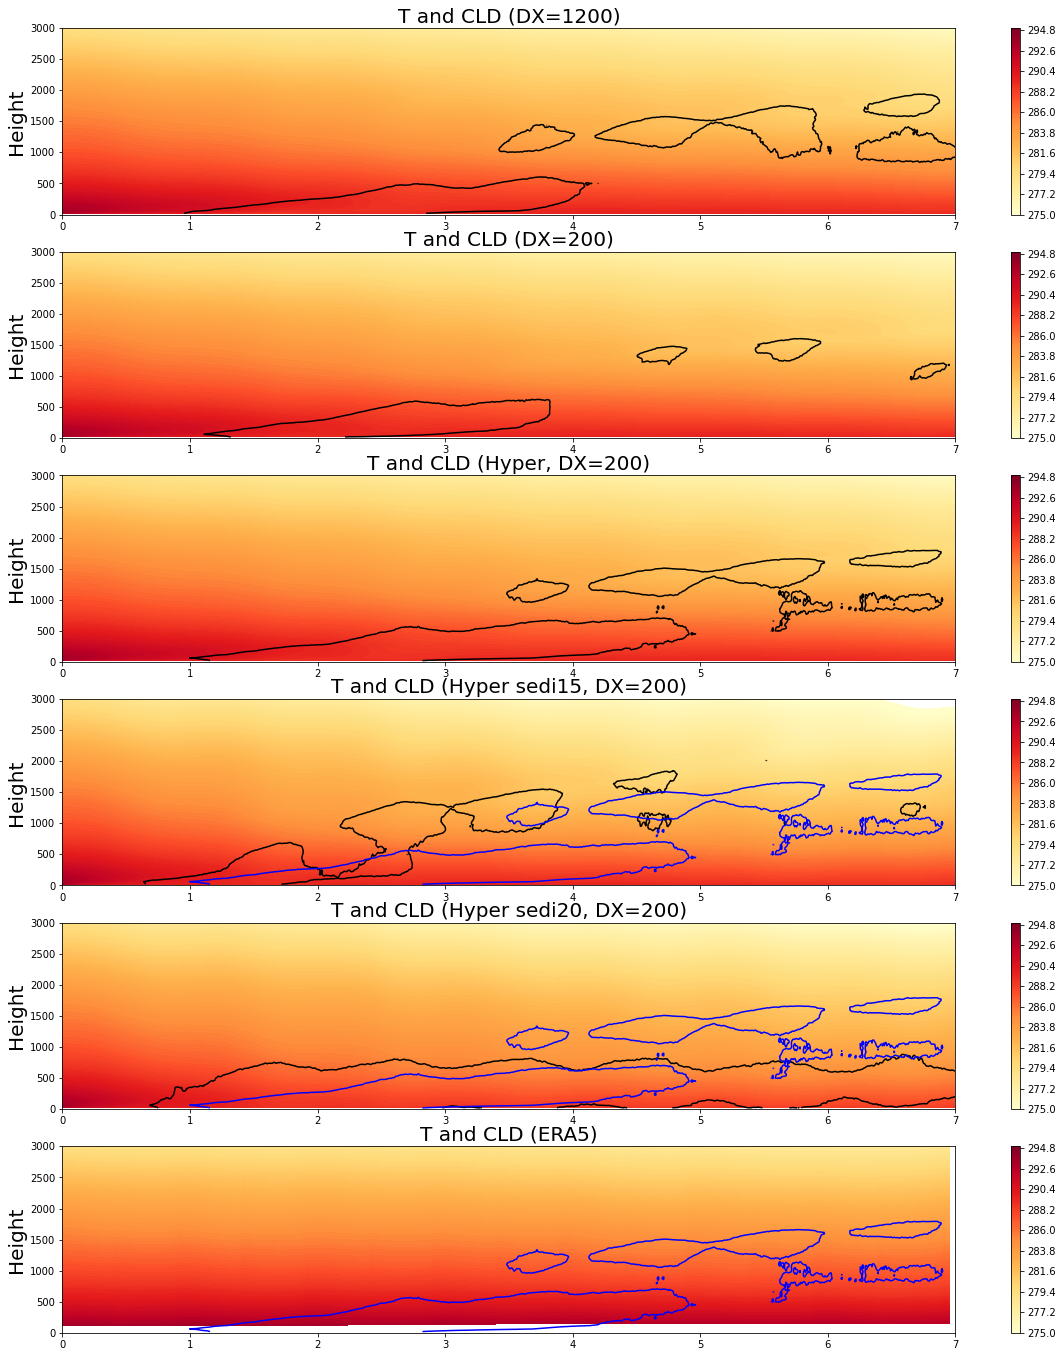

In [31]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPTeri,T_crossSPTeri,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPTeri,cld_crossSPTeri,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPTeri,T_crossUPTeri,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPTeri,cld_crossUPTeri,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyTeri,T_crossUPhyTeri,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Teri,T_crossUPhysedi15Teri,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Teri,cld_crossUPhysedi15Teri,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Teri,T_crossUPhysedi20Teri,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Teri,cld_crossUPhysedi20Teri,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zTeri/9.8,ERA5_tTeri,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zTeri/9.8,ERA5_ccTeri,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Teri_Time_Height_Model_ERA5.png')

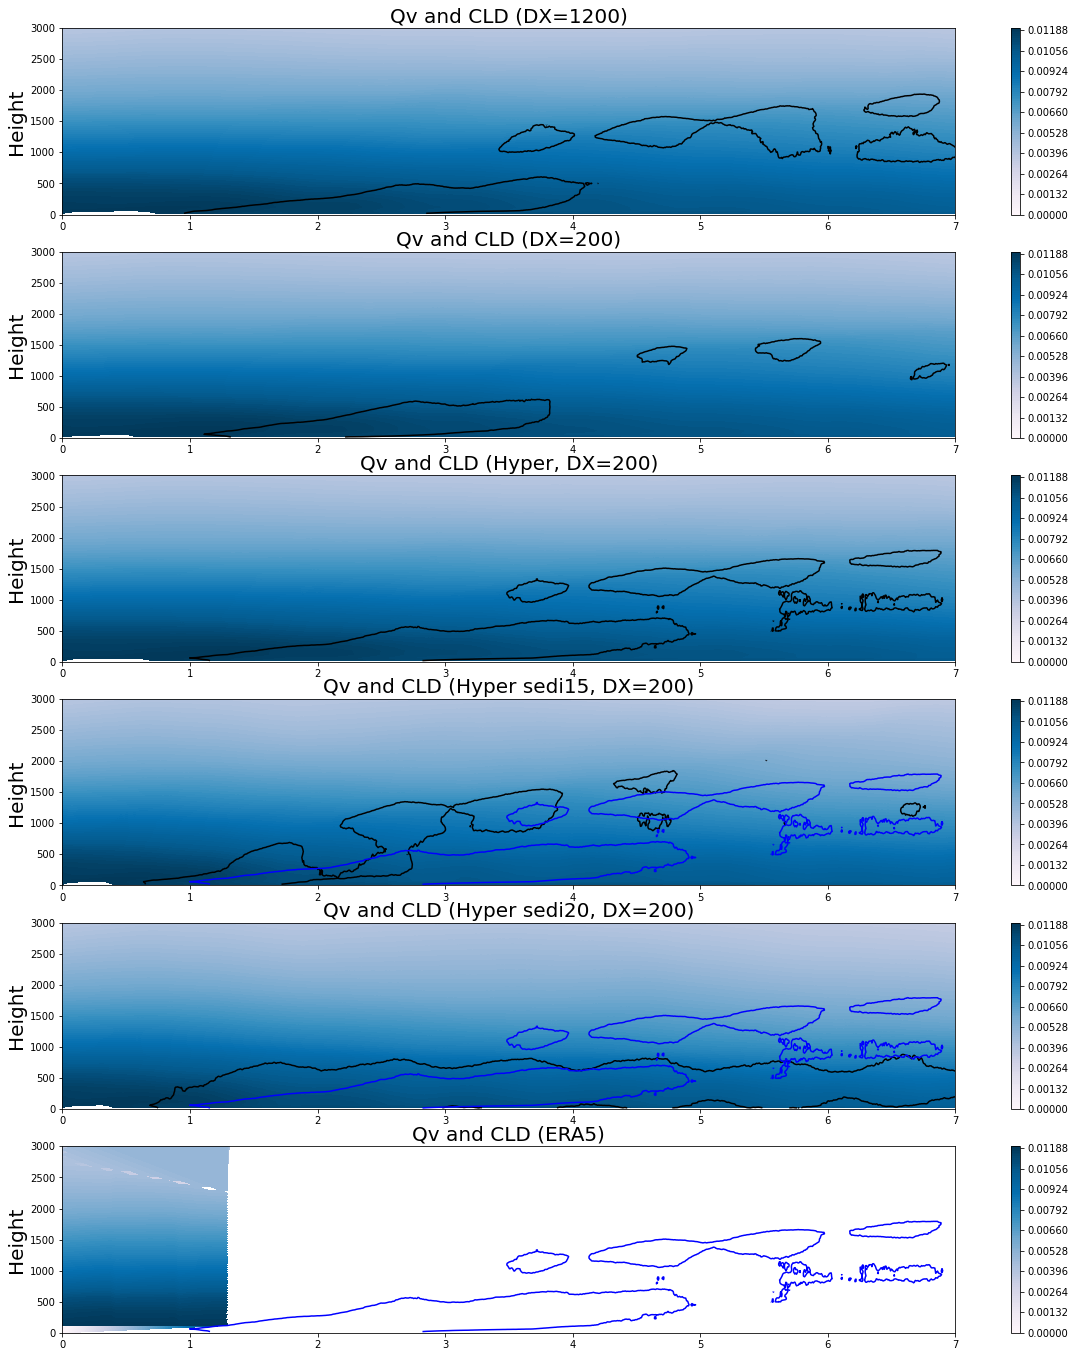

In [37]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.012]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPTeri,Q_crossSPTeri,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPTeri,cld_crossSPTeri,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPTeri,Q_crossUPTeri,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPTeri,cld_crossUPTeri,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyTeri,Q_crossUPhyTeri,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Teri,Q_crossUPhysedi15Teri,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Teri,cld_crossUPhysedi15Teri,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Teri,Q_crossUPhysedi20Teri,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Teri,cld_crossUPhysedi20Teri,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zTeri/9.8,ERA5_qTeri,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zTeri/9.8,ERA5_ccTeri,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyTeri,cld_crossUPhyTeri,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Teri_Time_HeighQv_Model_ERA5.png')

# Indian

In [39]:
spww_SPIndian = np.zeros([1009,125])
spww_UPIndian = np.zeros([1009,125])
spww_UPhyIndian = np.zeros([1009,125])
spww_UPhysedi20Indian = np.zeros([1009,125])
spww_UPhysedi15Indian = np.zeros([1009,125])
Z3_SPIndian = np.zeros([1009,125])
Z3_UPIndian = np.zeros([1009,125])
Z3_UPhyIndian = np.zeros([1009,125])
Z3_UPhysedi20Indian = np.zeros([1009,125])
Z3_UPhysedi15Indian = np.zeros([1009,125])
pttend_SPIndian = np.zeros([1009,125])
pttend_UPIndian = np.zeros([1009,125])
pttend_UPhyIndian = np.zeros([1009,125])
pttend_UPhysedi20Indian = np.zeros([1009,125])
pttend_UPhysedi15Indian = np.zeros([1009,125])
cld_SPIndian = np.zeros([1009,125])
cld_UPIndian = np.zeros([1009,125])
cld_UPhyIndian = np.zeros([1009,125])
cld_UPhysedi20Indian = np.zeros([1009,125])
cld_UPhysedi15Indian = np.zeros([1009,125])
T_SPIndian = np.zeros([1009,125])
T_UPIndian = np.zeros([1009,125])
T_UPhyIndian = np.zeros([1009,125])
T_UPhysedi20Indian = np.zeros([1009,125])
T_UPhysedi15Indian = np.zeros([1009,125])
CLDLIQ_SPIndian = np.zeros([1009,125])
CLDLIQ_UPIndian = np.zeros([1009,125])
CLDLIQ_UPhyIndian = np.zeros([1009,125])
CLDLIQ_UPhysedi20Indian = np.zeros([1009,125])
CLDLIQ_UPhysedi15Indian = np.zeros([1009,125])
CLDICE_SPIndian = np.zeros([1009,125])
CLDICE_UPIndian = np.zeros([1009,125])
CLDICE_UPhyIndian = np.zeros([1009,125])
CLDICE_UPhysedi20Indian = np.zeros([1009,125])
CLDICE_UPhysedi15Indian = np.zeros([1009,125])
Q_SPIndian = np.zeros([1009,125])
Q_UPIndian = np.zeros([1009,125])
Q_UPhyIndian = np.zeros([1009,125])
Q_UPhysedi20Indian = np.zeros([1009,125])
Q_UPhysedi15Indian = np.zeros([1009,125])
P_SPIndian = np.zeros([1009,125])
P_UPIndian = np.zeros([1009,125])
P_UPhyIndian = np.zeros([1009,125])
P_UPhysedi20Indian = np.zeros([1009,125])
P_UPhysedi15Indian = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Indian)):
        spww_SPIndian[it,:] = spww_SPIndian[it,:] + SPWWSP[it,:,ind_Indian[il]]
        spww_UPIndian[it,:] = spww_UPIndian[it,:] + SPWWUP[it,:,ind_Indian[il]]
        spww_UPhyIndian[it,:] = spww_UPhyIndian[it,:] + SPWWUPhy[it,:,ind_Indian[il]]
        spww_UPhysedi15Indian[it,:] = spww_UPhysedi15Indian[it,:] + SPWWUPhysedi15[it,:,ind_Indian[il]]
        spww_UPhysedi20Indian[it,:] = spww_UPhysedi20Indian[it,:] + SPWWUPhysedi20[it,:,ind_Indian[il]]
        Z3_SPIndian[it,:] = Z3_SPIndian[it,:] + Z3SP[it,:,ind_Indian[il]]
        Z3_UPIndian[it,:] = Z3_UPIndian[it,:] + Z3UP[it,:,ind_Indian[il]]
        Z3_UPhyIndian[it,:] = Z3_UPhyIndian[it,:] + Z3UPhy[it,:,ind_Indian[il]]
        Z3_UPhysedi15Indian[it,:] = Z3_UPhysedi15Indian[it,:] + Z3UPhysedi15[it,:,ind_Indian[il]]
        Z3_UPhysedi20Indian[it,:] = Z3_UPhysedi20Indian[it,:] + Z3UPhysedi20[it,:,ind_Indian[il]]
        T_SPIndian[it,:] = T_SPIndian[it,:] + T_SP[it,:,ind_Indian[il]]
        T_UPIndian[it,:] = T_UPIndian[it,:] + T_UP[it,:,ind_Indian[il]]
        T_UPhyIndian[it,:] = T_UPhyIndian[it,:] + T_UPhy[it,:,ind_Indian[il]]
        T_UPhysedi15Indian[it,:] = T_UPhysedi15Indian[it,:] + T_UPhysedi15[it,:,ind_Indian[il]]
        T_UPhysedi20Indian[it,:] = T_UPhysedi20Indian[it,:] + T_UPhysedi20[it,:,ind_Indian[il]]
        CLDICE_SPIndian[it,:] = CLDICE_SPIndian[it,:] + CLDICE_SP[it,:,ind_Indian[il]]
        CLDICE_UPIndian[it,:] = CLDICE_UPIndian[it,:] + CLDICE_UP[it,:,ind_Indian[il]]
        CLDICE_UPhyIndian[it,:] = CLDICE_UPhyIndian[it,:] + CLDICE_UPhy[it,:,ind_Indian[il]]
        CLDICE_UPhysedi15Indian[it,:] = CLDICE_UPhysedi15Indian[it,:] + CLDICE_UPhysedi15[it,:,ind_Indian[il]]
        CLDICE_UPhysedi20Indian[it,:] = CLDICE_UPhysedi20Indian[it,:] + CLDICE_UPhysedi20[it,:,ind_Indian[il]]
        CLDLIQ_SPIndian[it,:] = CLDLIQ_SPIndian[it,:] + CLDLIQ_SP[it,:,ind_Indian[il]]
        CLDLIQ_UPIndian[it,:] = CLDLIQ_UPIndian[it,:] + CLDLIQ_UP[it,:,ind_Indian[il]]
        CLDLIQ_UPhyIndian[it,:] = CLDLIQ_UPhyIndian[it,:] + CLDLIQ_UPhy[it,:,ind_Indian[il]]
        CLDLIQ_UPhysedi15Indian[it,:] = CLDLIQ_UPhysedi15Indian[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Indian[il]]
        CLDLIQ_UPhysedi20Indian[it,:] = CLDLIQ_UPhysedi20Indian[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Indian[il]]
        Q_SPIndian[it,:] = Q_SPIndian[it,:] + Q_SP[it,:,ind_Indian[il]]
        Q_UPIndian[it,:] = Q_UPIndian[it,:] + Q_UP[it,:,ind_Indian[il]]
        Q_UPhyIndian[it,:] = Q_UPhyIndian[it,:] + Q_UPhy[it,:,ind_Indian[il]]
        Q_UPhysedi15Indian[it,:] = Q_UPhysedi15Indian[it,:] + Q_UPhysedi15[it,:,ind_Indian[il]]
        Q_UPhysedi20Indian[it,:] = Q_UPhysedi20Indian[it,:] + Q_UPhysedi20[it,:,ind_Indian[il]]
        pttend_SPIndian[it,:] = pttend_SPIndian[it,:] + PTTEND_SP[it,:,ind_Indian[il]]
        pttend_UPIndian[it,:] = pttend_UPIndian[it,:] + PTTEND_UP[it,:,ind_Indian[il]]
        pttend_UPhyIndian[it,:] = pttend_UPhyIndian[it,:] + PTTEND_UPhy[it,:,ind_Indian[il]]
        pttend_UPhysedi15Indian[it,:] = pttend_UPhysedi15Indian[it,:] + PTTEND_UPhysedi15[it,:,ind_Indian[il]]
        pttend_UPhysedi20Indian[it,:] = pttend_UPhysedi20Indian[it,:] + PTTEND_UPhysedi20[it,:,ind_Indian[il]]
        cld_SPIndian[it,:] = cld_SPIndian[it,:] + CLOUD_SP[it,:,ind_Indian[il]]
        cld_UPIndian[it,:] = cld_UPIndian[it,:] + CLOUD_UP[it,:,ind_Indian[il]]
        cld_UPhyIndian[it,:] = cld_UPhyIndian[it,:] + CLOUD_UPhy[it,:,ind_Indian[il]]
        cld_UPhysedi15Indian[it,:] = cld_UPhysedi15Indian[it,:] + CLOUD_UPhysedi15[it,:,ind_Indian[il]]
        cld_UPhysedi20Indian[it,:] = cld_UPhysedi20Indian[it,:] + CLOUD_UPhysedi20[it,:,ind_Indian[il]]
        P_SPIndian[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPIndian[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyIndian[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Indian[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Indian[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPIndian[it,:] = spww_SPIndian[it,:] /count
    spww_UPIndian[it,:] = spww_UPIndian[it,:]  /count
    spww_UPhyIndian[it,:] = spww_UPhyIndian[it,:] /count
    spww_UPhysedi15Indian[it,:] = spww_UPhysedi15Indian[it,:] /count
    spww_UPhysedi20Indian[it,:] = spww_UPhysedi20Indian[it,:] /count
    Z3_SPIndian[it,:] = Z3_SPIndian[it,:] /count
    Z3_UPIndian[it,:] = Z3_UPIndian[it,:]  /count
    Z3_UPhyIndian[it,:] = Z3_UPhyIndian[it,:] /count
    Z3_UPhysedi15Indian[it,:] = Z3_UPhysedi15Indian[it,:] /count
    Z3_UPhysedi20Indian[it,:] = Z3_UPhysedi20Indian[it,:] /count
    T_SPIndian[it,:] = T_SPIndian[it,:] /count
    T_UPIndian[it,:] = T_UPIndian[it,:]  /count
    T_UPhyIndian[it,:] = T_UPhyIndian[it,:] /count
    T_UPhysedi15Indian[it,:] = T_UPhysedi15Indian[it,:] /count
    T_UPhysedi20Indian[it,:] = T_UPhysedi20Indian[it,:] /count
    CLDICE_SPIndian[it,:] = CLDICE_SPIndian[it,:] /count
    CLDICE_UPIndian[it,:] = CLDICE_UPIndian[it,:]  /count
    CLDICE_UPhyIndian[it,:] = CLDICE_UPhyIndian[it,:] /count
    CLDICE_UPhysedi15Indian[it,:] = CLDICE_UPhysedi15Indian[it,:] /count
    CLDICE_UPhysedi20Indian[it,:] = CLDICE_UPhysedi20Indian[it,:] /count
    CLDLIQ_SPIndian[it,:] = CLDLIQ_SPIndian[it,:] /count
    CLDLIQ_UPIndian[it,:] = CLDLIQ_UPIndian[it,:]  /count
    CLDLIQ_UPhyIndian[it,:] = CLDLIQ_UPhyIndian[it,:] /count
    CLDLIQ_UPhysedi15Indian[it,:] = CLDLIQ_UPhysedi15Indian[it,:] /count
    CLDLIQ_UPhysedi20Indian[it,:] = CLDLIQ_UPhysedi20Indian[it,:] /count
    Q_SPIndian[it,:] = Q_SPIndian[it,:] /count
    Q_UPIndian[it,:] = Q_UPIndian[it,:]  /count
    Q_UPhyIndian[it,:] = Q_UPhyIndian[it,:] /count
    Q_UPhysedi15Indian[it,:] = Q_UPhysedi15Indian[it,:] /count
    Q_UPhysedi20Indian[it,:] = Q_UPhysedi20Indian[it,:] /count
    pttend_SPIndian[it,:] = pttend_SPIndian[it,:] /count
    pttend_UPIndian[it,:] = pttend_UPIndian[it,:]  /count
    pttend_UPhyIndian[it,:] = pttend_UPhyIndian[it,:] /count
    pttend_UPhysedi15Indian[it,:] = pttend_UPhysedi15Indian[it,:] /count
    pttend_UPhysedi20Indian[it,:] = pttend_UPhysedi20Indian[it,:] /count
    cld_SPIndian[it,:] = cld_SPIndian[it,:] /count
    cld_UPIndian[it,:] = cld_UPIndian[it,:]  /count
    cld_UPhyIndian[it,:] = cld_UPhyIndian[it,:] /count
    cld_UPhysedi15Indian[it,:] = cld_UPhysedi15Indian[it,:] /count
    cld_UPhysedi20Indian[it,:] = cld_UPhysedi20Indian[it,:] /count
    P_SPIndian[it,:] = P_SPIndian[it,:] /count
    P_UPIndian[it,:] = P_UPIndian[it,:]  /count
    P_UPhyIndian[it,:] = P_UPhyIndian[it,:] /count
    P_UPhysedi15Indian[it,:] = P_UPhysedi15Indian[it,:] /count
    P_UPhysedi20Indian[it,:] = P_UPhysedi20Indian[it,:] /count
    
spww_crossSPIndian = np.transpose(spww_SPIndian)
spww_crossUPIndian = np.transpose(spww_UPIndian)
spww_crossUPhyIndian = np.transpose(spww_UPhyIndian)
spww_crossUPhysedi15Indian = np.transpose(spww_UPhysedi15Indian)
spww_crossUPhysedi20Indian = np.transpose(spww_UPhysedi20Indian)
Z3_crossSPIndian = np.transpose(Z3_SPIndian)
Z3_crossUPIndian = np.transpose(Z3_UPIndian)
Z3_crossUPhyIndian = np.transpose(Z3_UPhyIndian)
Z3_crossUPhysedi15Indian = np.transpose(Z3_UPhysedi15Indian)
Z3_crossUPhysedi20Indian = np.transpose(Z3_UPhysedi20Indian)
T_crossSPIndian = np.transpose(T_SPIndian)
T_crossUPIndian = np.transpose(T_UPIndian)
T_crossUPhyIndian = np.transpose(T_UPhyIndian)
T_crossUPhysedi15Indian = np.transpose(T_UPhysedi15Indian)
T_crossUPhysedi20Indian = np.transpose(T_UPhysedi20Indian)
CLDICE_crossSPIndian = np.transpose(CLDICE_SPIndian)
CLDICE_crossUPIndian = np.transpose(CLDICE_UPIndian)
CLDICE_crossUPhyIndian = np.transpose(CLDICE_UPhyIndian)
CLDICE_crossUPhysedi15Indian = np.transpose(CLDICE_UPhysedi15Indian)
CLDICE_crossUPhysedi20Indian = np.transpose(CLDICE_UPhysedi20Indian)
CLDLIQ_crossSPIndian = np.transpose(CLDLIQ_SPIndian)
CLDLIQ_crossUPIndian = np.transpose(CLDLIQ_UPIndian)
CLDLIQ_crossUPhyIndian = np.transpose(CLDLIQ_UPhyIndian)
CLDLIQ_crossUPhysedi15Indian = np.transpose(CLDLIQ_UPhysedi15Indian)
CLDLIQ_crossUPhysedi20Indian = np.transpose(CLDLIQ_UPhysedi20Indian)
Q_crossSPIndian = np.transpose(Q_SPIndian)
Q_crossUPIndian = np.transpose(Q_UPIndian)
Q_crossUPhyIndian = np.transpose(Q_UPhyIndian)
Q_crossUPhysedi15Indian = np.transpose(Q_UPhysedi15Indian)
Q_crossUPhysedi20Indian = np.transpose(Q_UPhysedi20Indian)
pttend_crossSPIndian = np.transpose(pttend_SPIndian)
pttend_crossUPIndian = np.transpose(pttend_UPIndian)
pttend_crossUPhyIndian = np.transpose(pttend_UPhyIndian)
pttend_crossUPhysedi15Indian = np.transpose(pttend_UPhysedi15Indian)
pttend_crossUPhysedi20Indian = np.transpose(pttend_UPhysedi20Indian)
cld_crossSPIndian = np.transpose(cld_SPIndian)
cld_crossUPIndian = np.transpose(cld_UPIndian)
cld_crossUPhyIndian = np.transpose(cld_UPhyIndian)
cld_crossUPhysedi15Indian = np.transpose(cld_UPhysedi15Indian)
cld_crossUPhysedi20Indian = np.transpose(cld_UPhysedi20Indian)
P_crossSPIndian = np.transpose(P_SPIndian)
P_crossUPIndian = np.transpose(P_UPIndian)
P_crossUPhyIndian = np.transpose(P_UPhyIndian)
P_crossUPhysedi15Indian = np.transpose(P_UPhysedi15Indian)
P_crossUPhysedi20Indian = np.transpose(P_UPhysedi20Indian)

In [40]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tIndian = np.zeros([24*7,16])
ERA5_qIndian = np.zeros([24*7,16])
ERA5_zIndian = np.zeros([24*7,16])
ERA5_ccIndian = np.zeros([24*7,16])
ERA5_lwIndian = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Indian_ERA5)):
                ERA5_tIndian[countt,iz] = ERA5_tIndian[countt,iz] + temp1d[ind_Indian_ERA5[il]]
                ERA5_zIndian[countt,iz] = ERA5_zIndian[countt,iz] + temp1d2[ind_Indian_ERA5[il]]
                ERA5_ccIndian[countt,iz] = ERA5_ccIndian[countt,iz] + temp1d3[ind_Indian_ERA5[il]]
                ERA5_qIndian[countt,iz] = ERA5_qIndian[countt,iz] + temp1d4[ind_Indian_ERA5[il]]
                ERA5_lwIndian[countt,iz] = ERA5_lwIndian[countt,iz] + temp1d5[ind_Indian_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tIndian[countt,iz] = ERA5_tIndian[countt,iz]/(counttt3)
            ERA5_zIndian[countt,iz] = ERA5_zIndian[countt,iz]/(counttt3)
            ERA5_ccIndian[countt,iz] = ERA5_ccIndian[countt,iz]/(counttt3)
            ERA5_qIndian[countt,iz] = ERA5_qIndian[countt,iz]/(counttt3)
            ERA5_lwIndian[countt,iz] = ERA5_lwIndian[countt,iz]/(counttt3)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


0
24
1
24
2
24
3
24
4
24
5
24
6
24


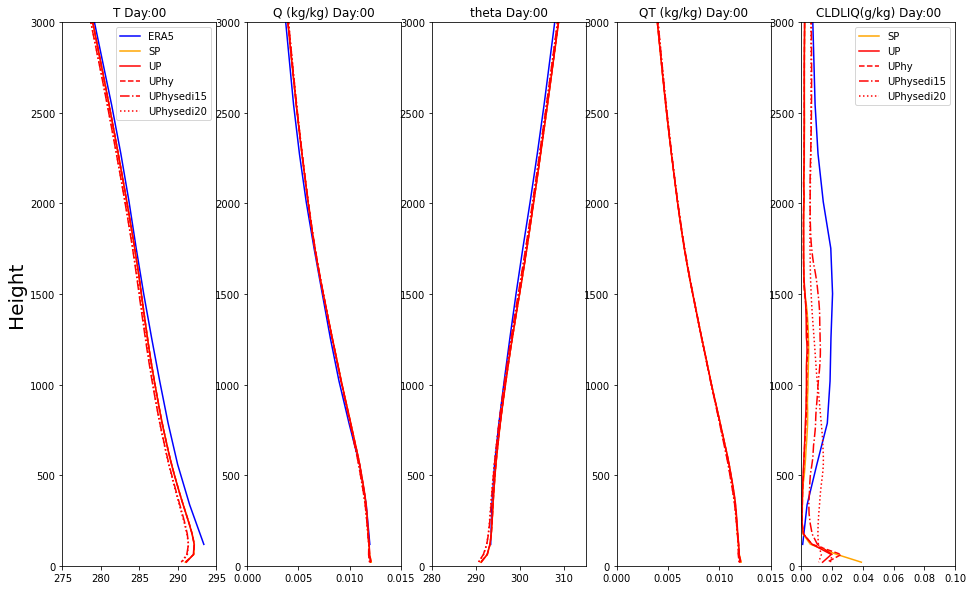

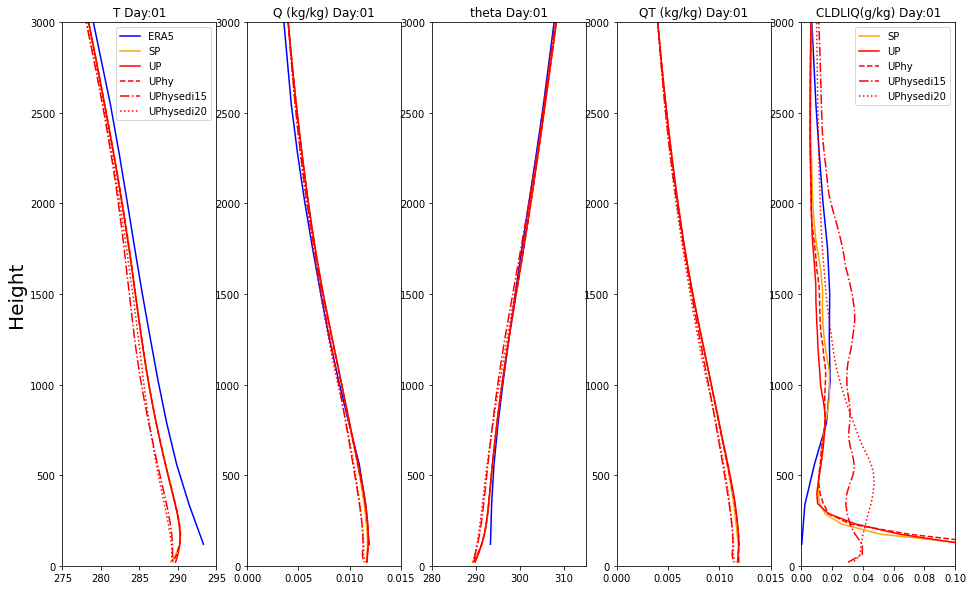

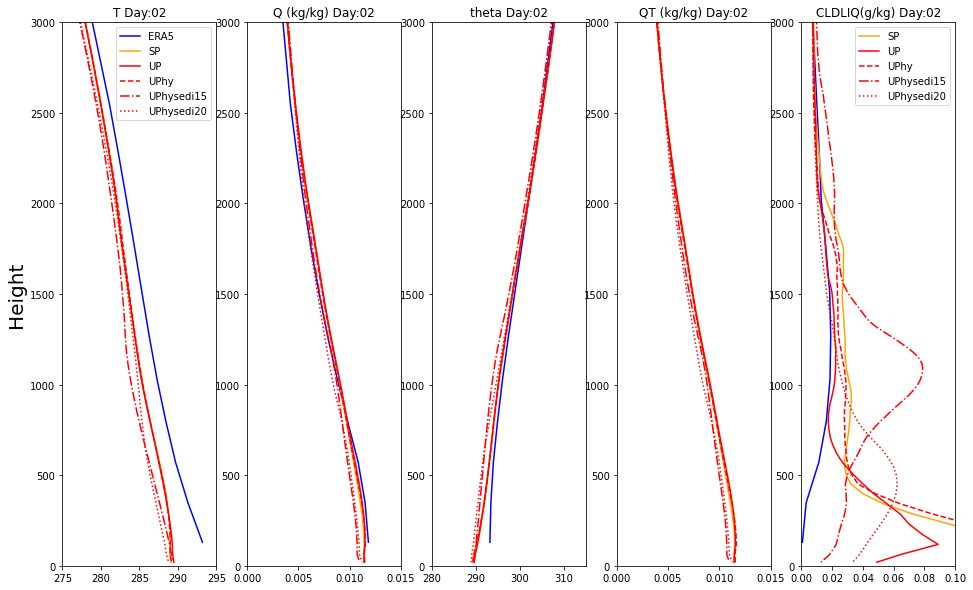

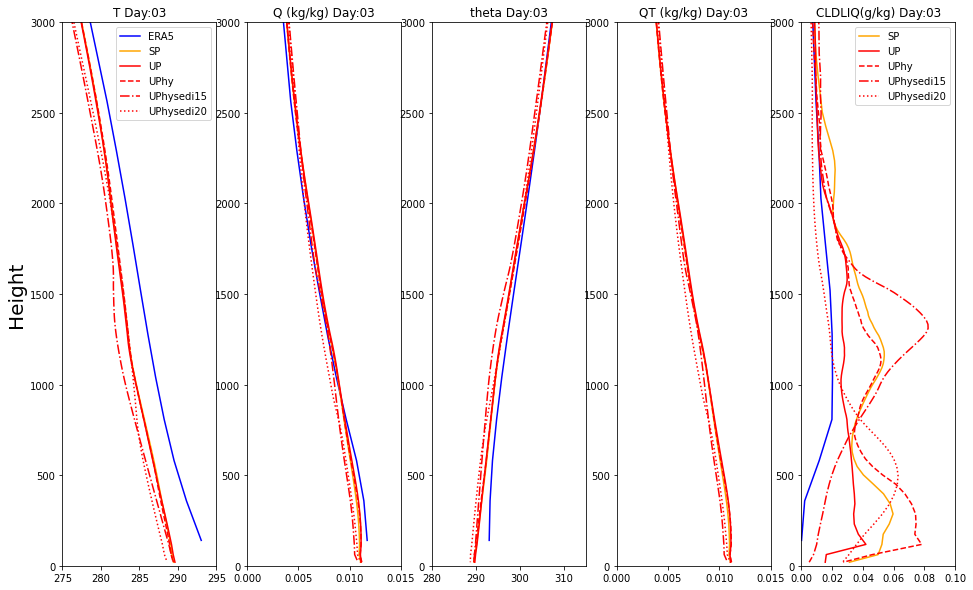

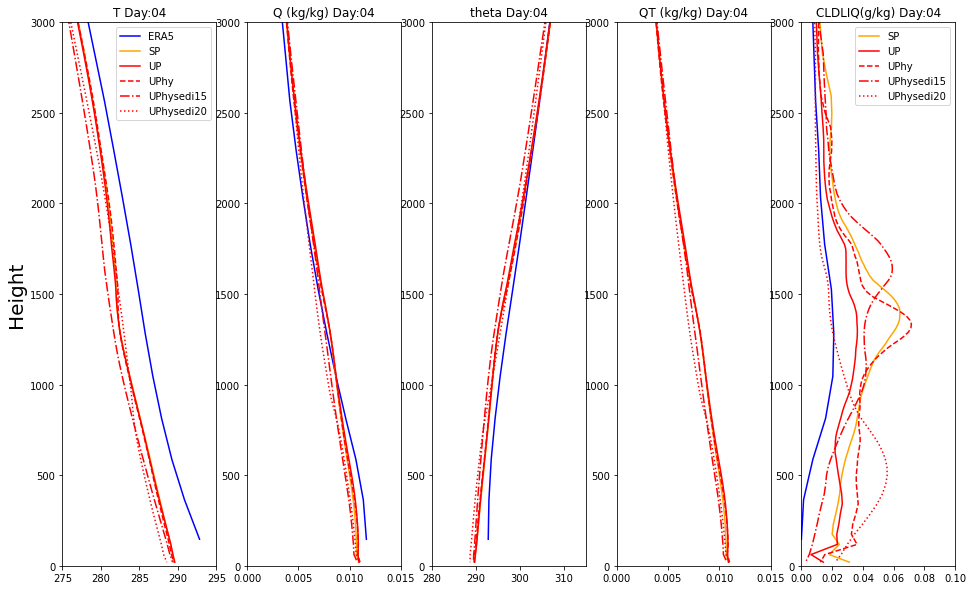

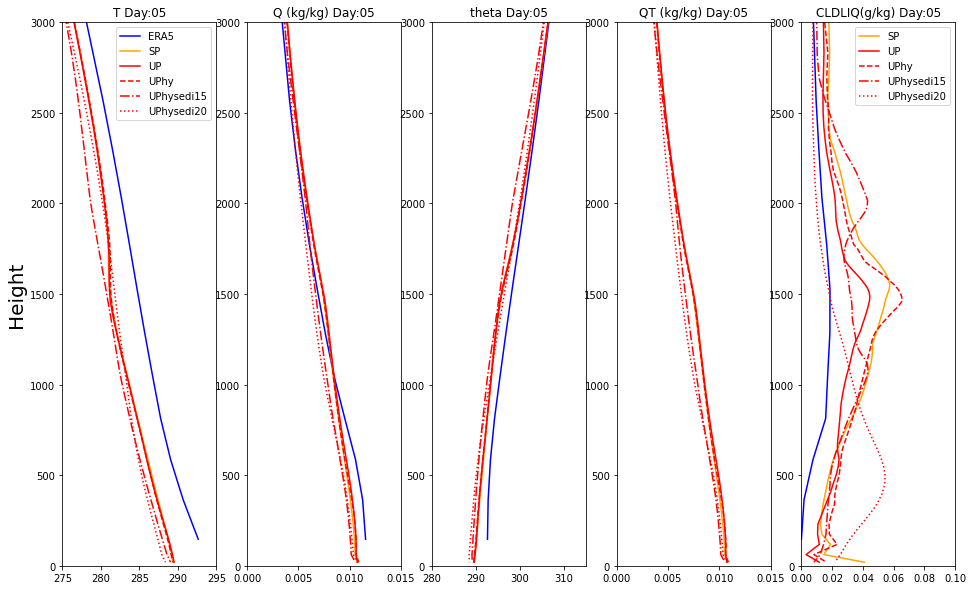

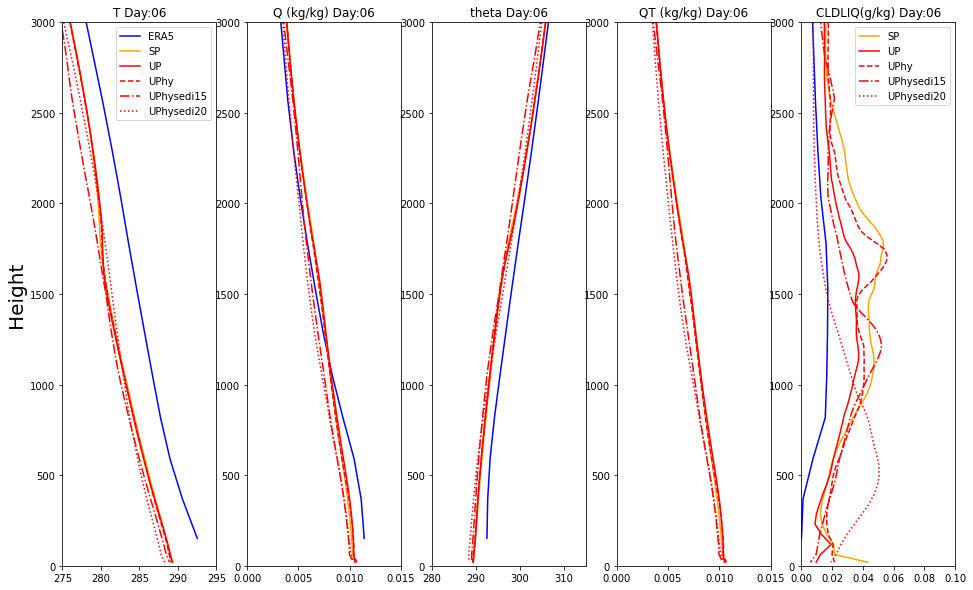

In [43]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Teri_dm = np.zeros([16])
    q_crossERA5Teri_dm = np.zeros([16])
    z_crossERA5Teri_dm = np.zeros([16])
    theta_crossERA5Teri_dm = np.zeros([16])
    lw_crossERA5Teri_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Teri_dm[:] = T_crossERA5Teri_dm[:] + ERA5_tTeri[(countday+24*iday),:]
        q_crossERA5Teri_dm[:] = q_crossERA5Teri_dm[:] + ERA5_qTeri[(countday+24*iday),:]
        z_crossERA5Teri_dm[:] = z_crossERA5Teri_dm[:] + ERA5_zTeri[(countday+24*iday),:]
        lw_crossERA5Teri_dm[:] = lw_crossERA5Teri_dm[:] + ERA5_lwTeri[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Teri_dm[izz] = potential_temperature(T_crossERA5Teri_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Teri_dm[:] = T_crossERA5Teri_dm[:]/(countday)
    q_crossERA5Teri_dm[:] = q_crossERA5Teri_dm[:]/(countday)
    z_crossERA5Teri_dm[:] = z_crossERA5Teri_dm[:]/(countday)
    theta_crossERA5Teri_dm[:] = theta_crossERA5Teri_dm[:]/(countday)
    lw_crossERA5Teri_dm[:] = lw_crossERA5Teri_dm[:]/(countday)
    T_crossSPTeri_dm = np.zeros([125])
    T_crossUPTeri_dm = np.zeros([125])
    T_crossUPhyTeri_dm = np.zeros([125])
    T_crossUPhysedi15Teri_dm = np.zeros([125])
    T_crossUPhysedi20Teri_dm = np.zeros([125])
    Q_crossSPTeri_dm = np.zeros([125])
    Q_crossUPTeri_dm = np.zeros([125])
    Q_crossUPhyTeri_dm = np.zeros([125])
    Q_crossUPhysedi15Teri_dm = np.zeros([125])
    Q_crossUPhysedi20Teri_dm = np.zeros([125])
    CLDICE_crossSPTeri_dm = np.zeros([125])
    CLDICE_crossUPTeri_dm = np.zeros([125])
    CLDICE_crossUPhyTeri_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Teri_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Teri_dm = np.zeros([125])
    CLDLIQ_crossSPTeri_dm = np.zeros([125])
    CLDLIQ_crossUPTeri_dm = np.zeros([125])
    CLDLIQ_crossUPhyTeri_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Teri_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Teri_dm = np.zeros([125])
    Z3_crossSPTeri_dm = np.zeros([125])
    Z3_crossUPTeri_dm = np.zeros([125])
    Z3_crossUPhyTeri_dm = np.zeros([125])
    Z3_crossUPhysedi15Teri_dm = np.zeros([125])
    Z3_crossUPhysedi20Teri_dm = np.zeros([125])
    theta_crossSPTeri_dm = np.zeros([125])
    theta_crossUPTeri_dm = np.zeros([125])
    theta_crossUPhyTeri_dm = np.zeros([125])
    theta_crossUPhysedi15Teri_dm = np.zeros([125])
    theta_crossUPhysedi20Teri_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPTeri_dm[:] = T_crossSPTeri_dm[:] + T_crossSPTeri[:,isec+144*iday]
        T_crossUPTeri_dm[:] = T_crossUPTeri_dm[:] + T_crossUPTeri[:,isec+144*iday]
        T_crossUPhyTeri_dm[:] = T_crossUPhyTeri_dm[:] + T_crossUPhyTeri[:,isec+144*iday]
        T_crossUPhysedi15Teri_dm[:] = T_crossUPhysedi15Teri_dm[:] + T_crossUPhysedi15Teri[:,isec+144*iday]
        T_crossUPhysedi20Teri_dm[:] = T_crossUPhysedi20Teri_dm[:] + T_crossUPhysedi20Teri[:,isec+144*iday]
        Q_crossSPTeri_dm[:] = Q_crossSPTeri_dm[:] + Q_crossSPTeri[:,isec+144*iday]
        Q_crossUPTeri_dm[:] = Q_crossUPTeri_dm[:] + Q_crossUPTeri[:,isec+144*iday]
        Q_crossUPhyTeri_dm[:] = Q_crossUPhyTeri_dm[:] + Q_crossUPhyTeri[:,isec+144*iday]
        Q_crossUPhysedi15Teri_dm[:] = Q_crossUPhysedi15Teri_dm[:] + Q_crossUPhysedi15Teri[:,isec+144*iday]
        Q_crossUPhysedi20Teri_dm[:] = Q_crossUPhysedi20Teri_dm[:] + Q_crossUPhysedi20Teri[:,isec+144*iday]
        CLDLIQ_crossSPTeri_dm[:] = CLDLIQ_crossSPTeri_dm[:] + CLDLIQ_crossSPTeri[:,isec+144*iday]
        CLDLIQ_crossUPTeri_dm[:] = CLDLIQ_crossUPTeri_dm[:] + CLDLIQ_crossUPTeri[:,isec+144*iday]
        CLDLIQ_crossUPhyTeri_dm[:] = CLDLIQ_crossUPhyTeri_dm[:] + CLDLIQ_crossUPhyTeri[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Teri_dm[:] = CLDLIQ_crossUPhysedi15Teri_dm[:] + CLDLIQ_crossUPhysedi15Teri[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Teri_dm[:] = CLDLIQ_crossUPhysedi20Teri_dm[:] + CLDLIQ_crossUPhysedi20Teri[:,isec+144*iday]
        CLDICE_crossSPTeri_dm[:] = CLDICE_crossSPTeri_dm[:] + CLDICE_crossSPTeri[:,isec+144*iday]
        CLDICE_crossUPTeri_dm[:] = CLDICE_crossUPTeri_dm[:] + CLDICE_crossUPTeri[:,isec+144*iday]
        CLDICE_crossUPhyTeri_dm[:] = CLDICE_crossUPhyTeri_dm[:] + CLDICE_crossUPhyTeri[:,isec+144*iday]
        CLDICE_crossUPhysedi15Teri_dm[:] = CLDICE_crossUPhysedi15Teri_dm[:] + CLDICE_crossUPhysedi15Teri[:,isec+144*iday]
        CLDICE_crossUPhysedi20Teri_dm[:] = CLDICE_crossUPhysedi20Teri_dm[:] + CLDICE_crossUPhysedi20Teri[:,isec+144*iday]
        Z3_crossSPTeri_dm[:] = Z3_crossSPTeri_dm[:] + Z3_crossSPTeri[:,isec+144*iday]
        Z3_crossUPTeri_dm[:] = Z3_crossUPTeri_dm[:] + Z3_crossUPTeri[:,isec+144*iday]
        Z3_crossUPhyTeri_dm[:] = Z3_crossUPhyTeri_dm[:] + Z3_crossUPhyTeri[:,isec+144*iday]
        Z3_crossUPhysedi15Teri_dm[:] = Z3_crossUPhysedi15Teri_dm[:] + Z3_crossUPhysedi15Teri[:,isec+144*iday]
        Z3_crossUPhysedi20Teri_dm[:] = Z3_crossUPhysedi20Teri_dm[:] + Z3_crossUPhysedi20Teri[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPTeri_dm[izz] = theta_crossSPTeri_dm[izz] + potential_temperature(T_crossSPTeri[izz,isec+144*iday],P_crossSPTeri[izz,isec+144*iday]*100)
            #theta_crossUPTeri_dm[izz] = theta_crossUPTeri_dm[izz] + potential_temperature(T_crossUPTeri[izz,isec+144*iday],P_crossUPTeri[izz,isec+144*iday]*100)
            #theta_crossUPhyTeri_dm[izz] = theta_crossUPhyTeri_dm[izz] + potential_temperature(T_crossUPhyTeri[izz,isec+144*iday],P_crossUPhyTeri[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Teri_dm[izz] = theta_crossUPhysedi15Teri_dm[izz] + potential_temperature(T_crossUPhysedi15Teri[izz,isec+144*iday],P_crossUPhysedi15Teri[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Teri_dm[izz] = theta_crossUPhysedi20Teri_dm[izz] + potential_temperature(T_crossUPhysedi20Teri[izz,isec+144*iday],P_crossUPhysedi20Teri[izz,isec+144*iday]*100)
            theta_crossSPTeri_dm[izz] = theta_crossSPTeri_dm[izz] + potential_temperature(T_crossSPTeri[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPTeri_dm[izz] = theta_crossUPTeri_dm[izz] + potential_temperature(T_crossUPTeri[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyTeri_dm[izz] = theta_crossUPhyTeri_dm[izz] + potential_temperature(T_crossUPhyTeri[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Teri_dm[izz] = theta_crossUPhysedi15Teri_dm[izz] + potential_temperature(T_crossUPhysedi15Teri[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Teri_dm[izz] = theta_crossUPhysedi20Teri_dm[izz] + potential_temperature(T_crossUPhysedi20Teri[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPTeri_dm = T_crossSPTeri_dm/(countsec)
    T_crossUPTeri_dm = T_crossUPTeri_dm/(countsec)
    T_crossUPhyTeri_dm = T_crossUPhyTeri_dm/(countsec)
    T_crossUPhysedi15Teri_dm = T_crossUPhysedi15Teri_dm/(countsec)
    T_crossUPhysedi20Teri_dm = T_crossUPhysedi20Teri_dm/(countsec)
    Q_crossSPTeri_dm = Q_crossSPTeri_dm/(countsec)
    Q_crossUPTeri_dm = Q_crossUPTeri_dm/(countsec)
    Q_crossUPhyTeri_dm = Q_crossUPhyTeri_dm/(countsec)
    Q_crossUPhysedi15Teri_dm = Q_crossUPhysedi15Teri_dm/(countsec)
    Q_crossUPhysedi20Teri_dm = Q_crossUPhysedi20Teri_dm/(countsec)  
    CLDICE_crossSPTeri_dm = CLDICE_crossSPTeri_dm/(countsec)
    CLDICE_crossUPTeri_dm = CLDICE_crossUPTeri_dm/(countsec)
    CLDICE_crossUPhyTeri_dm = CLDICE_crossUPhyTeri_dm/(countsec)
    CLDICE_crossUPhysedi15Teri_dm = CLDICE_crossUPhysedi15Teri_dm/(countsec)
    CLDICE_crossUPhysedi20Teri_dm = CLDICE_crossUPhysedi20Teri_dm/(countsec)  
    CLDLIQ_crossSPTeri_dm = CLDLIQ_crossSPTeri_dm/(countsec)
    CLDLIQ_crossUPTeri_dm = CLDLIQ_crossUPTeri_dm/(countsec)
    CLDLIQ_crossUPhyTeri_dm = CLDLIQ_crossUPhyTeri_dm/(countsec)
    CLDLIQ_crossUPhysedi15Teri_dm = CLDLIQ_crossUPhysedi15Teri_dm/(countsec)
    CLDLIQ_crossUPhysedi20Teri_dm = CLDLIQ_crossUPhysedi20Teri_dm/(countsec)  
    Z3_crossSPTeri_dm = Z3_crossSPTeri_dm/(countsec)
    Z3_crossUPTeri_dm = Z3_crossUPTeri_dm/(countsec)
    Z3_crossUPhyTeri_dm = Z3_crossUPhyTeri_dm/(countsec)
    Z3_crossUPhysedi15Teri_dm = Z3_crossUPhysedi15Teri_dm/(countsec)
    Z3_crossUPhysedi20Teri_dm = Z3_crossUPhysedi20Teri_dm/(countsec) 
    theta_crossSPTeri_dm = theta_crossSPTeri_dm/(countsec)
    theta_crossUPTeri_dm = theta_crossUPTeri_dm/(countsec)
    theta_crossUPhyTeri_dm = theta_crossUPhyTeri_dm/(countsec)
    theta_crossUPhysedi15Teri_dm = theta_crossUPhysedi15Teri_dm/(countsec)
    theta_crossUPhysedi20Teri_dm = theta_crossUPhysedi20Teri_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPTeri_dm = Q_crossSPTeri_dm+CLDICE_crossSPTeri_dm+CLDLIQ_crossSPTeri_dm
    QT_crossUPTeri_dm = Q_crossUPTeri_dm+CLDICE_crossUPTeri_dm+CLDLIQ_crossUPTeri_dm
    QT_crossUPhyTeri_dm = Q_crossUPhyTeri_dm+CLDICE_crossUPhyTeri_dm+CLDLIQ_crossUPhyTeri_dm
    QT_crossUPhysedi15Teri_dm = Q_crossUPhysedi15Teri_dm+CLDICE_crossUPhysedi15Teri_dm+CLDLIQ_crossUPhysedi15Teri_dm
    QT_crossUPhysedi20Teri_dm = Q_crossUPhysedi20Teri_dm+CLDICE_crossUPhysedi20Teri_dm+CLDLIQ_crossUPhysedi20Teri_dm
    cf42 = ax4.plot(QT_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Teri_dm,z_crossERA5Teri_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPTeri_dm,Z3_crossSPTeri_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPTeri_dm,Z3_crossUPTeri_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyTeri_dm,Z3_crossUPhyTeri_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Teri_dm,Z3_crossUPhysedi15Teri_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Teri_dm,Z3_crossUPhysedi20Teri_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Teri_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

0
24
1
24
2
24
3
24
4
24
5
24
6
24


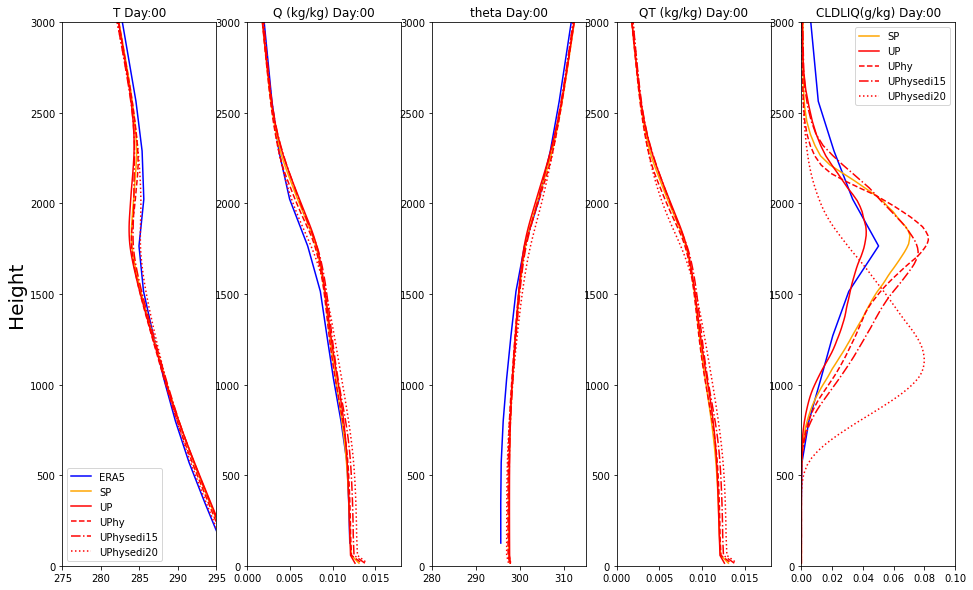

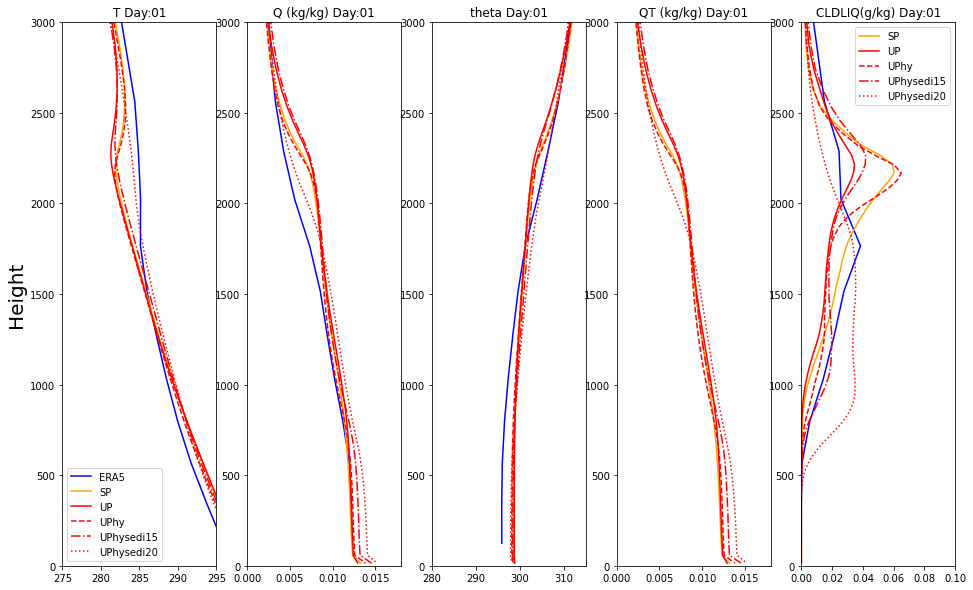

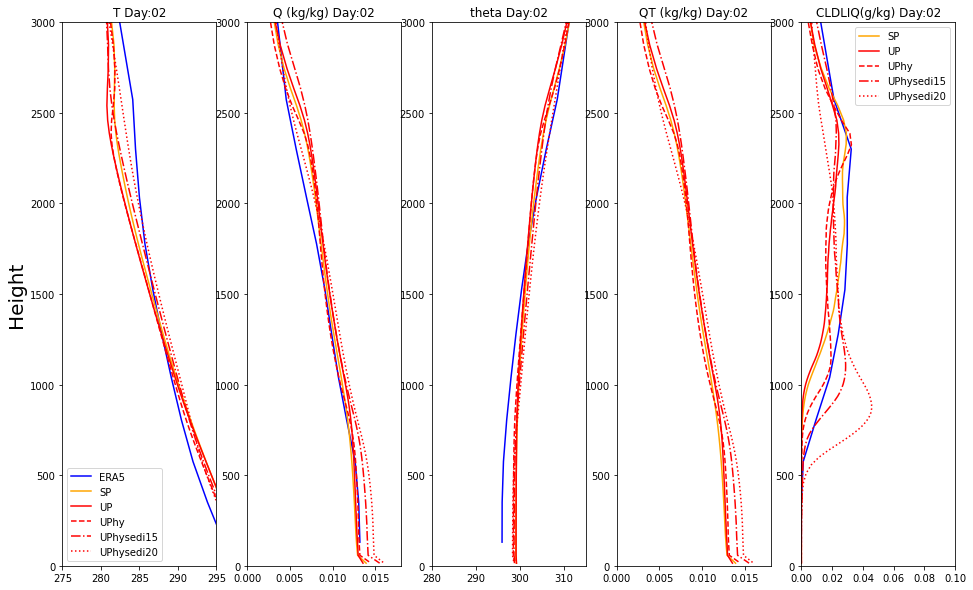

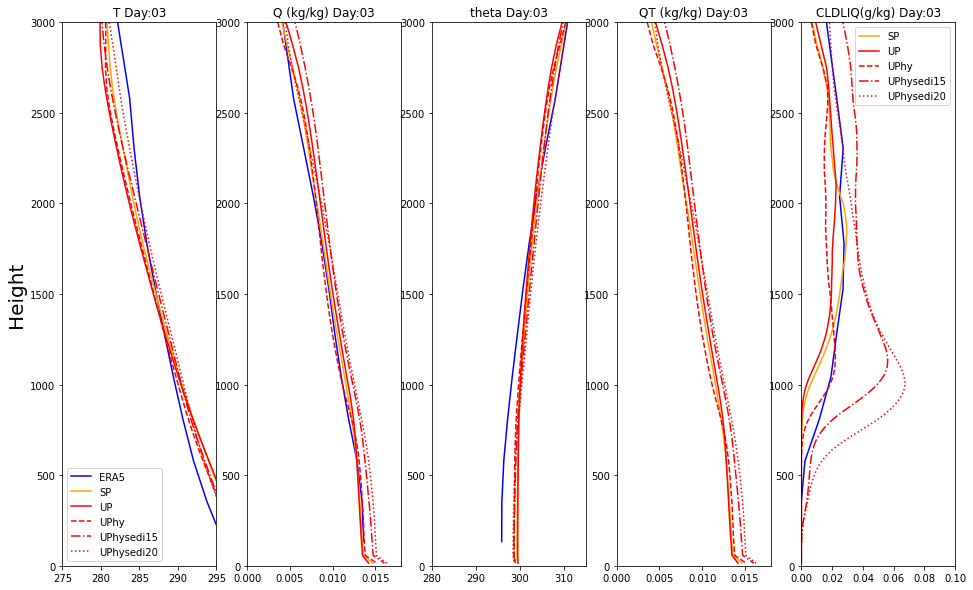

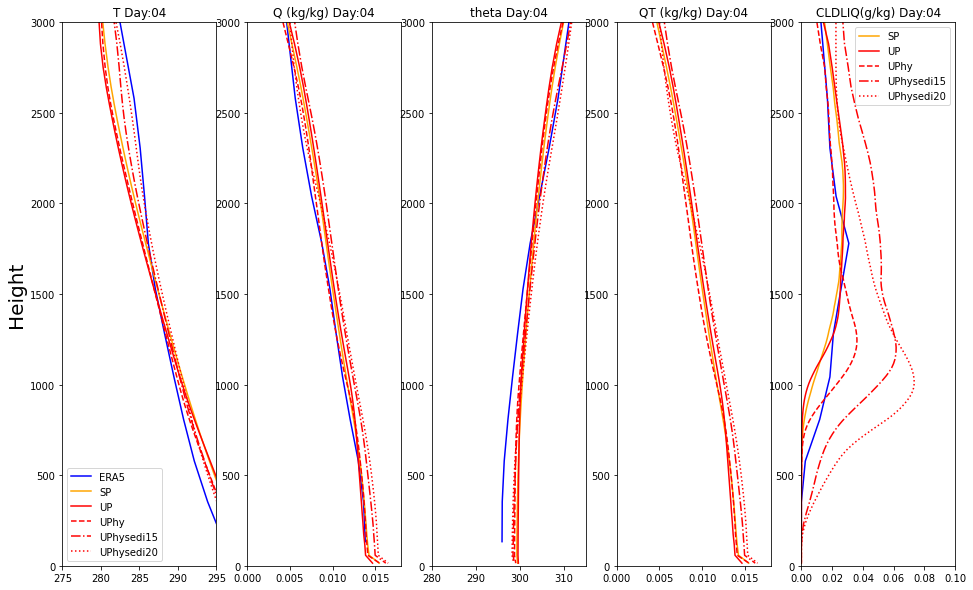

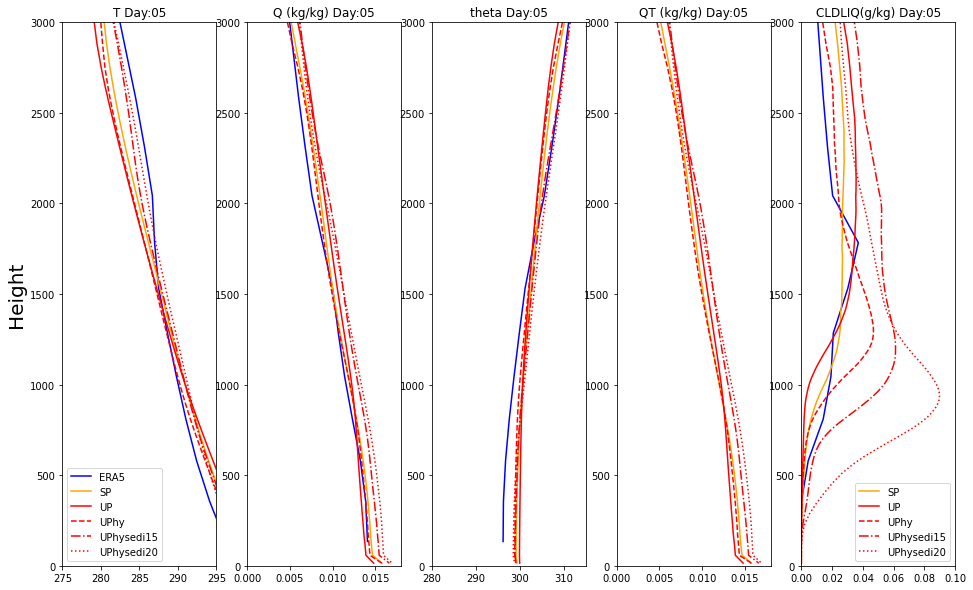

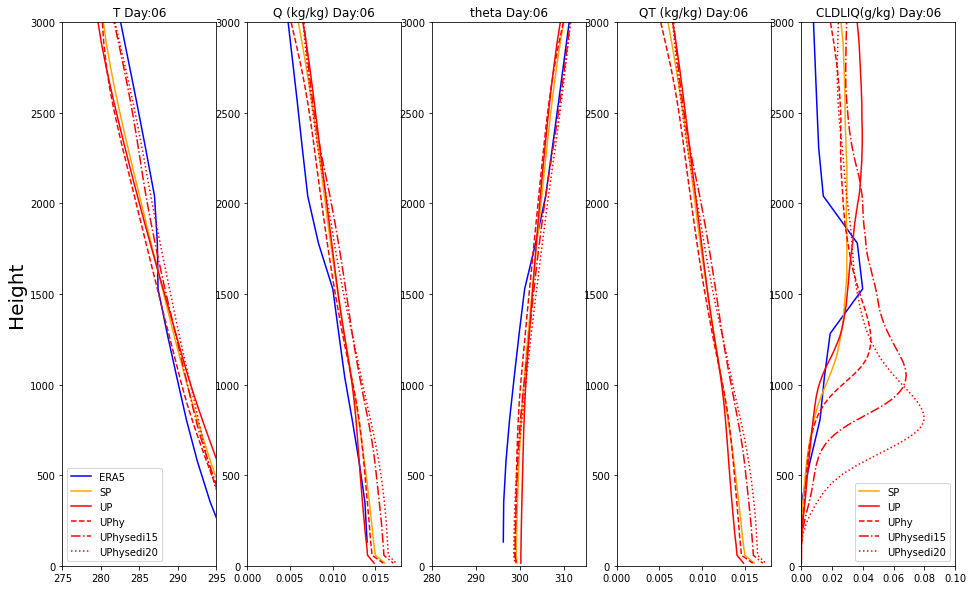

In [45]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Indian_dm = np.zeros([16])
    q_crossERA5Indian_dm = np.zeros([16])
    z_crossERA5Indian_dm = np.zeros([16])
    theta_crossERA5Indian_dm = np.zeros([16])
    lw_crossERA5Indian_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Indian_dm[:] = T_crossERA5Indian_dm[:] + ERA5_tIndian[(countday+24*iday),:]
        q_crossERA5Indian_dm[:] = q_crossERA5Indian_dm[:] + ERA5_qIndian[(countday+24*iday),:]
        z_crossERA5Indian_dm[:] = z_crossERA5Indian_dm[:] + ERA5_zIndian[(countday+24*iday),:]
        lw_crossERA5Indian_dm[:] = lw_crossERA5Indian_dm[:] + ERA5_lwIndian[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Indian_dm[izz] = potential_temperature(T_crossERA5Indian_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Indian_dm[:] = T_crossERA5Indian_dm[:]/(countday)
    q_crossERA5Indian_dm[:] = q_crossERA5Indian_dm[:]/(countday)
    z_crossERA5Indian_dm[:] = z_crossERA5Indian_dm[:]/(countday)
    theta_crossERA5Indian_dm[:] = theta_crossERA5Indian_dm[:]/(countday)
    lw_crossERA5Indian_dm[:] = lw_crossERA5Indian_dm[:]/(countday)
    T_crossSPIndian_dm = np.zeros([125])
    T_crossUPIndian_dm = np.zeros([125])
    T_crossUPhyIndian_dm = np.zeros([125])
    T_crossUPhysedi15Indian_dm = np.zeros([125])
    T_crossUPhysedi20Indian_dm = np.zeros([125])
    Q_crossSPIndian_dm = np.zeros([125])
    Q_crossUPIndian_dm = np.zeros([125])
    Q_crossUPhyIndian_dm = np.zeros([125])
    Q_crossUPhysedi15Indian_dm = np.zeros([125])
    Q_crossUPhysedi20Indian_dm = np.zeros([125])
    CLDICE_crossSPIndian_dm = np.zeros([125])
    CLDICE_crossUPIndian_dm = np.zeros([125])
    CLDICE_crossUPhyIndian_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Indian_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Indian_dm = np.zeros([125])
    CLDLIQ_crossSPIndian_dm = np.zeros([125])
    CLDLIQ_crossUPIndian_dm = np.zeros([125])
    CLDLIQ_crossUPhyIndian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Indian_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Indian_dm = np.zeros([125])
    Z3_crossSPIndian_dm = np.zeros([125])
    Z3_crossUPIndian_dm = np.zeros([125])
    Z3_crossUPhyIndian_dm = np.zeros([125])
    Z3_crossUPhysedi15Indian_dm = np.zeros([125])
    Z3_crossUPhysedi20Indian_dm = np.zeros([125])
    theta_crossSPIndian_dm = np.zeros([125])
    theta_crossUPIndian_dm = np.zeros([125])
    theta_crossUPhyIndian_dm = np.zeros([125])
    theta_crossUPhysedi15Indian_dm = np.zeros([125])
    theta_crossUPhysedi20Indian_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPIndian_dm[:] = T_crossSPIndian_dm[:] + T_crossSPIndian[:,isec+144*iday]
        T_crossUPIndian_dm[:] = T_crossUPIndian_dm[:] + T_crossUPIndian[:,isec+144*iday]
        T_crossUPhyIndian_dm[:] = T_crossUPhyIndian_dm[:] + T_crossUPhyIndian[:,isec+144*iday]
        T_crossUPhysedi15Indian_dm[:] = T_crossUPhysedi15Indian_dm[:] + T_crossUPhysedi15Indian[:,isec+144*iday]
        T_crossUPhysedi20Indian_dm[:] = T_crossUPhysedi20Indian_dm[:] + T_crossUPhysedi20Indian[:,isec+144*iday]
        Q_crossSPIndian_dm[:] = Q_crossSPIndian_dm[:] + Q_crossSPIndian[:,isec+144*iday]
        Q_crossUPIndian_dm[:] = Q_crossUPIndian_dm[:] + Q_crossUPIndian[:,isec+144*iday]
        Q_crossUPhyIndian_dm[:] = Q_crossUPhyIndian_dm[:] + Q_crossUPhyIndian[:,isec+144*iday]
        Q_crossUPhysedi15Indian_dm[:] = Q_crossUPhysedi15Indian_dm[:] + Q_crossUPhysedi15Indian[:,isec+144*iday]
        Q_crossUPhysedi20Indian_dm[:] = Q_crossUPhysedi20Indian_dm[:] + Q_crossUPhysedi20Indian[:,isec+144*iday]
        CLDLIQ_crossSPIndian_dm[:] = CLDLIQ_crossSPIndian_dm[:] + CLDLIQ_crossSPIndian[:,isec+144*iday]
        CLDLIQ_crossUPIndian_dm[:] = CLDLIQ_crossUPIndian_dm[:] + CLDLIQ_crossUPIndian[:,isec+144*iday]
        CLDLIQ_crossUPhyIndian_dm[:] = CLDLIQ_crossUPhyIndian_dm[:] + CLDLIQ_crossUPhyIndian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Indian_dm[:] = CLDLIQ_crossUPhysedi15Indian_dm[:] + CLDLIQ_crossUPhysedi15Indian[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Indian_dm[:] = CLDLIQ_crossUPhysedi20Indian_dm[:] + CLDLIQ_crossUPhysedi20Indian[:,isec+144*iday]
        CLDICE_crossSPIndian_dm[:] = CLDICE_crossSPIndian_dm[:] + CLDICE_crossSPIndian[:,isec+144*iday]
        CLDICE_crossUPIndian_dm[:] = CLDICE_crossUPIndian_dm[:] + CLDICE_crossUPIndian[:,isec+144*iday]
        CLDICE_crossUPhyIndian_dm[:] = CLDICE_crossUPhyIndian_dm[:] + CLDICE_crossUPhyIndian[:,isec+144*iday]
        CLDICE_crossUPhysedi15Indian_dm[:] = CLDICE_crossUPhysedi15Indian_dm[:] + CLDICE_crossUPhysedi15Indian[:,isec+144*iday]
        CLDICE_crossUPhysedi20Indian_dm[:] = CLDICE_crossUPhysedi20Indian_dm[:] + CLDICE_crossUPhysedi20Indian[:,isec+144*iday]
        Z3_crossSPIndian_dm[:] = Z3_crossSPIndian_dm[:] + Z3_crossSPIndian[:,isec+144*iday]
        Z3_crossUPIndian_dm[:] = Z3_crossUPIndian_dm[:] + Z3_crossUPIndian[:,isec+144*iday]
        Z3_crossUPhyIndian_dm[:] = Z3_crossUPhyIndian_dm[:] + Z3_crossUPhyIndian[:,isec+144*iday]
        Z3_crossUPhysedi15Indian_dm[:] = Z3_crossUPhysedi15Indian_dm[:] + Z3_crossUPhysedi15Indian[:,isec+144*iday]
        Z3_crossUPhysedi20Indian_dm[:] = Z3_crossUPhysedi20Indian_dm[:] + Z3_crossUPhysedi20Indian[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPIndian_dm[izz] = theta_crossSPIndian_dm[izz] + potential_temperature(T_crossSPIndian[izz,isec+144*iday],P_crossSPIndian[izz,isec+144*iday]*100)
            #theta_crossUPIndian_dm[izz] = theta_crossUPIndian_dm[izz] + potential_temperature(T_crossUPIndian[izz,isec+144*iday],P_crossUPIndian[izz,isec+144*iday]*100)
            #theta_crossUPhyIndian_dm[izz] = theta_crossUPhyIndian_dm[izz] + potential_temperature(T_crossUPhyIndian[izz,isec+144*iday],P_crossUPhyIndian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Indian_dm[izz] = theta_crossUPhysedi15Indian_dm[izz] + potential_temperature(T_crossUPhysedi15Indian[izz,isec+144*iday],P_crossUPhysedi15Indian[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Indian_dm[izz] = theta_crossUPhysedi20Indian_dm[izz] + potential_temperature(T_crossUPhysedi20Indian[izz,isec+144*iday],P_crossUPhysedi20Indian[izz,isec+144*iday]*100)
            theta_crossSPIndian_dm[izz] = theta_crossSPIndian_dm[izz] + potential_temperature(T_crossSPIndian[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPIndian_dm[izz] = theta_crossUPIndian_dm[izz] + potential_temperature(T_crossUPIndian[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyIndian_dm[izz] = theta_crossUPhyIndian_dm[izz] + potential_temperature(T_crossUPhyIndian[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Indian_dm[izz] = theta_crossUPhysedi15Indian_dm[izz] + potential_temperature(T_crossUPhysedi15Indian[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Indian_dm[izz] = theta_crossUPhysedi20Indian_dm[izz] + potential_temperature(T_crossUPhysedi20Indian[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPIndian_dm = T_crossSPIndian_dm/(countsec)
    T_crossUPIndian_dm = T_crossUPIndian_dm/(countsec)
    T_crossUPhyIndian_dm = T_crossUPhyIndian_dm/(countsec)
    T_crossUPhysedi15Indian_dm = T_crossUPhysedi15Indian_dm/(countsec)
    T_crossUPhysedi20Indian_dm = T_crossUPhysedi20Indian_dm/(countsec)
    Q_crossSPIndian_dm = Q_crossSPIndian_dm/(countsec)
    Q_crossUPIndian_dm = Q_crossUPIndian_dm/(countsec)
    Q_crossUPhyIndian_dm = Q_crossUPhyIndian_dm/(countsec)
    Q_crossUPhysedi15Indian_dm = Q_crossUPhysedi15Indian_dm/(countsec)
    Q_crossUPhysedi20Indian_dm = Q_crossUPhysedi20Indian_dm/(countsec)  
    CLDICE_crossSPIndian_dm = CLDICE_crossSPIndian_dm/(countsec)
    CLDICE_crossUPIndian_dm = CLDICE_crossUPIndian_dm/(countsec)
    CLDICE_crossUPhyIndian_dm = CLDICE_crossUPhyIndian_dm/(countsec)
    CLDICE_crossUPhysedi15Indian_dm = CLDICE_crossUPhysedi15Indian_dm/(countsec)
    CLDICE_crossUPhysedi20Indian_dm = CLDICE_crossUPhysedi20Indian_dm/(countsec)  
    CLDLIQ_crossSPIndian_dm = CLDLIQ_crossSPIndian_dm/(countsec)
    CLDLIQ_crossUPIndian_dm = CLDLIQ_crossUPIndian_dm/(countsec)
    CLDLIQ_crossUPhyIndian_dm = CLDLIQ_crossUPhyIndian_dm/(countsec)
    CLDLIQ_crossUPhysedi15Indian_dm = CLDLIQ_crossUPhysedi15Indian_dm/(countsec)
    CLDLIQ_crossUPhysedi20Indian_dm = CLDLIQ_crossUPhysedi20Indian_dm/(countsec)  
    Z3_crossSPIndian_dm = Z3_crossSPIndian_dm/(countsec)
    Z3_crossUPIndian_dm = Z3_crossUPIndian_dm/(countsec)
    Z3_crossUPhyIndian_dm = Z3_crossUPhyIndian_dm/(countsec)
    Z3_crossUPhysedi15Indian_dm = Z3_crossUPhysedi15Indian_dm/(countsec)
    Z3_crossUPhysedi20Indian_dm = Z3_crossUPhysedi20Indian_dm/(countsec) 
    theta_crossSPIndian_dm = theta_crossSPIndian_dm/(countsec)
    theta_crossUPIndian_dm = theta_crossUPIndian_dm/(countsec)
    theta_crossUPhyIndian_dm = theta_crossUPhyIndian_dm/(countsec)
    theta_crossUPhysedi15Indian_dm = theta_crossUPhysedi15Indian_dm/(countsec)
    theta_crossUPhysedi20Indian_dm = theta_crossUPhysedi20Indian_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Indian_dm,z_crossERA5Indian_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPIndian_dm,Z3_crossSPIndian_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPIndian_dm,Z3_crossUPIndian_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyIndian_dm,Z3_crossUPhyIndian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Indian_dm,Z3_crossUPhysedi15Indian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Indian_dm,Z3_crossUPhysedi20Indian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Indian_dm,z_crossERA5Indian_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPIndian_dm,Z3_crossSPIndian_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPIndian_dm,Z3_crossUPIndian_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyIndian_dm,Z3_crossUPhyIndian_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Indian_dm,Z3_crossUPhysedi15Indian_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Indian_dm,Z3_crossUPhysedi20Indian_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.018), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Indian_dm,z_crossERA5Indian_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPIndian_dm,Z3_crossSPIndian_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPIndian_dm,Z3_crossUPIndian_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyIndian_dm,Z3_crossUPhyIndian_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Indian_dm,Z3_crossUPhysedi15Indian_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Indian_dm,Z3_crossUPhysedi20Indian_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPIndian_dm = Q_crossSPIndian_dm+CLDICE_crossSPIndian_dm+CLDLIQ_crossSPIndian_dm
    QT_crossUPIndian_dm = Q_crossUPIndian_dm+CLDICE_crossUPIndian_dm+CLDLIQ_crossUPIndian_dm
    QT_crossUPhyIndian_dm = Q_crossUPhyIndian_dm+CLDICE_crossUPhyIndian_dm+CLDLIQ_crossUPhyIndian_dm
    QT_crossUPhysedi15Indian_dm = Q_crossUPhysedi15Indian_dm+CLDICE_crossUPhysedi15Indian_dm+CLDLIQ_crossUPhysedi15Indian_dm
    QT_crossUPhysedi20Indian_dm = Q_crossUPhysedi20Indian_dm+CLDICE_crossUPhysedi20Indian_dm+CLDLIQ_crossUPhysedi20Indian_dm
    cf42 = ax4.plot(QT_crossSPIndian_dm,Z3_crossSPIndian_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPIndian_dm,Z3_crossUPIndian_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyIndian_dm,Z3_crossUPhyIndian_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Indian_dm,Z3_crossUPhysedi15Indian_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Indian_dm,Z3_crossUPhysedi20Indian_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.018), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Indian_dm,z_crossERA5Indian_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPIndian_dm,Z3_crossSPIndian_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPIndian_dm,Z3_crossUPIndian_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyIndian_dm,Z3_crossUPhyIndian_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Indian_dm,Z3_crossUPhysedi15Indian_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Indian_dm,Z3_crossUPhysedi20Indian_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Indian_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

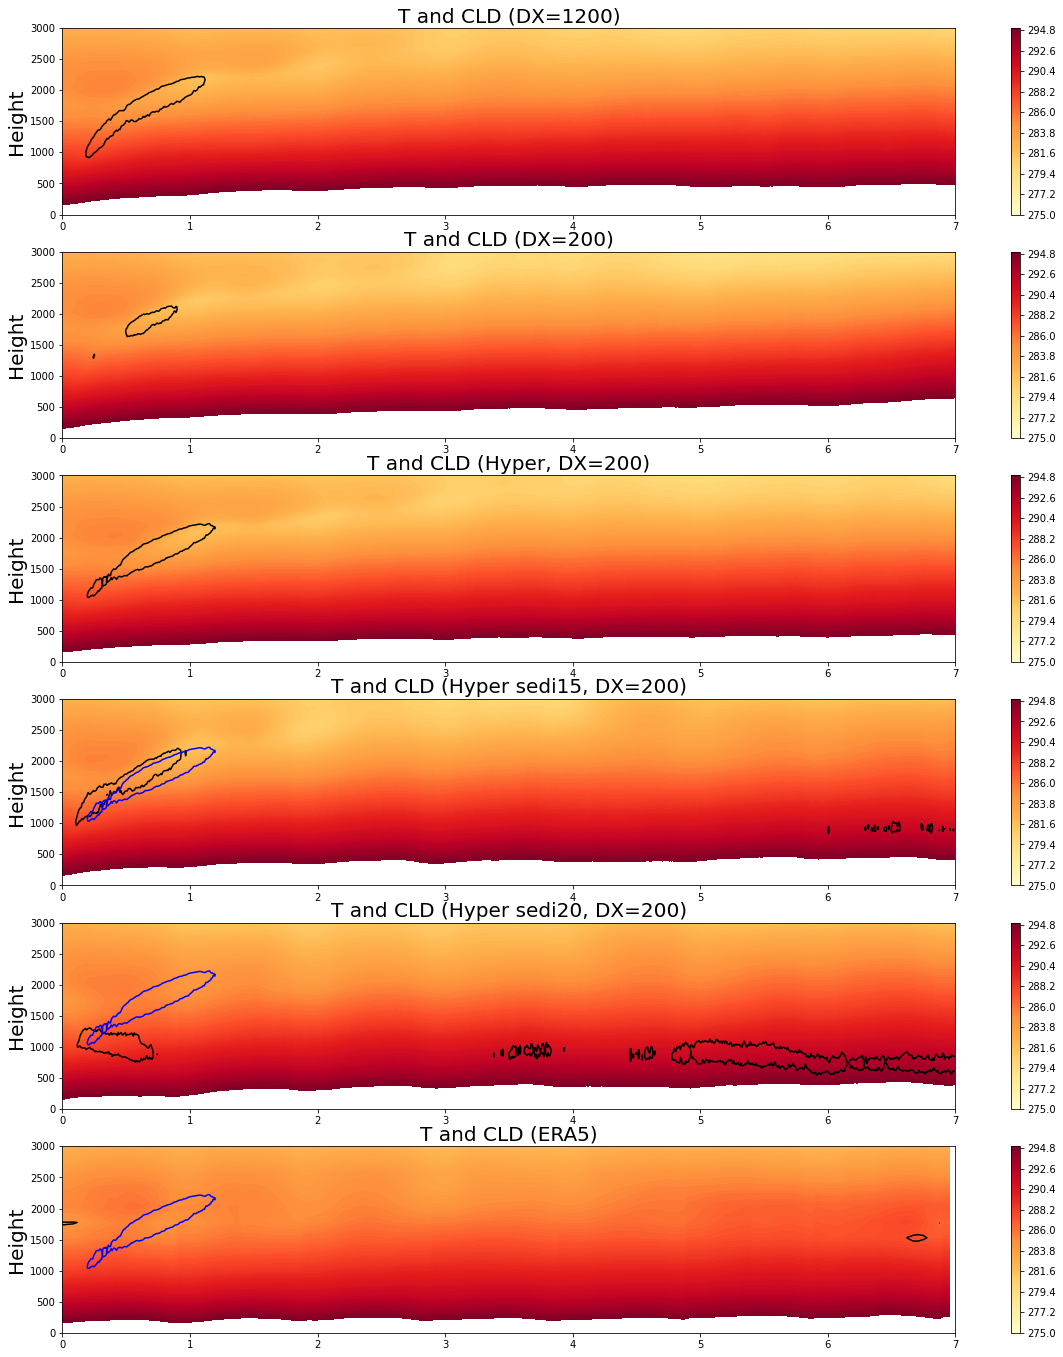

In [42]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [295]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPIndian,T_crossSPIndian,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPIndian,cld_crossSPIndian,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPIndian,T_crossUPIndian,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPIndian,cld_crossUPIndian,200,colors='k', levels=[0.2], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyIndian,T_crossUPhyIndian,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyIndian,cld_crossUPhyIndian,200,colors='k', levels=[0.2], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Indian,T_crossUPhysedi15Indian,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Indian,cld_crossUPhysedi15Indian,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyIndian,cld_crossUPhyIndian,200,colors='b', levels=[0.2], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Indian,T_crossUPhysedi20Indian,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Indian,cld_crossUPhysedi20Indian,200,colors='k', levels=[0.2], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyIndian,cld_crossUPhyIndian,200,colors='b', levels=[0.2], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zIndian/9.8,ERA5_tIndian,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zIndian/9.8,ERA5_ccIndian,200,colors='k', levels=[0.2], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyIndian,cld_crossUPhyIndian,200,colors='b', levels=[0.2], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Indian_Time_Height_Model_ERA5.png')

# Warmpool

In [46]:
spww_SPWarm = np.zeros([1009,125])
spww_UPWarm = np.zeros([1009,125])
spww_UPhyWarm = np.zeros([1009,125])
spww_UPhysedi20Warm = np.zeros([1009,125])
spww_UPhysedi15Warm = np.zeros([1009,125])
Z3_SPWarm = np.zeros([1009,125])
Z3_UPWarm = np.zeros([1009,125])
Z3_UPhyWarm = np.zeros([1009,125])
Z3_UPhysedi20Warm = np.zeros([1009,125])
Z3_UPhysedi15Warm = np.zeros([1009,125])
pttend_SPWarm = np.zeros([1009,125])
pttend_UPWarm = np.zeros([1009,125])
pttend_UPhyWarm = np.zeros([1009,125])
pttend_UPhysedi20Warm = np.zeros([1009,125])
pttend_UPhysedi15Warm = np.zeros([1009,125])
cld_SPWarm = np.zeros([1009,125])
cld_UPWarm = np.zeros([1009,125])
cld_UPhyWarm = np.zeros([1009,125])
cld_UPhysedi20Warm = np.zeros([1009,125])
cld_UPhysedi15Warm = np.zeros([1009,125])
T_SPWarm = np.zeros([1009,125])
T_UPWarm = np.zeros([1009,125])
T_UPhyWarm = np.zeros([1009,125])
T_UPhysedi20Warm = np.zeros([1009,125])
T_UPhysedi15Warm = np.zeros([1009,125])
CLDLIQ_SPWarm = np.zeros([1009,125])
CLDLIQ_UPWarm = np.zeros([1009,125])
CLDLIQ_UPhyWarm = np.zeros([1009,125])
CLDLIQ_UPhysedi20Warm = np.zeros([1009,125])
CLDLIQ_UPhysedi15Warm = np.zeros([1009,125])
CLDICE_SPWarm = np.zeros([1009,125])
CLDICE_UPWarm = np.zeros([1009,125])
CLDICE_UPhyWarm = np.zeros([1009,125])
CLDICE_UPhysedi20Warm = np.zeros([1009,125])
CLDICE_UPhysedi15Warm = np.zeros([1009,125])
Q_SPWarm = np.zeros([1009,125])
Q_UPWarm = np.zeros([1009,125])
Q_UPhyWarm = np.zeros([1009,125])
Q_UPhysedi20Warm = np.zeros([1009,125])
Q_UPhysedi15Warm = np.zeros([1009,125])
P_SPWarm = np.zeros([1009,125])
P_UPWarm = np.zeros([1009,125])
P_UPhyWarm = np.zeros([1009,125])
P_UPhysedi20Warm = np.zeros([1009,125])
P_UPhysedi15Warm = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Warm)):
        spww_SPWarm[it,:] = spww_SPWarm[it,:] + SPWWSP[it,:,ind_Warm[il]]
        spww_UPWarm[it,:] = spww_UPWarm[it,:] + SPWWUP[it,:,ind_Warm[il]]
        spww_UPhyWarm[it,:] = spww_UPhyWarm[it,:] + SPWWUPhy[it,:,ind_Warm[il]]
        spww_UPhysedi15Warm[it,:] = spww_UPhysedi15Warm[it,:] + SPWWUPhysedi15[it,:,ind_Warm[il]]
        spww_UPhysedi20Warm[it,:] = spww_UPhysedi20Warm[it,:] + SPWWUPhysedi20[it,:,ind_Warm[il]]
        Z3_SPWarm[it,:] = Z3_SPWarm[it,:] + Z3SP[it,:,ind_Warm[il]]
        Z3_UPWarm[it,:] = Z3_UPWarm[it,:] + Z3UP[it,:,ind_Warm[il]]
        Z3_UPhyWarm[it,:] = Z3_UPhyWarm[it,:] + Z3UPhy[it,:,ind_Warm[il]]
        Z3_UPhysedi15Warm[it,:] = Z3_UPhysedi15Warm[it,:] + Z3UPhysedi15[it,:,ind_Warm[il]]
        Z3_UPhysedi20Warm[it,:] = Z3_UPhysedi20Warm[it,:] + Z3UPhysedi20[it,:,ind_Warm[il]]
        T_SPWarm[it,:] = T_SPWarm[it,:] + T_SP[it,:,ind_Warm[il]]
        T_UPWarm[it,:] = T_UPWarm[it,:] + T_UP[it,:,ind_Warm[il]]
        T_UPhyWarm[it,:] = T_UPhyWarm[it,:] + T_UPhy[it,:,ind_Warm[il]]
        T_UPhysedi15Warm[it,:] = T_UPhysedi15Warm[it,:] + T_UPhysedi15[it,:,ind_Warm[il]]
        T_UPhysedi20Warm[it,:] = T_UPhysedi20Warm[it,:] + T_UPhysedi20[it,:,ind_Warm[il]]
        CLDICE_SPWarm[it,:] = CLDICE_SPWarm[it,:] + CLDICE_SP[it,:,ind_Warm[il]]
        CLDICE_UPWarm[it,:] = CLDICE_UPWarm[it,:] + CLDICE_UP[it,:,ind_Warm[il]]
        CLDICE_UPhyWarm[it,:] = CLDICE_UPhyWarm[it,:] + CLDICE_UPhy[it,:,ind_Warm[il]]
        CLDICE_UPhysedi15Warm[it,:] = CLDICE_UPhysedi15Warm[it,:] + CLDICE_UPhysedi15[it,:,ind_Warm[il]]
        CLDICE_UPhysedi20Warm[it,:] = CLDICE_UPhysedi20Warm[it,:] + CLDICE_UPhysedi20[it,:,ind_Warm[il]]
        CLDLIQ_SPWarm[it,:] = CLDLIQ_SPWarm[it,:] + CLDLIQ_SP[it,:,ind_Warm[il]]
        CLDLIQ_UPWarm[it,:] = CLDLIQ_UPWarm[it,:] + CLDLIQ_UP[it,:,ind_Warm[il]]
        CLDLIQ_UPhyWarm[it,:] = CLDLIQ_UPhyWarm[it,:] + CLDLIQ_UPhy[it,:,ind_Warm[il]]
        CLDLIQ_UPhysedi15Warm[it,:] = CLDLIQ_UPhysedi15Warm[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Warm[il]]
        CLDLIQ_UPhysedi20Warm[it,:] = CLDLIQ_UPhysedi20Warm[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Warm[il]]
        Q_SPWarm[it,:] = Q_SPWarm[it,:] + Q_SP[it,:,ind_Warm[il]]
        Q_UPWarm[it,:] = Q_UPWarm[it,:] + Q_UP[it,:,ind_Warm[il]]
        Q_UPhyWarm[it,:] = Q_UPhyWarm[it,:] + Q_UPhy[it,:,ind_Warm[il]]
        Q_UPhysedi15Warm[it,:] = Q_UPhysedi15Warm[it,:] + Q_UPhysedi15[it,:,ind_Warm[il]]
        Q_UPhysedi20Warm[it,:] = Q_UPhysedi20Warm[it,:] + Q_UPhysedi20[it,:,ind_Warm[il]]
        pttend_SPWarm[it,:] = pttend_SPWarm[it,:] + PTTEND_SP[it,:,ind_Warm[il]]
        pttend_UPWarm[it,:] = pttend_UPWarm[it,:] + PTTEND_UP[it,:,ind_Warm[il]]
        pttend_UPhyWarm[it,:] = pttend_UPhyWarm[it,:] + PTTEND_UPhy[it,:,ind_Warm[il]]
        pttend_UPhysedi15Warm[it,:] = pttend_UPhysedi15Warm[it,:] + PTTEND_UPhysedi15[it,:,ind_Warm[il]]
        pttend_UPhysedi20Warm[it,:] = pttend_UPhysedi20Warm[it,:] + PTTEND_UPhysedi20[it,:,ind_Warm[il]]
        cld_SPWarm[it,:] = cld_SPWarm[it,:] + CLOUD_SP[it,:,ind_Warm[il]]
        cld_UPWarm[it,:] = cld_UPWarm[it,:] + CLOUD_UP[it,:,ind_Warm[il]]
        cld_UPhyWarm[it,:] = cld_UPhyWarm[it,:] + CLOUD_UPhy[it,:,ind_Warm[il]]
        cld_UPhysedi15Warm[it,:] = cld_UPhysedi15Warm[it,:] + CLOUD_UPhysedi15[it,:,ind_Warm[il]]
        cld_UPhysedi20Warm[it,:] = cld_UPhysedi20Warm[it,:] + CLOUD_UPhysedi20[it,:,ind_Warm[il]]
        P_SPWarm[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPWarm[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyWarm[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Warm[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Warm[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPWarm[it,:] = spww_SPWarm[it,:] /count
    spww_UPWarm[it,:] = spww_UPWarm[it,:]  /count
    spww_UPhyWarm[it,:] = spww_UPhyWarm[it,:] /count
    spww_UPhysedi15Warm[it,:] = spww_UPhysedi15Warm[it,:] /count
    spww_UPhysedi20Warm[it,:] = spww_UPhysedi20Warm[it,:] /count
    Z3_SPWarm[it,:] = Z3_SPWarm[it,:] /count
    Z3_UPWarm[it,:] = Z3_UPWarm[it,:]  /count
    Z3_UPhyWarm[it,:] = Z3_UPhyWarm[it,:] /count
    Z3_UPhysedi15Warm[it,:] = Z3_UPhysedi15Warm[it,:] /count
    Z3_UPhysedi20Warm[it,:] = Z3_UPhysedi20Warm[it,:] /count
    T_SPWarm[it,:] = T_SPWarm[it,:] /count
    T_UPWarm[it,:] = T_UPWarm[it,:]  /count
    T_UPhyWarm[it,:] = T_UPhyWarm[it,:] /count
    T_UPhysedi15Warm[it,:] = T_UPhysedi15Warm[it,:] /count
    T_UPhysedi20Warm[it,:] = T_UPhysedi20Warm[it,:] /count
    CLDICE_SPWarm[it,:] = CLDICE_SPWarm[it,:] /count
    CLDICE_UPWarm[it,:] = CLDICE_UPWarm[it,:]  /count
    CLDICE_UPhyWarm[it,:] = CLDICE_UPhyWarm[it,:] /count
    CLDICE_UPhysedi15Warm[it,:] = CLDICE_UPhysedi15Warm[it,:] /count
    CLDICE_UPhysedi20Warm[it,:] = CLDICE_UPhysedi20Warm[it,:] /count
    CLDLIQ_SPWarm[it,:] = CLDLIQ_SPWarm[it,:] /count
    CLDLIQ_UPWarm[it,:] = CLDLIQ_UPWarm[it,:]  /count
    CLDLIQ_UPhyWarm[it,:] = CLDLIQ_UPhyWarm[it,:] /count
    CLDLIQ_UPhysedi15Warm[it,:] = CLDLIQ_UPhysedi15Warm[it,:] /count
    CLDLIQ_UPhysedi20Warm[it,:] = CLDLIQ_UPhysedi20Warm[it,:] /count
    Q_SPWarm[it,:] = Q_SPWarm[it,:] /count
    Q_UPWarm[it,:] = Q_UPWarm[it,:]  /count
    Q_UPhyWarm[it,:] = Q_UPhyWarm[it,:] /count
    Q_UPhysedi15Warm[it,:] = Q_UPhysedi15Warm[it,:] /count
    Q_UPhysedi20Warm[it,:] = Q_UPhysedi20Warm[it,:] /count
    pttend_SPWarm[it,:] = pttend_SPWarm[it,:] /count
    pttend_UPWarm[it,:] = pttend_UPWarm[it,:]  /count
    pttend_UPhyWarm[it,:] = pttend_UPhyWarm[it,:] /count
    pttend_UPhysedi15Warm[it,:] = pttend_UPhysedi15Warm[it,:] /count
    pttend_UPhysedi20Warm[it,:] = pttend_UPhysedi20Warm[it,:] /count
    cld_SPWarm[it,:] = cld_SPWarm[it,:] /count
    cld_UPWarm[it,:] = cld_UPWarm[it,:]  /count
    cld_UPhyWarm[it,:] = cld_UPhyWarm[it,:] /count
    cld_UPhysedi15Warm[it,:] = cld_UPhysedi15Warm[it,:] /count
    cld_UPhysedi20Warm[it,:] = cld_UPhysedi20Warm[it,:] /count
    P_SPWarm[it,:] = P_SPWarm[it,:] /count
    P_UPWarm[it,:] = P_UPWarm[it,:]  /count
    P_UPhyWarm[it,:] = P_UPhyWarm[it,:] /count
    P_UPhysedi15Warm[it,:] = P_UPhysedi15Warm[it,:] /count
    P_UPhysedi20Warm[it,:] = P_UPhysedi20Warm[it,:] /count
    
spww_crossSPWarm = np.transpose(spww_SPWarm)
spww_crossUPWarm = np.transpose(spww_UPWarm)
spww_crossUPhyWarm = np.transpose(spww_UPhyWarm)
spww_crossUPhysedi15Warm = np.transpose(spww_UPhysedi15Warm)
spww_crossUPhysedi20Warm = np.transpose(spww_UPhysedi20Warm)
Z3_crossSPWarm = np.transpose(Z3_SPWarm)
Z3_crossUPWarm = np.transpose(Z3_UPWarm)
Z3_crossUPhyWarm = np.transpose(Z3_UPhyWarm)
Z3_crossUPhysedi15Warm = np.transpose(Z3_UPhysedi15Warm)
Z3_crossUPhysedi20Warm = np.transpose(Z3_UPhysedi20Warm)
T_crossSPWarm = np.transpose(T_SPWarm)
T_crossUPWarm = np.transpose(T_UPWarm)
T_crossUPhyWarm = np.transpose(T_UPhyWarm)
T_crossUPhysedi15Warm = np.transpose(T_UPhysedi15Warm)
T_crossUPhysedi20Warm = np.transpose(T_UPhysedi20Warm)
CLDICE_crossSPWarm = np.transpose(CLDICE_SPWarm)
CLDICE_crossUPWarm = np.transpose(CLDICE_UPWarm)
CLDICE_crossUPhyWarm = np.transpose(CLDICE_UPhyWarm)
CLDICE_crossUPhysedi15Warm = np.transpose(CLDICE_UPhysedi15Warm)
CLDICE_crossUPhysedi20Warm = np.transpose(CLDICE_UPhysedi20Warm)
CLDLIQ_crossSPWarm = np.transpose(CLDLIQ_SPWarm)
CLDLIQ_crossUPWarm = np.transpose(CLDLIQ_UPWarm)
CLDLIQ_crossUPhyWarm = np.transpose(CLDLIQ_UPhyWarm)
CLDLIQ_crossUPhysedi15Warm = np.transpose(CLDLIQ_UPhysedi15Warm)
CLDLIQ_crossUPhysedi20Warm = np.transpose(CLDLIQ_UPhysedi20Warm)
Q_crossSPWarm = np.transpose(Q_SPWarm)
Q_crossUPWarm = np.transpose(Q_UPWarm)
Q_crossUPhyWarm = np.transpose(Q_UPhyWarm)
Q_crossUPhysedi15Warm = np.transpose(Q_UPhysedi15Warm)
Q_crossUPhysedi20Warm = np.transpose(Q_UPhysedi20Warm)
pttend_crossSPWarm = np.transpose(pttend_SPWarm)
pttend_crossUPWarm = np.transpose(pttend_UPWarm)
pttend_crossUPhyWarm = np.transpose(pttend_UPhyWarm)
pttend_crossUPhysedi15Warm = np.transpose(pttend_UPhysedi15Warm)
pttend_crossUPhysedi20Warm = np.transpose(pttend_UPhysedi20Warm)
cld_crossSPWarm = np.transpose(cld_SPWarm)
cld_crossUPWarm = np.transpose(cld_UPWarm)
cld_crossUPhyWarm = np.transpose(cld_UPhyWarm)
cld_crossUPhysedi15Warm = np.transpose(cld_UPhysedi15Warm)
cld_crossUPhysedi20Warm = np.transpose(cld_UPhysedi20Warm)
P_crossSPWarm = np.transpose(P_SPWarm)
P_crossUPWarm = np.transpose(P_UPWarm)
P_crossUPhyWarm = np.transpose(P_UPhyWarm)
P_crossUPhysedi15Warm = np.transpose(P_UPhysedi15Warm)
P_crossUPhysedi20Warm = np.transpose(P_UPhysedi20Warm)

In [47]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tWarm = np.zeros([24*7,16])
ERA5_qWarm = np.zeros([24*7,16])
ERA5_zWarm = np.zeros([24*7,16])
ERA5_ccWarm = np.zeros([24*7,16])
ERA5_lwWarm = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Warm_ERA5)):
                ERA5_tWarm[countt,iz] = ERA5_tWarm[countt,iz] + temp1d[ind_Warm_ERA5[il]]
                ERA5_zWarm[countt,iz] = ERA5_zWarm[countt,iz] + temp1d2[ind_Warm_ERA5[il]]
                ERA5_ccWarm[countt,iz] = ERA5_ccWarm[countt,iz] + temp1d3[ind_Warm_ERA5[il]]
                ERA5_qWarm[countt,iz] = ERA5_qWarm[countt,iz] + temp1d4[ind_Warm_ERA5[il]]
                ERA5_lwWarm[countt,iz] = ERA5_lwWarm[countt,iz] + temp1d5[ind_Warm_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tWarm[countt,iz] = ERA5_tWarm[countt,iz]/(counttt3)
            ERA5_zWarm[countt,iz] = ERA5_zWarm[countt,iz]/(counttt3)
            ERA5_ccWarm[countt,iz] = ERA5_ccWarm[countt,iz]/(counttt3)
            ERA5_qWarm[countt,iz] = ERA5_qWarm[countt,iz]/(counttt3)
            ERA5_lwWarm[countt,iz] = ERA5_lwWarm[countt,iz]/(counttt3)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


0
24
1
24
2
24
3
24
4
24
5
24
6
24


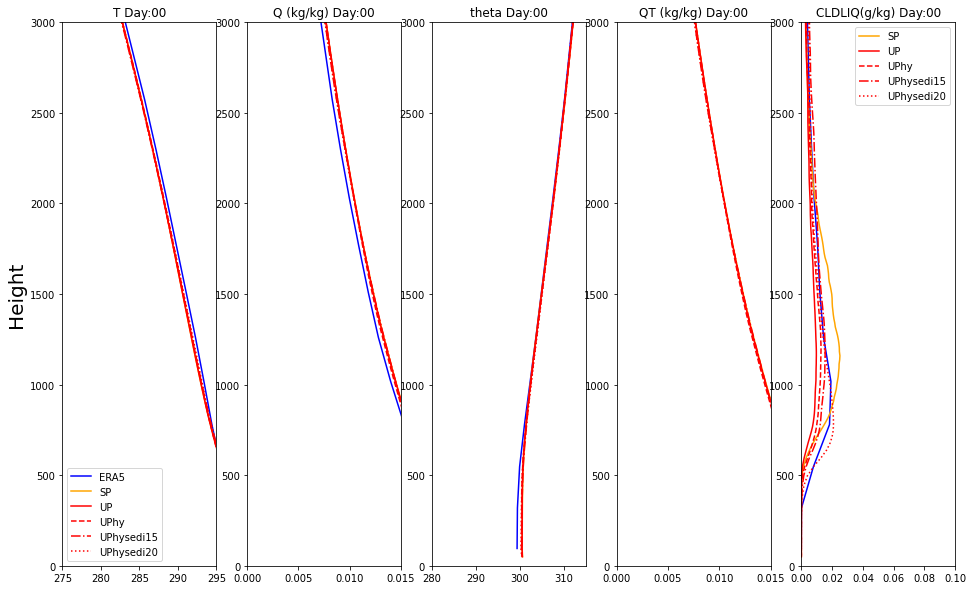

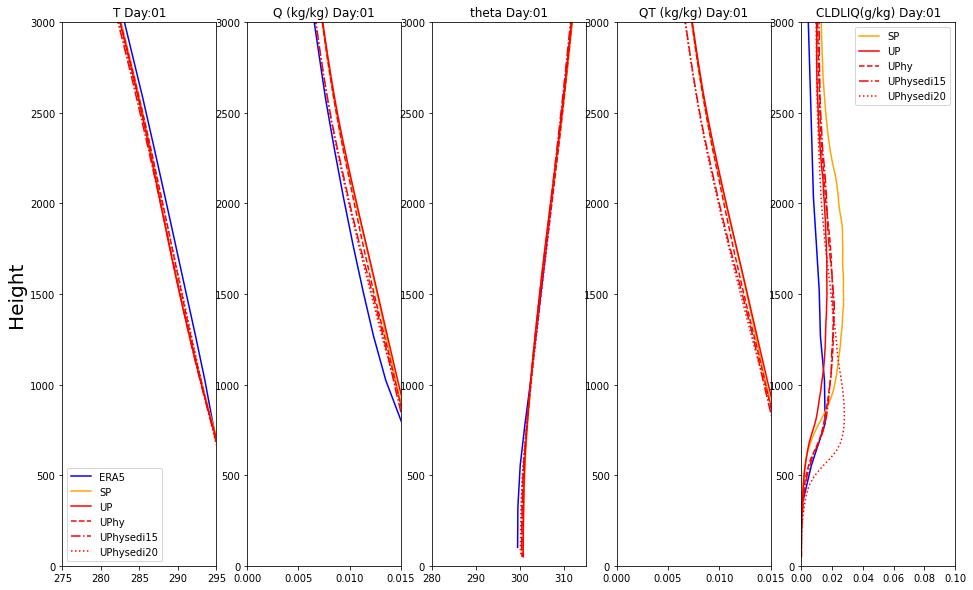

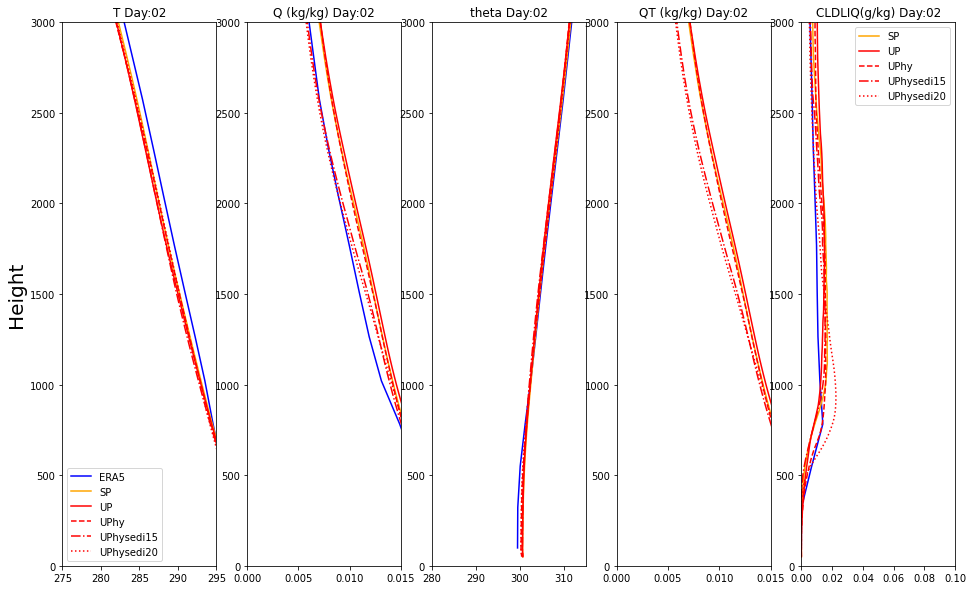

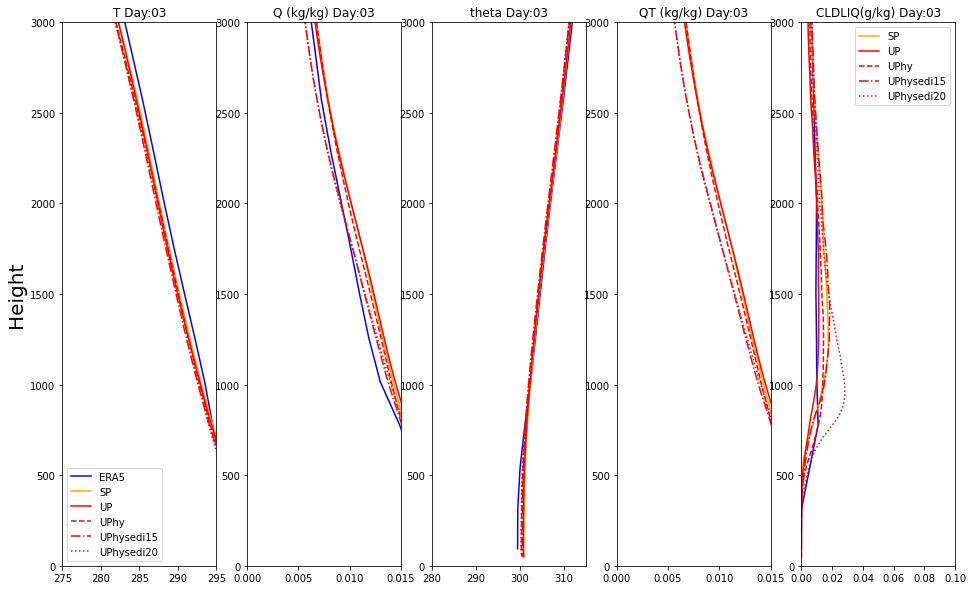

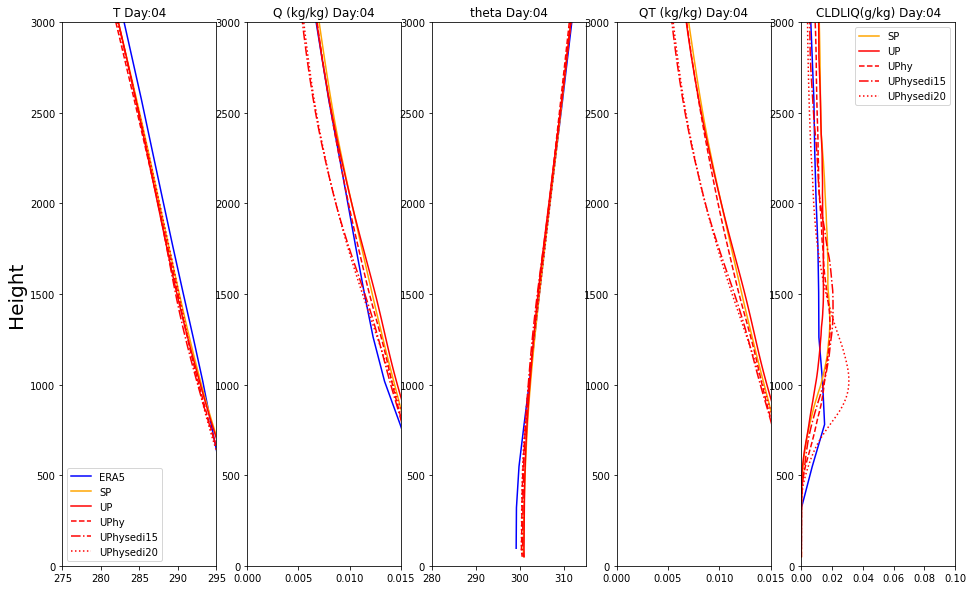

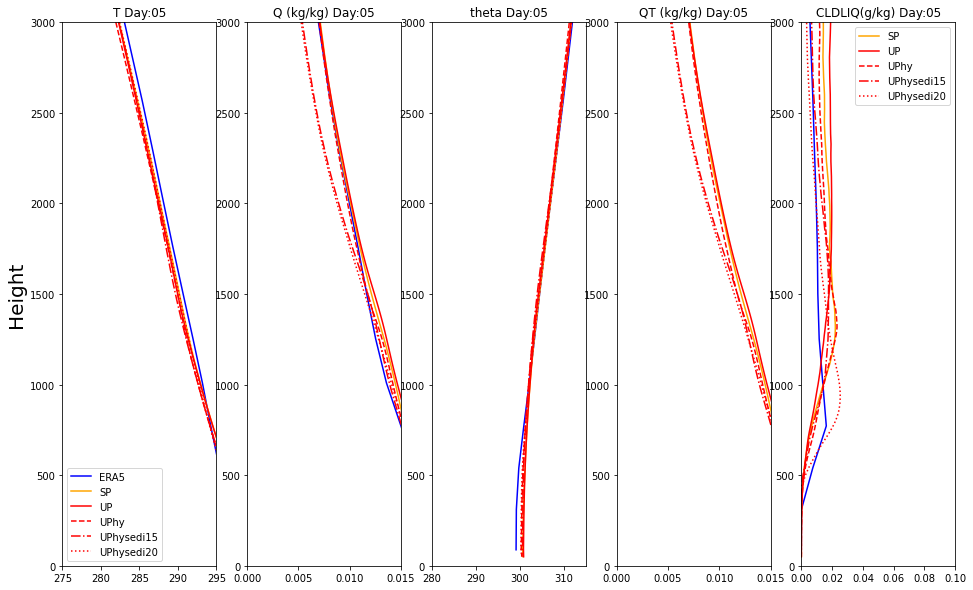

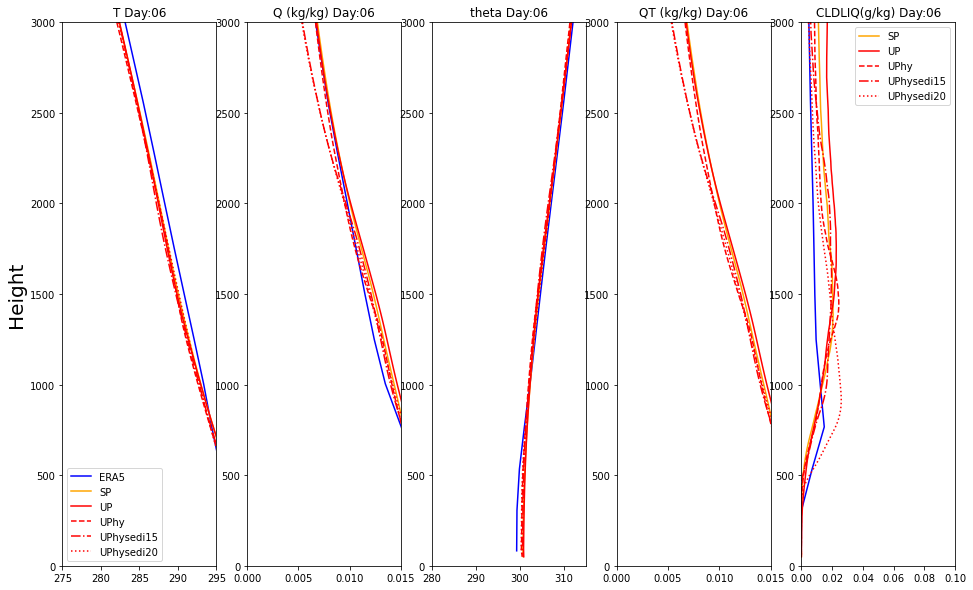

In [48]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Warm_dm = np.zeros([16])
    q_crossERA5Warm_dm = np.zeros([16])
    z_crossERA5Warm_dm = np.zeros([16])
    theta_crossERA5Warm_dm = np.zeros([16])
    lw_crossERA5Warm_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Warm_dm[:] = T_crossERA5Warm_dm[:] + ERA5_tWarm[(countday+24*iday),:]
        q_crossERA5Warm_dm[:] = q_crossERA5Warm_dm[:] + ERA5_qWarm[(countday+24*iday),:]
        z_crossERA5Warm_dm[:] = z_crossERA5Warm_dm[:] + ERA5_zWarm[(countday+24*iday),:]
        lw_crossERA5Warm_dm[:] = lw_crossERA5Warm_dm[:] + ERA5_lwWarm[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Warm_dm[izz] = potential_temperature(T_crossERA5Warm_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Warm_dm[:] = T_crossERA5Warm_dm[:]/(countday)
    q_crossERA5Warm_dm[:] = q_crossERA5Warm_dm[:]/(countday)
    z_crossERA5Warm_dm[:] = z_crossERA5Warm_dm[:]/(countday)
    theta_crossERA5Warm_dm[:] = theta_crossERA5Warm_dm[:]/(countday)
    lw_crossERA5Warm_dm[:] = lw_crossERA5Warm_dm[:]/(countday)
    T_crossSPWarm_dm = np.zeros([125])
    T_crossUPWarm_dm = np.zeros([125])
    T_crossUPhyWarm_dm = np.zeros([125])
    T_crossUPhysedi15Warm_dm = np.zeros([125])
    T_crossUPhysedi20Warm_dm = np.zeros([125])
    Q_crossSPWarm_dm = np.zeros([125])
    Q_crossUPWarm_dm = np.zeros([125])
    Q_crossUPhyWarm_dm = np.zeros([125])
    Q_crossUPhysedi15Warm_dm = np.zeros([125])
    Q_crossUPhysedi20Warm_dm = np.zeros([125])
    CLDICE_crossSPWarm_dm = np.zeros([125])
    CLDICE_crossUPWarm_dm = np.zeros([125])
    CLDICE_crossUPhyWarm_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Warm_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Warm_dm = np.zeros([125])
    CLDLIQ_crossSPWarm_dm = np.zeros([125])
    CLDLIQ_crossUPWarm_dm = np.zeros([125])
    CLDLIQ_crossUPhyWarm_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Warm_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Warm_dm = np.zeros([125])
    Z3_crossSPWarm_dm = np.zeros([125])
    Z3_crossUPWarm_dm = np.zeros([125])
    Z3_crossUPhyWarm_dm = np.zeros([125])
    Z3_crossUPhysedi15Warm_dm = np.zeros([125])
    Z3_crossUPhysedi20Warm_dm = np.zeros([125])
    theta_crossSPWarm_dm = np.zeros([125])
    theta_crossUPWarm_dm = np.zeros([125])
    theta_crossUPhyWarm_dm = np.zeros([125])
    theta_crossUPhysedi15Warm_dm = np.zeros([125])
    theta_crossUPhysedi20Warm_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPWarm_dm[:] = T_crossSPWarm_dm[:] + T_crossSPWarm[:,isec+144*iday]
        T_crossUPWarm_dm[:] = T_crossUPWarm_dm[:] + T_crossUPWarm[:,isec+144*iday]
        T_crossUPhyWarm_dm[:] = T_crossUPhyWarm_dm[:] + T_crossUPhyWarm[:,isec+144*iday]
        T_crossUPhysedi15Warm_dm[:] = T_crossUPhysedi15Warm_dm[:] + T_crossUPhysedi15Warm[:,isec+144*iday]
        T_crossUPhysedi20Warm_dm[:] = T_crossUPhysedi20Warm_dm[:] + T_crossUPhysedi20Warm[:,isec+144*iday]
        Q_crossSPWarm_dm[:] = Q_crossSPWarm_dm[:] + Q_crossSPWarm[:,isec+144*iday]
        Q_crossUPWarm_dm[:] = Q_crossUPWarm_dm[:] + Q_crossUPWarm[:,isec+144*iday]
        Q_crossUPhyWarm_dm[:] = Q_crossUPhyWarm_dm[:] + Q_crossUPhyWarm[:,isec+144*iday]
        Q_crossUPhysedi15Warm_dm[:] = Q_crossUPhysedi15Warm_dm[:] + Q_crossUPhysedi15Warm[:,isec+144*iday]
        Q_crossUPhysedi20Warm_dm[:] = Q_crossUPhysedi20Warm_dm[:] + Q_crossUPhysedi20Warm[:,isec+144*iday]
        CLDLIQ_crossSPWarm_dm[:] = CLDLIQ_crossSPWarm_dm[:] + CLDLIQ_crossSPWarm[:,isec+144*iday]
        CLDLIQ_crossUPWarm_dm[:] = CLDLIQ_crossUPWarm_dm[:] + CLDLIQ_crossUPWarm[:,isec+144*iday]
        CLDLIQ_crossUPhyWarm_dm[:] = CLDLIQ_crossUPhyWarm_dm[:] + CLDLIQ_crossUPhyWarm[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Warm_dm[:] = CLDLIQ_crossUPhysedi15Warm_dm[:] + CLDLIQ_crossUPhysedi15Warm[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Warm_dm[:] = CLDLIQ_crossUPhysedi20Warm_dm[:] + CLDLIQ_crossUPhysedi20Warm[:,isec+144*iday]
        CLDICE_crossSPWarm_dm[:] = CLDICE_crossSPWarm_dm[:] + CLDICE_crossSPWarm[:,isec+144*iday]
        CLDICE_crossUPWarm_dm[:] = CLDICE_crossUPWarm_dm[:] + CLDICE_crossUPWarm[:,isec+144*iday]
        CLDICE_crossUPhyWarm_dm[:] = CLDICE_crossUPhyWarm_dm[:] + CLDICE_crossUPhyWarm[:,isec+144*iday]
        CLDICE_crossUPhysedi15Warm_dm[:] = CLDICE_crossUPhysedi15Warm_dm[:] + CLDICE_crossUPhysedi15Warm[:,isec+144*iday]
        CLDICE_crossUPhysedi20Warm_dm[:] = CLDICE_crossUPhysedi20Warm_dm[:] + CLDICE_crossUPhysedi20Warm[:,isec+144*iday]
        Z3_crossSPWarm_dm[:] = Z3_crossSPWarm_dm[:] + Z3_crossSPWarm[:,isec+144*iday]
        Z3_crossUPWarm_dm[:] = Z3_crossUPWarm_dm[:] + Z3_crossUPWarm[:,isec+144*iday]
        Z3_crossUPhyWarm_dm[:] = Z3_crossUPhyWarm_dm[:] + Z3_crossUPhyWarm[:,isec+144*iday]
        Z3_crossUPhysedi15Warm_dm[:] = Z3_crossUPhysedi15Warm_dm[:] + Z3_crossUPhysedi15Warm[:,isec+144*iday]
        Z3_crossUPhysedi20Warm_dm[:] = Z3_crossUPhysedi20Warm_dm[:] + Z3_crossUPhysedi20Warm[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPWarm_dm[izz] = theta_crossSPWarm_dm[izz] + potential_temperature(T_crossSPWarm[izz,isec+144*iday],P_crossSPWarm[izz,isec+144*iday]*100)
            #theta_crossUPWarm_dm[izz] = theta_crossUPWarm_dm[izz] + potential_temperature(T_crossUPWarm[izz,isec+144*iday],P_crossUPWarm[izz,isec+144*iday]*100)
            #theta_crossUPhyWarm_dm[izz] = theta_crossUPhyWarm_dm[izz] + potential_temperature(T_crossUPhyWarm[izz,isec+144*iday],P_crossUPhyWarm[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Warm_dm[izz] = theta_crossUPhysedi15Warm_dm[izz] + potential_temperature(T_crossUPhysedi15Warm[izz,isec+144*iday],P_crossUPhysedi15Warm[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Warm_dm[izz] = theta_crossUPhysedi20Warm_dm[izz] + potential_temperature(T_crossUPhysedi20Warm[izz,isec+144*iday],P_crossUPhysedi20Warm[izz,isec+144*iday]*100)
            theta_crossSPWarm_dm[izz] = theta_crossSPWarm_dm[izz] + potential_temperature(T_crossSPWarm[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPWarm_dm[izz] = theta_crossUPWarm_dm[izz] + potential_temperature(T_crossUPWarm[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyWarm_dm[izz] = theta_crossUPhyWarm_dm[izz] + potential_temperature(T_crossUPhyWarm[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Warm_dm[izz] = theta_crossUPhysedi15Warm_dm[izz] + potential_temperature(T_crossUPhysedi15Warm[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Warm_dm[izz] = theta_crossUPhysedi20Warm_dm[izz] + potential_temperature(T_crossUPhysedi20Warm[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPWarm_dm = T_crossSPWarm_dm/(countsec)
    T_crossUPWarm_dm = T_crossUPWarm_dm/(countsec)
    T_crossUPhyWarm_dm = T_crossUPhyWarm_dm/(countsec)
    T_crossUPhysedi15Warm_dm = T_crossUPhysedi15Warm_dm/(countsec)
    T_crossUPhysedi20Warm_dm = T_crossUPhysedi20Warm_dm/(countsec)
    Q_crossSPWarm_dm = Q_crossSPWarm_dm/(countsec)
    Q_crossUPWarm_dm = Q_crossUPWarm_dm/(countsec)
    Q_crossUPhyWarm_dm = Q_crossUPhyWarm_dm/(countsec)
    Q_crossUPhysedi15Warm_dm = Q_crossUPhysedi15Warm_dm/(countsec)
    Q_crossUPhysedi20Warm_dm = Q_crossUPhysedi20Warm_dm/(countsec)  
    CLDICE_crossSPWarm_dm = CLDICE_crossSPWarm_dm/(countsec)
    CLDICE_crossUPWarm_dm = CLDICE_crossUPWarm_dm/(countsec)
    CLDICE_crossUPhyWarm_dm = CLDICE_crossUPhyWarm_dm/(countsec)
    CLDICE_crossUPhysedi15Warm_dm = CLDICE_crossUPhysedi15Warm_dm/(countsec)
    CLDICE_crossUPhysedi20Warm_dm = CLDICE_crossUPhysedi20Warm_dm/(countsec)  
    CLDLIQ_crossSPWarm_dm = CLDLIQ_crossSPWarm_dm/(countsec)
    CLDLIQ_crossUPWarm_dm = CLDLIQ_crossUPWarm_dm/(countsec)
    CLDLIQ_crossUPhyWarm_dm = CLDLIQ_crossUPhyWarm_dm/(countsec)
    CLDLIQ_crossUPhysedi15Warm_dm = CLDLIQ_crossUPhysedi15Warm_dm/(countsec)
    CLDLIQ_crossUPhysedi20Warm_dm = CLDLIQ_crossUPhysedi20Warm_dm/(countsec)  
    Z3_crossSPWarm_dm = Z3_crossSPWarm_dm/(countsec)
    Z3_crossUPWarm_dm = Z3_crossUPWarm_dm/(countsec)
    Z3_crossUPhyWarm_dm = Z3_crossUPhyWarm_dm/(countsec)
    Z3_crossUPhysedi15Warm_dm = Z3_crossUPhysedi15Warm_dm/(countsec)
    Z3_crossUPhysedi20Warm_dm = Z3_crossUPhysedi20Warm_dm/(countsec) 
    theta_crossSPWarm_dm = theta_crossSPWarm_dm/(countsec)
    theta_crossUPWarm_dm = theta_crossUPWarm_dm/(countsec)
    theta_crossUPhyWarm_dm = theta_crossUPhyWarm_dm/(countsec)
    theta_crossUPhysedi15Warm_dm = theta_crossUPhysedi15Warm_dm/(countsec)
    theta_crossUPhysedi20Warm_dm = theta_crossUPhysedi20Warm_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Warm_dm,z_crossERA5Warm_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPWarm_dm,Z3_crossSPWarm_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPWarm_dm,Z3_crossUPWarm_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyWarm_dm,Z3_crossUPhyWarm_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Warm_dm,Z3_crossUPhysedi15Warm_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Warm_dm,Z3_crossUPhysedi20Warm_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Warm_dm,z_crossERA5Warm_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPWarm_dm,Z3_crossSPWarm_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPWarm_dm,Z3_crossUPWarm_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyWarm_dm,Z3_crossUPhyWarm_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Warm_dm,Z3_crossUPhysedi15Warm_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Warm_dm,Z3_crossUPhysedi20Warm_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Warm_dm,z_crossERA5Warm_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPWarm_dm,Z3_crossSPWarm_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPWarm_dm,Z3_crossUPWarm_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyWarm_dm,Z3_crossUPhyWarm_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Warm_dm,Z3_crossUPhysedi15Warm_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Warm_dm,Z3_crossUPhysedi20Warm_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPWarm_dm = Q_crossSPWarm_dm+CLDICE_crossSPWarm_dm+CLDLIQ_crossSPWarm_dm
    QT_crossUPWarm_dm = Q_crossUPWarm_dm+CLDICE_crossUPWarm_dm+CLDLIQ_crossUPWarm_dm
    QT_crossUPhyWarm_dm = Q_crossUPhyWarm_dm+CLDICE_crossUPhyWarm_dm+CLDLIQ_crossUPhyWarm_dm
    QT_crossUPhysedi15Warm_dm = Q_crossUPhysedi15Warm_dm+CLDICE_crossUPhysedi15Warm_dm+CLDLIQ_crossUPhysedi15Warm_dm
    QT_crossUPhysedi20Warm_dm = Q_crossUPhysedi20Warm_dm+CLDICE_crossUPhysedi20Warm_dm+CLDLIQ_crossUPhysedi20Warm_dm
    cf42 = ax4.plot(QT_crossSPWarm_dm,Z3_crossSPWarm_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPWarm_dm,Z3_crossUPWarm_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyWarm_dm,Z3_crossUPhyWarm_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Warm_dm,Z3_crossUPhysedi15Warm_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Warm_dm,Z3_crossUPhysedi20Warm_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Warm_dm,z_crossERA5Warm_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPWarm_dm,Z3_crossSPWarm_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPWarm_dm,Z3_crossUPWarm_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyWarm_dm,Z3_crossUPhyWarm_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Warm_dm,Z3_crossUPhysedi15Warm_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Warm_dm,Z3_crossUPhysedi20Warm_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Warm_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

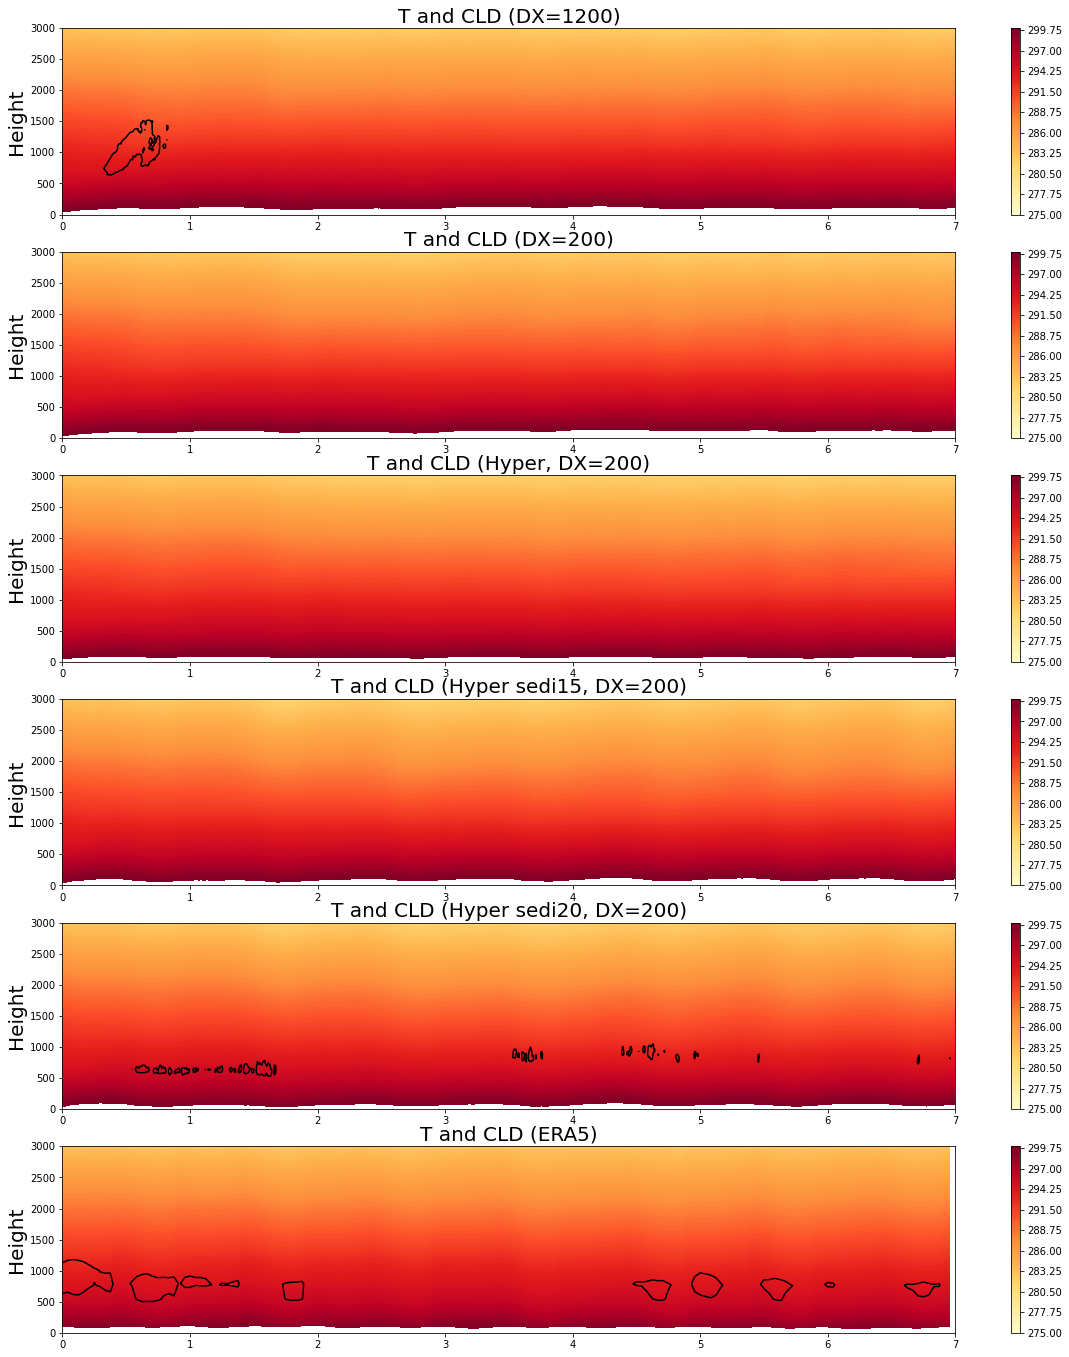

In [60]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [300]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPWarm,T_crossSPWarm,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPWarm,cld_crossSPWarm,200,colors='k', levels=[0.1], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPWarm,T_crossUPWarm,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPWarm,cld_crossUPWarm,200,colors='k', levels=[0.1], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyWarm,T_crossUPhyWarm,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='k', levels=[0.1], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Warm,T_crossUPhysedi15Warm,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Warm,cld_crossUPhysedi15Warm,200,colors='k', levels=[0.1], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Warm,T_crossUPhysedi20Warm,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Warm,cld_crossUPhysedi20Warm,200,colors='k', levels=[0.1], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zWarm/9.8,ERA5_tWarm,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zWarm/9.8,ERA5_ccWarm,200,colors='k', levels=[0.1], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Warm_Time_Height_Model_ERA5.png')

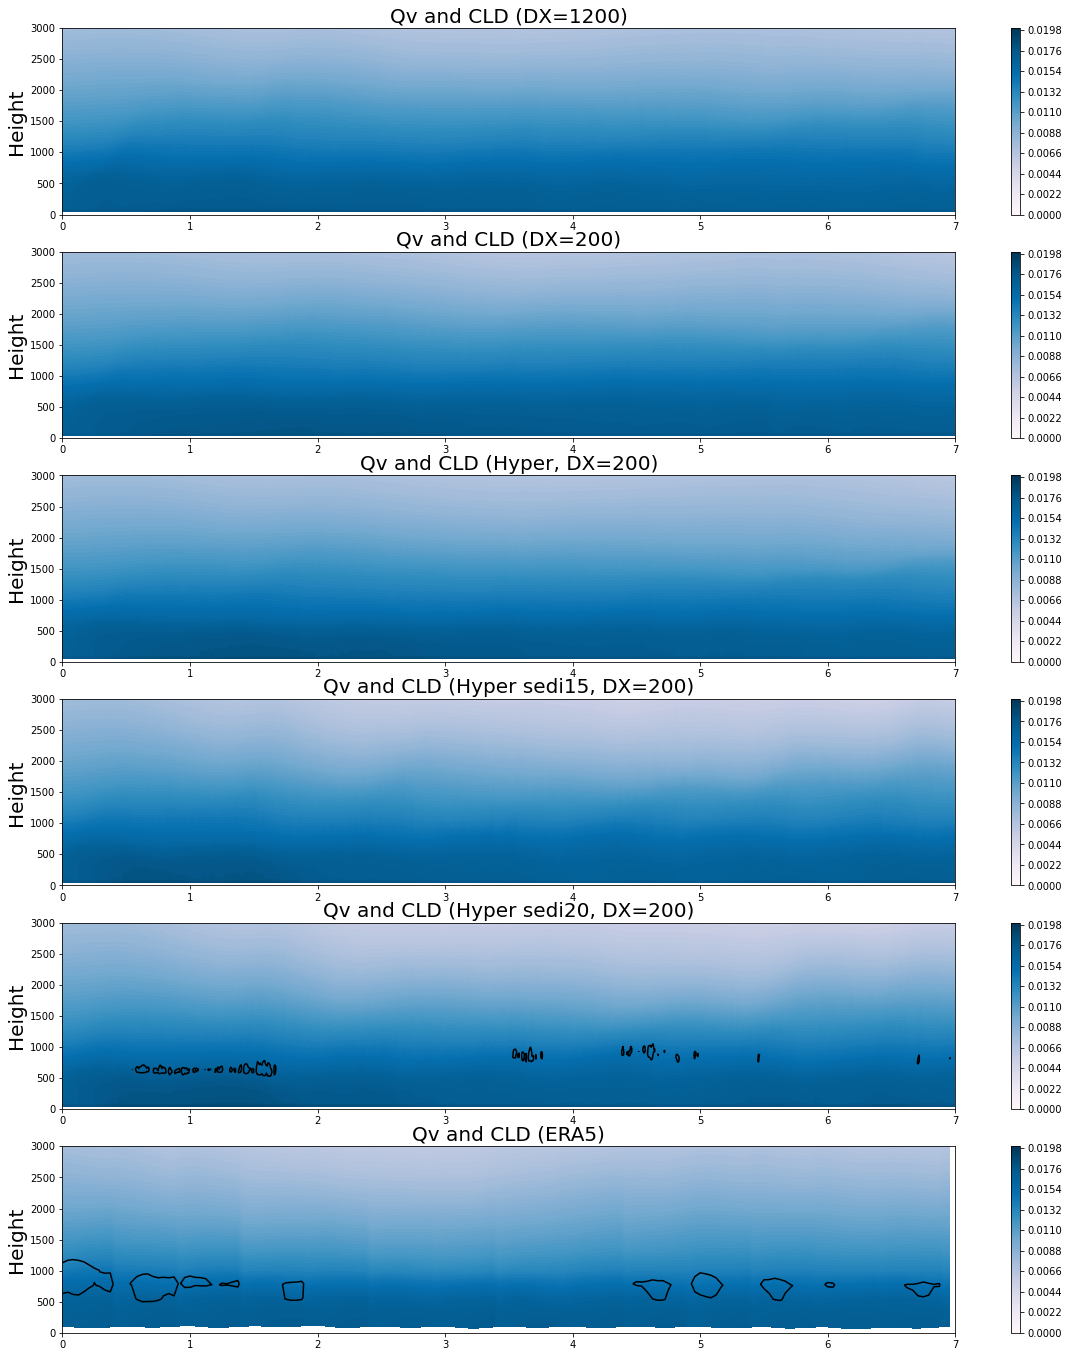

In [59]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.02]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPWarm,Q_crossSPWarm,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPWarm,cld_crossSPWarm,200,colors='k', levels=[0.2], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPWarm,Q_crossUPWarm,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPWarm,cld_crossUPWarm,200,colors='k', levels=[0.1], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyWarm,Q_crossUPhyWarm,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='k', levels=[0.1], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Warm,Q_crossUPhysedi15Warm,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Warm,cld_crossUPhysedi15Warm,200,colors='k', levels=[0.1], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Warm,Q_crossUPhysedi20Warm,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Warm,cld_crossUPhysedi20Warm,200,colors='k', levels=[0.1], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zWarm/9.8,ERA5_qWarm,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zWarm/9.8,ERA5_ccWarm,200,colors='k', levels=[0.1], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyWarm,cld_crossUPhyWarm,200,colors='b', levels=[0.1], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Warm_Time_HeighQv_Model_ERA5.png')

# Hawaii

In [51]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
spww_SPHawaii = np.zeros([1009,125])
spww_UPHawaii = np.zeros([1009,125])
spww_UPhyHawaii = np.zeros([1009,125])
spww_UPhysedi20Hawaii = np.zeros([1009,125])
spww_UPhysedi15Hawaii = np.zeros([1009,125])
Z3_SPHawaii = np.zeros([1009,125])
Z3_UPHawaii = np.zeros([1009,125])
Z3_UPhyHawaii = np.zeros([1009,125])
Z3_UPhysedi20Hawaii = np.zeros([1009,125])
Z3_UPhysedi15Hawaii = np.zeros([1009,125])
pttend_SPHawaii = np.zeros([1009,125])
pttend_UPHawaii = np.zeros([1009,125])
pttend_UPhyHawaii = np.zeros([1009,125])
pttend_UPhysedi20Hawaii = np.zeros([1009,125])
pttend_UPhysedi15Hawaii = np.zeros([1009,125])
cld_SPHawaii = np.zeros([1009,125])
cld_UPHawaii = np.zeros([1009,125])
cld_UPhyHawaii = np.zeros([1009,125])
cld_UPhysedi20Hawaii = np.zeros([1009,125])
cld_UPhysedi15Hawaii = np.zeros([1009,125])
T_SPHawaii = np.zeros([1009,125])
T_UPHawaii = np.zeros([1009,125])
T_UPhyHawaii = np.zeros([1009,125])
T_UPhysedi20Hawaii = np.zeros([1009,125])
T_UPhysedi15Hawaii = np.zeros([1009,125])
CLDLIQ_SPHawaii = np.zeros([1009,125])
CLDLIQ_UPHawaii = np.zeros([1009,125])
CLDLIQ_UPhyHawaii = np.zeros([1009,125])
CLDLIQ_UPhysedi20Hawaii = np.zeros([1009,125])
CLDLIQ_UPhysedi15Hawaii = np.zeros([1009,125])
CLDICE_SPHawaii = np.zeros([1009,125])
CLDICE_UPHawaii = np.zeros([1009,125])
CLDICE_UPhyHawaii = np.zeros([1009,125])
CLDICE_UPhysedi20Hawaii = np.zeros([1009,125])
CLDICE_UPhysedi15Hawaii = np.zeros([1009,125])
Q_SPHawaii = np.zeros([1009,125])
Q_UPHawaii = np.zeros([1009,125])
Q_UPhyHawaii = np.zeros([1009,125])
Q_UPhysedi20Hawaii = np.zeros([1009,125])
Q_UPhysedi15Hawaii = np.zeros([1009,125])
P_SPHawaii = np.zeros([1009,125])
P_UPHawaii = np.zeros([1009,125])
P_UPhyHawaii = np.zeros([1009,125])
P_UPhysedi20Hawaii = np.zeros([1009,125])
P_UPhysedi15Hawaii = np.zeros([1009,125])
for it in range(1009):
    count = 0
    for il in range(len(ind_Hawaii)):
        spww_SPHawaii[it,:] = spww_SPHawaii[it,:] + SPWWSP[it,:,ind_Hawaii[il]]
        spww_UPHawaii[it,:] = spww_UPHawaii[it,:] + SPWWUP[it,:,ind_Hawaii[il]]
        spww_UPhyHawaii[it,:] = spww_UPhyHawaii[it,:] + SPWWUPhy[it,:,ind_Hawaii[il]]
        spww_UPhysedi15Hawaii[it,:] = spww_UPhysedi15Hawaii[it,:] + SPWWUPhysedi15[it,:,ind_Hawaii[il]]
        spww_UPhysedi20Hawaii[it,:] = spww_UPhysedi20Hawaii[it,:] + SPWWUPhysedi20[it,:,ind_Hawaii[il]]
        Z3_SPHawaii[it,:] = Z3_SPHawaii[it,:] + Z3SP[it,:,ind_Hawaii[il]]
        Z3_UPHawaii[it,:] = Z3_UPHawaii[it,:] + Z3UP[it,:,ind_Hawaii[il]]
        Z3_UPhyHawaii[it,:] = Z3_UPhyHawaii[it,:] + Z3UPhy[it,:,ind_Hawaii[il]]
        Z3_UPhysedi15Hawaii[it,:] = Z3_UPhysedi15Hawaii[it,:] + Z3UPhysedi15[it,:,ind_Hawaii[il]]
        Z3_UPhysedi20Hawaii[it,:] = Z3_UPhysedi20Hawaii[it,:] + Z3UPhysedi20[it,:,ind_Hawaii[il]]
        T_SPHawaii[it,:] = T_SPHawaii[it,:] + T_SP[it,:,ind_Hawaii[il]]
        T_UPHawaii[it,:] = T_UPHawaii[it,:] + T_UP[it,:,ind_Hawaii[il]]
        T_UPhyHawaii[it,:] = T_UPhyHawaii[it,:] + T_UPhy[it,:,ind_Hawaii[il]]
        T_UPhysedi15Hawaii[it,:] = T_UPhysedi15Hawaii[it,:] + T_UPhysedi15[it,:,ind_Hawaii[il]]
        T_UPhysedi20Hawaii[it,:] = T_UPhysedi20Hawaii[it,:] + T_UPhysedi20[it,:,ind_Hawaii[il]]
        CLDICE_SPHawaii[it,:] = CLDICE_SPHawaii[it,:] + CLDICE_SP[it,:,ind_Hawaii[il]]
        CLDICE_UPHawaii[it,:] = CLDICE_UPHawaii[it,:] + CLDICE_UP[it,:,ind_Hawaii[il]]
        CLDICE_UPhyHawaii[it,:] = CLDICE_UPhyHawaii[it,:] + CLDICE_UPhy[it,:,ind_Hawaii[il]]
        CLDICE_UPhysedi15Hawaii[it,:] = CLDICE_UPhysedi15Hawaii[it,:] + CLDICE_UPhysedi15[it,:,ind_Hawaii[il]]
        CLDICE_UPhysedi20Hawaii[it,:] = CLDICE_UPhysedi20Hawaii[it,:] + CLDICE_UPhysedi20[it,:,ind_Hawaii[il]]
        CLDLIQ_SPHawaii[it,:] = CLDLIQ_SPHawaii[it,:] + CLDLIQ_SP[it,:,ind_Hawaii[il]]
        CLDLIQ_UPHawaii[it,:] = CLDLIQ_UPHawaii[it,:] + CLDLIQ_UP[it,:,ind_Hawaii[il]]
        CLDLIQ_UPhyHawaii[it,:] = CLDLIQ_UPhyHawaii[it,:] + CLDLIQ_UPhy[it,:,ind_Hawaii[il]]
        CLDLIQ_UPhysedi15Hawaii[it,:] = CLDLIQ_UPhysedi15Hawaii[it,:] + CLDLIQ_UPhysedi15[it,:,ind_Hawaii[il]]
        CLDLIQ_UPhysedi20Hawaii[it,:] = CLDLIQ_UPhysedi20Hawaii[it,:] + CLDLIQ_UPhysedi20[it,:,ind_Hawaii[il]]
        Q_SPHawaii[it,:] = Q_SPHawaii[it,:] + Q_SP[it,:,ind_Hawaii[il]]
        Q_UPHawaii[it,:] = Q_UPHawaii[it,:] + Q_UP[it,:,ind_Hawaii[il]]
        Q_UPhyHawaii[it,:] = Q_UPhyHawaii[it,:] + Q_UPhy[it,:,ind_Hawaii[il]]
        Q_UPhysedi15Hawaii[it,:] = Q_UPhysedi15Hawaii[it,:] + Q_UPhysedi15[it,:,ind_Hawaii[il]]
        Q_UPhysedi20Hawaii[it,:] = Q_UPhysedi20Hawaii[it,:] + Q_UPhysedi20[it,:,ind_Hawaii[il]]
        pttend_SPHawaii[it,:] = pttend_SPHawaii[it,:] + PTTEND_SP[it,:,ind_Hawaii[il]]
        pttend_UPHawaii[it,:] = pttend_UPHawaii[it,:] + PTTEND_UP[it,:,ind_Hawaii[il]]
        pttend_UPhyHawaii[it,:] = pttend_UPhyHawaii[it,:] + PTTEND_UPhy[it,:,ind_Hawaii[il]]
        pttend_UPhysedi15Hawaii[it,:] = pttend_UPhysedi15Hawaii[it,:] + PTTEND_UPhysedi15[it,:,ind_Hawaii[il]]
        pttend_UPhysedi20Hawaii[it,:] = pttend_UPhysedi20Hawaii[it,:] + PTTEND_UPhysedi20[it,:,ind_Hawaii[il]]
        cld_SPHawaii[it,:] = cld_SPHawaii[it,:] + CLOUD_SP[it,:,ind_Hawaii[il]]
        cld_UPHawaii[it,:] = cld_UPHawaii[it,:] + CLOUD_UP[it,:,ind_Hawaii[il]]
        cld_UPhyHawaii[it,:] = cld_UPhyHawaii[it,:] + CLOUD_UPhy[it,:,ind_Hawaii[il]]
        cld_UPhysedi15Hawaii[it,:] = cld_UPhysedi15Hawaii[it,:] + CLOUD_UPhysedi15[it,:,ind_Hawaii[il]]
        cld_UPhysedi20Hawaii[it,:] = cld_UPhysedi20Hawaii[it,:] + CLOUD_UPhysedi20[it,:,ind_Hawaii[il]]
        P_SPHawaii[it,:] = hyam_SP[it,:]*P0_SP[it]+hybm_SP[it,:]*PS_SP[it,il]
        P_UPHawaii[it,:] = hyam_UP[it,:]*P0_UP[it]+hybm_UP[it,:]*PS_UP[it,il]
        P_UPhyHawaii[it,:] = hyam_UPhy[it,:]*P0_UPhy[it]+hybm_UPhy[it,:]*PS_UPhy[it,il]
        P_UPhysedi15Hawaii[it,:] = hyam_UPhysedi15[it,:]*P0_UPhysedi15[it]+hybm_UPhysedi15[it,:]*PS_UPhysedi15[it,il]
        P_UPhysedi20Hawaii[it,:] = hyam_UPhysedi20[it,:]*P0_UPhysedi20[it]+hybm_UPhysedi20[it,:]*PS_UPhysedi20[it,il]
        count = count + 1
            
    spww_SPHawaii[it,:] = spww_SPHawaii[it,:] /count
    spww_UPHawaii[it,:] = spww_UPHawaii[it,:]  /count
    spww_UPhyHawaii[it,:] = spww_UPhyHawaii[it,:] /count
    spww_UPhysedi15Hawaii[it,:] = spww_UPhysedi15Hawaii[it,:] /count
    spww_UPhysedi20Hawaii[it,:] = spww_UPhysedi20Hawaii[it,:] /count
    Z3_SPHawaii[it,:] = Z3_SPHawaii[it,:] /count
    Z3_UPHawaii[it,:] = Z3_UPHawaii[it,:]  /count
    Z3_UPhyHawaii[it,:] = Z3_UPhyHawaii[it,:] /count
    Z3_UPhysedi15Hawaii[it,:] = Z3_UPhysedi15Hawaii[it,:] /count
    Z3_UPhysedi20Hawaii[it,:] = Z3_UPhysedi20Hawaii[it,:] /count
    T_SPHawaii[it,:] = T_SPHawaii[it,:] /count
    T_UPHawaii[it,:] = T_UPHawaii[it,:]  /count
    T_UPhyHawaii[it,:] = T_UPhyHawaii[it,:] /count
    T_UPhysedi15Hawaii[it,:] = T_UPhysedi15Hawaii[it,:] /count
    T_UPhysedi20Hawaii[it,:] = T_UPhysedi20Hawaii[it,:] /count
    CLDICE_SPHawaii[it,:] = CLDICE_SPHawaii[it,:] /count
    CLDICE_UPHawaii[it,:] = CLDICE_UPHawaii[it,:]  /count
    CLDICE_UPhyHawaii[it,:] = CLDICE_UPhyHawaii[it,:] /count
    CLDICE_UPhysedi15Hawaii[it,:] = CLDICE_UPhysedi15Hawaii[it,:] /count
    CLDICE_UPhysedi20Hawaii[it,:] = CLDICE_UPhysedi20Hawaii[it,:] /count
    CLDLIQ_SPHawaii[it,:] = CLDLIQ_SPHawaii[it,:] /count
    CLDLIQ_UPHawaii[it,:] = CLDLIQ_UPHawaii[it,:]  /count
    CLDLIQ_UPhyHawaii[it,:] = CLDLIQ_UPhyHawaii[it,:] /count
    CLDLIQ_UPhysedi15Hawaii[it,:] = CLDLIQ_UPhysedi15Hawaii[it,:] /count
    CLDLIQ_UPhysedi20Hawaii[it,:] = CLDLIQ_UPhysedi20Hawaii[it,:] /count
    Q_SPHawaii[it,:] = Q_SPHawaii[it,:] /count
    Q_UPHawaii[it,:] = Q_UPHawaii[it,:]  /count
    Q_UPhyHawaii[it,:] = Q_UPhyHawaii[it,:] /count
    Q_UPhysedi15Hawaii[it,:] = Q_UPhysedi15Hawaii[it,:] /count
    Q_UPhysedi20Hawaii[it,:] = Q_UPhysedi20Hawaii[it,:] /count
    pttend_SPHawaii[it,:] = pttend_SPHawaii[it,:] /count
    pttend_UPHawaii[it,:] = pttend_UPHawaii[it,:]  /count
    pttend_UPhyHawaii[it,:] = pttend_UPhyHawaii[it,:] /count
    pttend_UPhysedi15Hawaii[it,:] = pttend_UPhysedi15Hawaii[it,:] /count
    pttend_UPhysedi20Hawaii[it,:] = pttend_UPhysedi20Hawaii[it,:] /count
    cld_SPHawaii[it,:] = cld_SPHawaii[it,:] /count
    cld_UPHawaii[it,:] = cld_UPHawaii[it,:]  /count
    cld_UPhyHawaii[it,:] = cld_UPhyHawaii[it,:] /count
    cld_UPhysedi15Hawaii[it,:] = cld_UPhysedi15Hawaii[it,:] /count
    cld_UPhysedi20Hawaii[it,:] = cld_UPhysedi20Hawaii[it,:] /count
    P_SPHawaii[it,:] = P_SPHawaii[it,:] /count
    P_UPHawaii[it,:] = P_UPHawaii[it,:]  /count
    P_UPhyHawaii[it,:] = P_UPhyHawaii[it,:] /count
    P_UPhysedi15Hawaii[it,:] = P_UPhysedi15Hawaii[it,:] /count
    P_UPhysedi20Hawaii[it,:] = P_UPhysedi20Hawaii[it,:] /count
    
spww_crossSPHawaii = np.transpose(spww_SPHawaii)
spww_crossUPHawaii = np.transpose(spww_UPHawaii)
spww_crossUPhyHawaii = np.transpose(spww_UPhyHawaii)
spww_crossUPhysedi15Hawaii = np.transpose(spww_UPhysedi15Hawaii)
spww_crossUPhysedi20Hawaii = np.transpose(spww_UPhysedi20Hawaii)
Z3_crossSPHawaii = np.transpose(Z3_SPHawaii)
Z3_crossUPHawaii = np.transpose(Z3_UPHawaii)
Z3_crossUPhyHawaii = np.transpose(Z3_UPhyHawaii)
Z3_crossUPhysedi15Hawaii = np.transpose(Z3_UPhysedi15Hawaii)
Z3_crossUPhysedi20Hawaii = np.transpose(Z3_UPhysedi20Hawaii)
T_crossSPHawaii = np.transpose(T_SPHawaii)
T_crossUPHawaii = np.transpose(T_UPHawaii)
T_crossUPhyHawaii = np.transpose(T_UPhyHawaii)
T_crossUPhysedi15Hawaii = np.transpose(T_UPhysedi15Hawaii)
T_crossUPhysedi20Hawaii = np.transpose(T_UPhysedi20Hawaii)
CLDICE_crossSPHawaii = np.transpose(CLDICE_SPHawaii)
CLDICE_crossUPHawaii = np.transpose(CLDICE_UPHawaii)
CLDICE_crossUPhyHawaii = np.transpose(CLDICE_UPhyHawaii)
CLDICE_crossUPhysedi15Hawaii = np.transpose(CLDICE_UPhysedi15Hawaii)
CLDICE_crossUPhysedi20Hawaii = np.transpose(CLDICE_UPhysedi20Hawaii)
CLDLIQ_crossSPHawaii = np.transpose(CLDLIQ_SPHawaii)
CLDLIQ_crossUPHawaii = np.transpose(CLDLIQ_UPHawaii)
CLDLIQ_crossUPhyHawaii = np.transpose(CLDLIQ_UPhyHawaii)
CLDLIQ_crossUPhysedi15Hawaii = np.transpose(CLDLIQ_UPhysedi15Hawaii)
CLDLIQ_crossUPhysedi20Hawaii = np.transpose(CLDLIQ_UPhysedi20Hawaii)
Q_crossSPHawaii = np.transpose(Q_SPHawaii)
Q_crossUPHawaii = np.transpose(Q_UPHawaii)
Q_crossUPhyHawaii = np.transpose(Q_UPhyHawaii)
Q_crossUPhysedi15Hawaii = np.transpose(Q_UPhysedi15Hawaii)
Q_crossUPhysedi20Hawaii = np.transpose(Q_UPhysedi20Hawaii)
pttend_crossSPHawaii = np.transpose(pttend_SPHawaii)
pttend_crossUPHawaii = np.transpose(pttend_UPHawaii)
pttend_crossUPhyHawaii = np.transpose(pttend_UPhyHawaii)
pttend_crossUPhysedi15Hawaii = np.transpose(pttend_UPhysedi15Hawaii)
pttend_crossUPhysedi20Hawaii = np.transpose(pttend_UPhysedi20Hawaii)
cld_crossSPHawaii = np.transpose(cld_SPHawaii)
cld_crossUPHawaii = np.transpose(cld_UPHawaii)
cld_crossUPhyHawaii = np.transpose(cld_UPhyHawaii)
cld_crossUPhysedi15Hawaii = np.transpose(cld_UPhysedi15Hawaii)
cld_crossUPhysedi20Hawaii = np.transpose(cld_UPhysedi20Hawaii)
P_crossSPHawaii = np.transpose(P_SPHawaii)
P_crossUPHawaii = np.transpose(P_UPHawaii)
P_crossUPhyHawaii = np.transpose(P_UPhyHawaii)
P_crossUPhysedi15Hawaii = np.transpose(P_UPhysedi15Hawaii)
P_crossUPhysedi20Hawaii = np.transpose(P_UPhysedi20Hawaii)

In [52]:
countt = 0
temp3d = np.zeros([16,721,1440])
temp3d2 = np.zeros([16,721,1440])
temp3d3 = np.zeros([16,721,1440])
temp3d4 = np.zeros([16,721,1440])
temp3d5 = np.zeros([16,721,1440])
temp = np.zeros([721,1440])
temp2 = np.zeros([721,1440])
temp3 = np.zeros([721,1440])
temp4 = np.zeros([721,1440])
temp5 = np.zeros([721,1440])
ERA5_tHawaii = np.zeros([24*7,16])
ERA5_qHawaii = np.zeros([24*7,16])
ERA5_zHawaii = np.zeros([24*7,16])
ERA5_ccHawaii = np.zeros([24*7,16])
ERA5_lwHawaii = np.zeros([24*7,16])
ERA_Time = np.zeros([24*7,16])
for iday in range(7):
    print(iday)
    for ihour in range(24):
        temp3d[:,:,:] = ERA5_thourly[countt,:,:]
        temp3d2[:,:,:] = ERA5_zhourly[countt,:,:]
        temp3d3[:,:,:] = ERA5_cchourly[countt,:,:]
        temp3d4[:,:,:] = ERA5_qhourly[countt,:,:]
        temp3d5[:,:,:] = ERA5_clwchourly[countt,:,:]
        for iz in range(16):
            temp[:,:] = temp3d[iz,:,:]
            temp2[:,:] = temp3d2[iz,:,:]
            temp3[:,:] = temp3d3[iz,:,:]
            temp4[:,:] = temp3d4[iz,:,:]
            temp5[:,:] = temp3d5[iz,:,:]
            temp1d = temp.flatten()
            temp1d2 = temp2.flatten()
            temp1d3 = temp3.flatten()
            temp1d4 = temp4.flatten()
            temp1d5 = temp5.flatten()
            counttt3 = 0
            for il in range(len(ind_Hawaii_ERA5)):
                ERA5_tHawaii[countt,iz] = ERA5_tHawaii[countt,iz] + temp1d[ind_Hawaii_ERA5[il]]
                ERA5_zHawaii[countt,iz] = ERA5_zHawaii[countt,iz] + temp1d2[ind_Hawaii_ERA5[il]]
                ERA5_ccHawaii[countt,iz] = ERA5_ccHawaii[countt,iz] + temp1d3[ind_Hawaii_ERA5[il]]
                ERA5_qHawaii[countt,iz] = ERA5_qHawaii[countt,iz] + temp1d4[ind_Hawaii_ERA5[il]]
                ERA5_lwHawaii[countt,iz] = ERA5_lwHawaii[countt,iz] + temp1d5[ind_Hawaii_ERA5[il]]
                counttt3 = counttt3 + 1        
            ERA5_tHawaii[countt,iz] = ERA5_tHawaii[countt,iz]/(counttt3)
            ERA5_zHawaii[countt,iz] = ERA5_zHawaii[countt,iz]/(counttt3)
            ERA5_ccHawaii[countt,iz] = ERA5_ccHawaii[countt,iz]/(counttt3)
            ERA5_qHawaii[countt,iz] = ERA5_qHawaii[countt,iz]/(counttt3)
            ERA5_lwHawaii[countt,iz] = ERA5_lwHawaii[countt,iz]/(counttt3)
            ERA_Time[countt,iz] = iday + ihour/24
        countt = countt+1

0
1
2
3
4
5
6


0
24
1
24
2
24
3
24
4
24
5
24
6
24


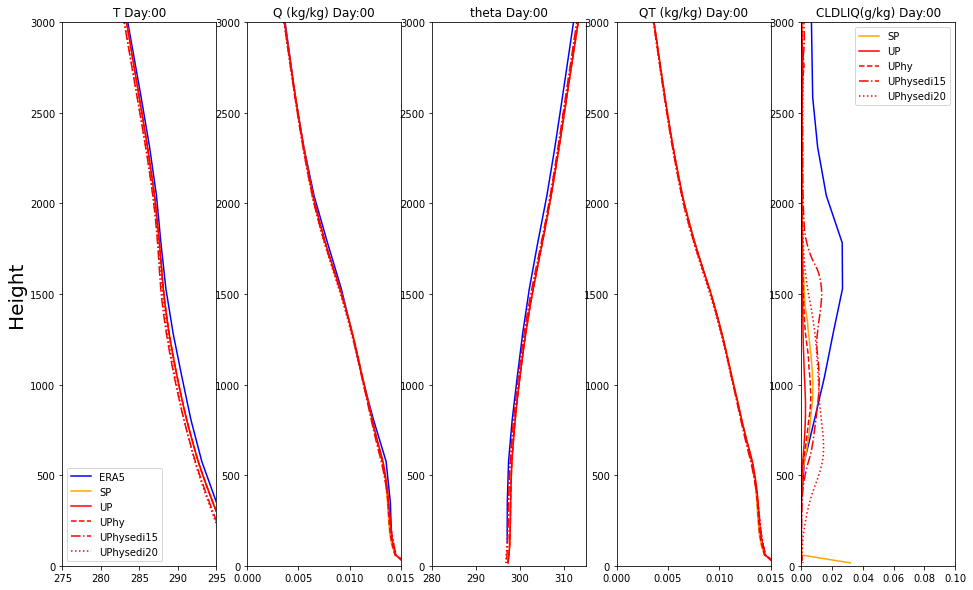

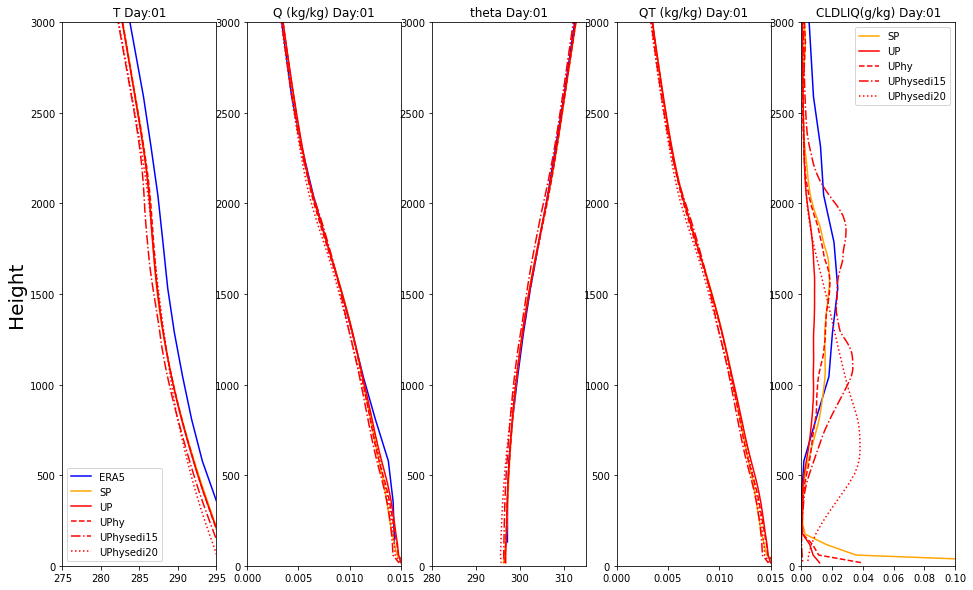

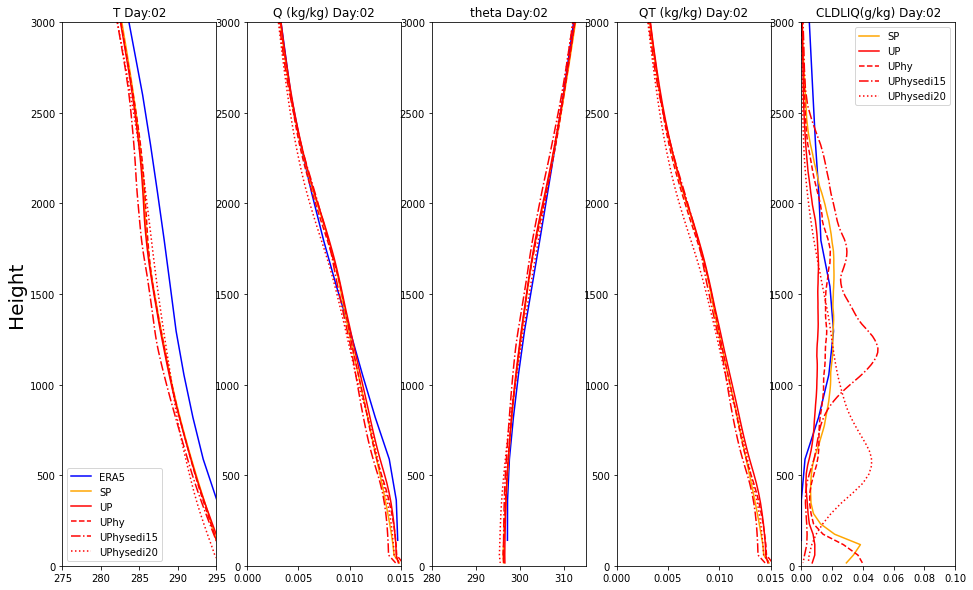

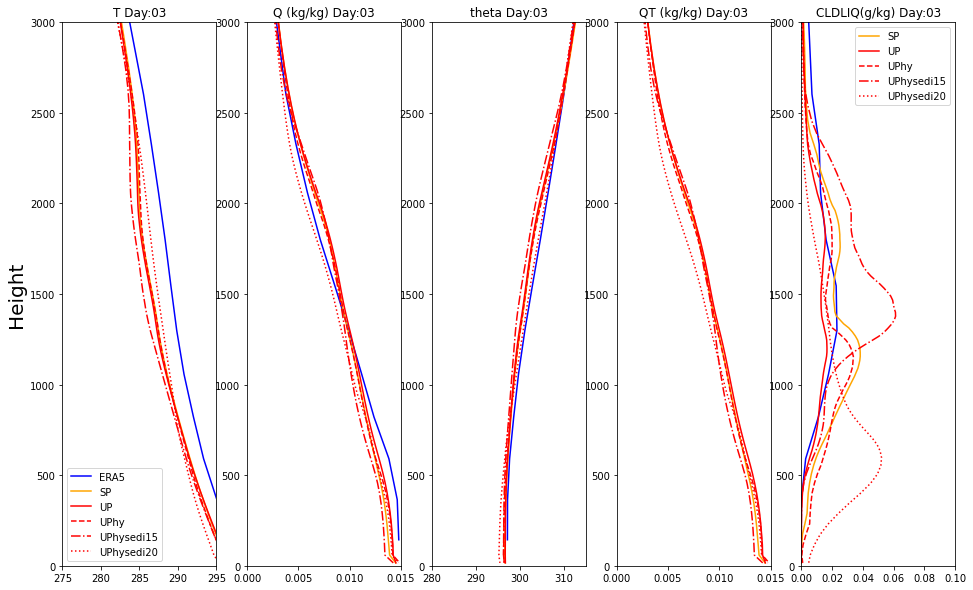

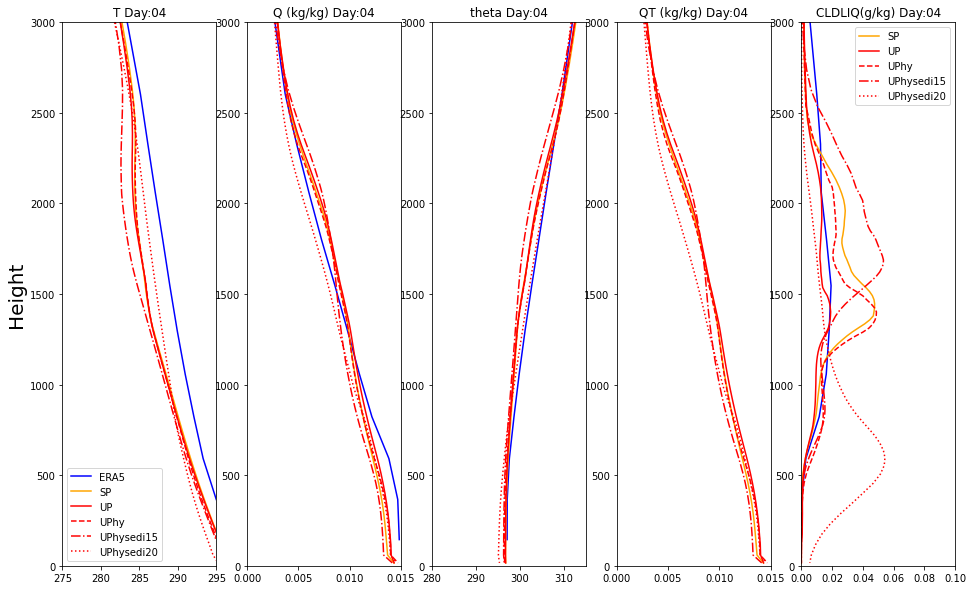

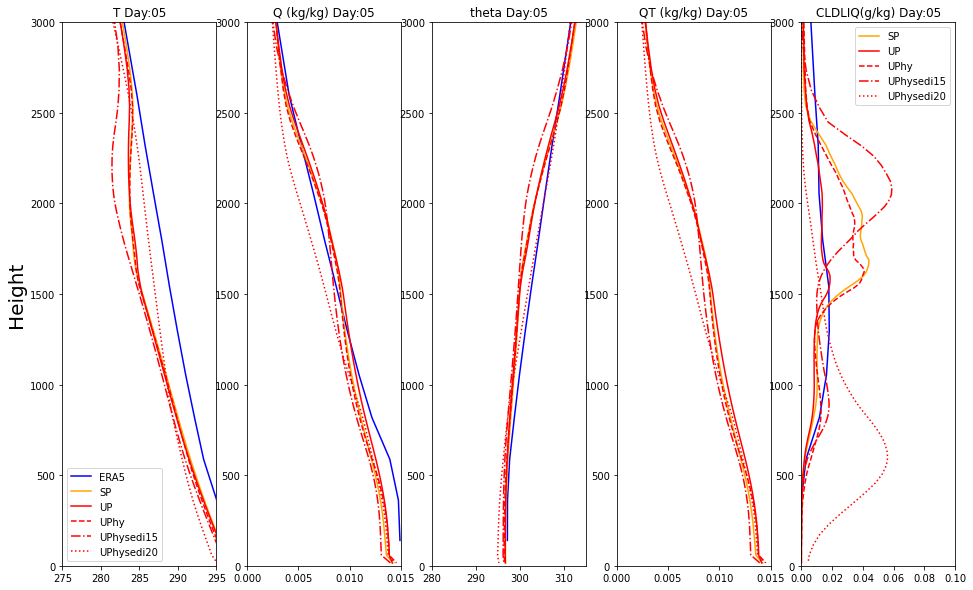

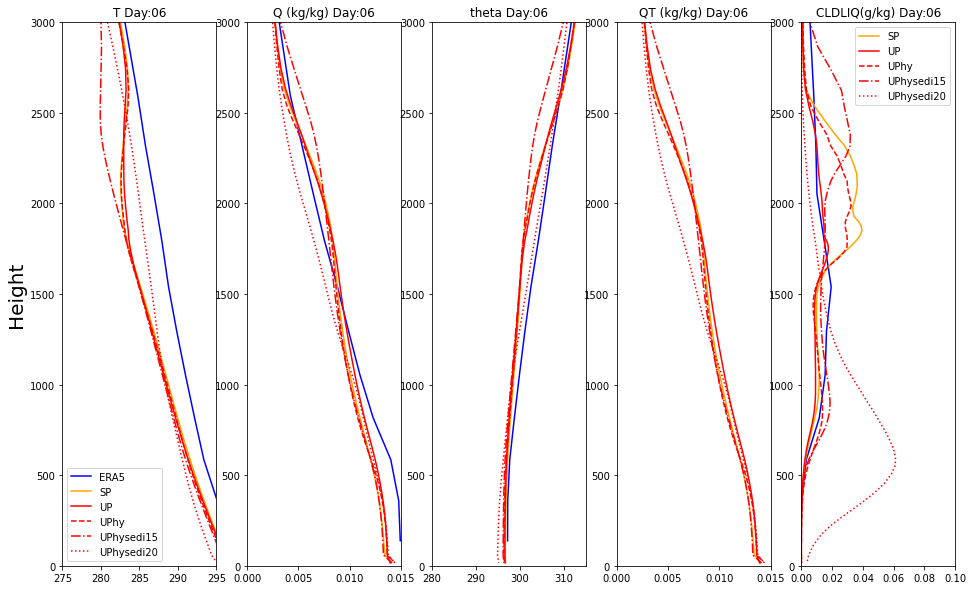

In [53]:
ERA5_pressure = [500, 550, 600, 650, 700, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
for iday in range(7):
    countday = 0
    T_crossERA5Hawaii_dm = np.zeros([16])
    q_crossERA5Hawaii_dm = np.zeros([16])
    z_crossERA5Hawaii_dm = np.zeros([16])
    theta_crossERA5Hawaii_dm = np.zeros([16])
    lw_crossERA5Hawaii_dm = np.zeros([16])
    print(iday)
    for ihour in range(24):
        T_crossERA5Hawaii_dm[:] = T_crossERA5Hawaii_dm[:] + ERA5_tHawaii[(countday+24*iday),:]
        q_crossERA5Hawaii_dm[:] = q_crossERA5Hawaii_dm[:] + ERA5_qHawaii[(countday+24*iday),:]
        z_crossERA5Hawaii_dm[:] = z_crossERA5Hawaii_dm[:] + ERA5_zHawaii[(countday+24*iday),:]
        lw_crossERA5Hawaii_dm[:] = lw_crossERA5Hawaii_dm[:] + ERA5_lwHawaii[(countday+24*iday),:]
        for izz in range(16):
            theta_crossERA5Hawaii_dm[izz] = potential_temperature(T_crossERA5Hawaii_dm[izz],ERA5_pressure[izz]*100)
            
        countday = countday+1
    print(countday)
    T_crossERA5Hawaii_dm[:] = T_crossERA5Hawaii_dm[:]/(countday)
    q_crossERA5Hawaii_dm[:] = q_crossERA5Hawaii_dm[:]/(countday)
    z_crossERA5Hawaii_dm[:] = z_crossERA5Hawaii_dm[:]/(countday)
    theta_crossERA5Hawaii_dm[:] = theta_crossERA5Hawaii_dm[:]/(countday)
    lw_crossERA5Hawaii_dm[:] = lw_crossERA5Hawaii_dm[:]/(countday)
    T_crossSPHawaii_dm = np.zeros([125])
    T_crossUPHawaii_dm = np.zeros([125])
    T_crossUPhyHawaii_dm = np.zeros([125])
    T_crossUPhysedi15Hawaii_dm = np.zeros([125])
    T_crossUPhysedi20Hawaii_dm = np.zeros([125])
    Q_crossSPHawaii_dm = np.zeros([125])
    Q_crossUPHawaii_dm = np.zeros([125])
    Q_crossUPhyHawaii_dm = np.zeros([125])
    Q_crossUPhysedi15Hawaii_dm = np.zeros([125])
    Q_crossUPhysedi20Hawaii_dm = np.zeros([125])
    CLDICE_crossSPHawaii_dm = np.zeros([125])
    CLDICE_crossUPHawaii_dm = np.zeros([125])
    CLDICE_crossUPhyHawaii_dm = np.zeros([125])
    CLDICE_crossUPhysedi15Hawaii_dm = np.zeros([125])
    CLDICE_crossUPhysedi20Hawaii_dm = np.zeros([125])
    CLDLIQ_crossSPHawaii_dm = np.zeros([125])
    CLDLIQ_crossUPHawaii_dm = np.zeros([125])
    CLDLIQ_crossUPhyHawaii_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi15Hawaii_dm = np.zeros([125])
    CLDLIQ_crossUPhysedi20Hawaii_dm = np.zeros([125])
    Z3_crossSPHawaii_dm = np.zeros([125])
    Z3_crossUPHawaii_dm = np.zeros([125])
    Z3_crossUPhyHawaii_dm = np.zeros([125])
    Z3_crossUPhysedi15Hawaii_dm = np.zeros([125])
    Z3_crossUPhysedi20Hawaii_dm = np.zeros([125])
    theta_crossSPHawaii_dm = np.zeros([125])
    theta_crossUPHawaii_dm = np.zeros([125])
    theta_crossUPhyHawaii_dm = np.zeros([125])
    theta_crossUPhysedi15Hawaii_dm = np.zeros([125])
    theta_crossUPhysedi20Hawaii_dm = np.zeros([125])
    countsec = 0
    for isec in range(144):
        T_crossSPHawaii_dm[:] = T_crossSPHawaii_dm[:] + T_crossSPHawaii[:,isec+144*iday]
        T_crossUPHawaii_dm[:] = T_crossUPHawaii_dm[:] + T_crossUPHawaii[:,isec+144*iday]
        T_crossUPhyHawaii_dm[:] = T_crossUPhyHawaii_dm[:] + T_crossUPhyHawaii[:,isec+144*iday]
        T_crossUPhysedi15Hawaii_dm[:] = T_crossUPhysedi15Hawaii_dm[:] + T_crossUPhysedi15Hawaii[:,isec+144*iday]
        T_crossUPhysedi20Hawaii_dm[:] = T_crossUPhysedi20Hawaii_dm[:] + T_crossUPhysedi20Hawaii[:,isec+144*iday]
        Q_crossSPHawaii_dm[:] = Q_crossSPHawaii_dm[:] + Q_crossSPHawaii[:,isec+144*iday]
        Q_crossUPHawaii_dm[:] = Q_crossUPHawaii_dm[:] + Q_crossUPHawaii[:,isec+144*iday]
        Q_crossUPhyHawaii_dm[:] = Q_crossUPhyHawaii_dm[:] + Q_crossUPhyHawaii[:,isec+144*iday]
        Q_crossUPhysedi15Hawaii_dm[:] = Q_crossUPhysedi15Hawaii_dm[:] + Q_crossUPhysedi15Hawaii[:,isec+144*iday]
        Q_crossUPhysedi20Hawaii_dm[:] = Q_crossUPhysedi20Hawaii_dm[:] + Q_crossUPhysedi20Hawaii[:,isec+144*iday]
        CLDLIQ_crossSPHawaii_dm[:] = CLDLIQ_crossSPHawaii_dm[:] + CLDLIQ_crossSPHawaii[:,isec+144*iday]
        CLDLIQ_crossUPHawaii_dm[:] = CLDLIQ_crossUPHawaii_dm[:] + CLDLIQ_crossUPHawaii[:,isec+144*iday]
        CLDLIQ_crossUPhyHawaii_dm[:] = CLDLIQ_crossUPhyHawaii_dm[:] + CLDLIQ_crossUPhyHawaii[:,isec+144*iday]
        CLDLIQ_crossUPhysedi15Hawaii_dm[:] = CLDLIQ_crossUPhysedi15Hawaii_dm[:] + CLDLIQ_crossUPhysedi15Hawaii[:,isec+144*iday]
        CLDLIQ_crossUPhysedi20Hawaii_dm[:] = CLDLIQ_crossUPhysedi20Hawaii_dm[:] + CLDLIQ_crossUPhysedi20Hawaii[:,isec+144*iday]
        CLDICE_crossSPHawaii_dm[:] = CLDICE_crossSPHawaii_dm[:] + CLDICE_crossSPHawaii[:,isec+144*iday]
        CLDICE_crossUPHawaii_dm[:] = CLDICE_crossUPHawaii_dm[:] + CLDICE_crossUPHawaii[:,isec+144*iday]
        CLDICE_crossUPhyHawaii_dm[:] = CLDICE_crossUPhyHawaii_dm[:] + CLDICE_crossUPhyHawaii[:,isec+144*iday]
        CLDICE_crossUPhysedi15Hawaii_dm[:] = CLDICE_crossUPhysedi15Hawaii_dm[:] + CLDICE_crossUPhysedi15Hawaii[:,isec+144*iday]
        CLDICE_crossUPhysedi20Hawaii_dm[:] = CLDICE_crossUPhysedi20Hawaii_dm[:] + CLDICE_crossUPhysedi20Hawaii[:,isec+144*iday]
        Z3_crossSPHawaii_dm[:] = Z3_crossSPHawaii_dm[:] + Z3_crossSPHawaii[:,isec+144*iday]
        Z3_crossUPHawaii_dm[:] = Z3_crossUPHawaii_dm[:] + Z3_crossUPHawaii[:,isec+144*iday]
        Z3_crossUPhyHawaii_dm[:] = Z3_crossUPhyHawaii_dm[:] + Z3_crossUPhyHawaii[:,isec+144*iday]
        Z3_crossUPhysedi15Hawaii_dm[:] = Z3_crossUPhysedi15Hawaii_dm[:] + Z3_crossUPhysedi15Hawaii[:,isec+144*iday]
        Z3_crossUPhysedi20Hawaii_dm[:] = Z3_crossUPhysedi20Hawaii_dm[:] + Z3_crossUPhysedi20Hawaii[:,isec+144*iday]
        for izz in range(125):
            #theta_crossSPHawaii_dm[izz] = theta_crossSPHawaii_dm[izz] + potential_temperature(T_crossSPHawaii[izz,isec+144*iday],P_crossSPHawaii[izz,isec+144*iday]*100)
            #theta_crossUPHawaii_dm[izz] = theta_crossUPHawaii_dm[izz] + potential_temperature(T_crossUPHawaii[izz,isec+144*iday],P_crossUPHawaii[izz,isec+144*iday]*100)
            #theta_crossUPhyHawaii_dm[izz] = theta_crossUPhyHawaii_dm[izz] + potential_temperature(T_crossUPhyHawaii[izz,isec+144*iday],P_crossUPhyHawaii[izz,isec+144*iday]*100)
            #theta_crossUPhysedi15Hawaii_dm[izz] = theta_crossUPhysedi15Hawaii_dm[izz] + potential_temperature(T_crossUPhysedi15Hawaii[izz,isec+144*iday],P_crossUPhysedi15Hawaii[izz,isec+144*iday]*100)
            #theta_crossUPhysedi20Hawaii_dm[izz] = theta_crossUPhysedi20Hawaii_dm[izz] + potential_temperature(T_crossUPhysedi20Hawaii[izz,isec+144*iday],P_crossUPhysedi20Hawaii[izz,isec+144*iday]*100)
            theta_crossSPHawaii_dm[izz] = theta_crossSPHawaii_dm[izz] + potential_temperature(T_crossSPHawaii[izz,isec+144*iday],level_SP[izz]*100)
            theta_crossUPHawaii_dm[izz] = theta_crossUPHawaii_dm[izz] + potential_temperature(T_crossUPHawaii[izz,isec+144*iday],level_UP[izz]*100)
            theta_crossUPhyHawaii_dm[izz] = theta_crossUPhyHawaii_dm[izz] + potential_temperature(T_crossUPhyHawaii[izz,isec+144*iday],level_UPhy[izz]*100)
            theta_crossUPhysedi15Hawaii_dm[izz] = theta_crossUPhysedi15Hawaii_dm[izz] + potential_temperature(T_crossUPhysedi15Hawaii[izz,isec+144*iday],level_UPhysedi15[izz]*100)
            theta_crossUPhysedi20Hawaii_dm[izz] = theta_crossUPhysedi20Hawaii_dm[izz] + potential_temperature(T_crossUPhysedi20Hawaii[izz,isec+144*iday],level_UPhysedi20[izz]*100)
        countsec = countsec+1
    T_crossSPHawaii_dm = T_crossSPHawaii_dm/(countsec)
    T_crossUPHawaii_dm = T_crossUPHawaii_dm/(countsec)
    T_crossUPhyHawaii_dm = T_crossUPhyHawaii_dm/(countsec)
    T_crossUPhysedi15Hawaii_dm = T_crossUPhysedi15Hawaii_dm/(countsec)
    T_crossUPhysedi20Hawaii_dm = T_crossUPhysedi20Hawaii_dm/(countsec)
    Q_crossSPHawaii_dm = Q_crossSPHawaii_dm/(countsec)
    Q_crossUPHawaii_dm = Q_crossUPHawaii_dm/(countsec)
    Q_crossUPhyHawaii_dm = Q_crossUPhyHawaii_dm/(countsec)
    Q_crossUPhysedi15Hawaii_dm = Q_crossUPhysedi15Hawaii_dm/(countsec)
    Q_crossUPhysedi20Hawaii_dm = Q_crossUPhysedi20Hawaii_dm/(countsec)  
    CLDICE_crossSPHawaii_dm = CLDICE_crossSPHawaii_dm/(countsec)
    CLDICE_crossUPHawaii_dm = CLDICE_crossUPHawaii_dm/(countsec)
    CLDICE_crossUPhyHawaii_dm = CLDICE_crossUPhyHawaii_dm/(countsec)
    CLDICE_crossUPhysedi15Hawaii_dm = CLDICE_crossUPhysedi15Hawaii_dm/(countsec)
    CLDICE_crossUPhysedi20Hawaii_dm = CLDICE_crossUPhysedi20Hawaii_dm/(countsec)  
    CLDLIQ_crossSPHawaii_dm = CLDLIQ_crossSPHawaii_dm/(countsec)
    CLDLIQ_crossUPHawaii_dm = CLDLIQ_crossUPHawaii_dm/(countsec)
    CLDLIQ_crossUPhyHawaii_dm = CLDLIQ_crossUPhyHawaii_dm/(countsec)
    CLDLIQ_crossUPhysedi15Hawaii_dm = CLDLIQ_crossUPhysedi15Hawaii_dm/(countsec)
    CLDLIQ_crossUPhysedi20Hawaii_dm = CLDLIQ_crossUPhysedi20Hawaii_dm/(countsec)  
    Z3_crossSPHawaii_dm = Z3_crossSPHawaii_dm/(countsec)
    Z3_crossUPHawaii_dm = Z3_crossUPHawaii_dm/(countsec)
    Z3_crossUPhyHawaii_dm = Z3_crossUPhyHawaii_dm/(countsec)
    Z3_crossUPhysedi15Hawaii_dm = Z3_crossUPhysedi15Hawaii_dm/(countsec)
    Z3_crossUPhysedi20Hawaii_dm = Z3_crossUPhysedi20Hawaii_dm/(countsec) 
    theta_crossSPHawaii_dm = theta_crossSPHawaii_dm/(countsec)
    theta_crossUPHawaii_dm = theta_crossUPHawaii_dm/(countsec)
    theta_crossUPhyHawaii_dm = theta_crossUPhyHawaii_dm/(countsec)
    theta_crossUPhysedi15Hawaii_dm = theta_crossUPhysedi15Hawaii_dm/(countsec)
    theta_crossUPhysedi20Hawaii_dm = theta_crossUPhysedi20Hawaii_dm/(countsec)
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(nrows=1, ncols=5, figsize=(16, 10))   
    cf01 = ax1.plot(T_crossERA5Hawaii_dm,z_crossERA5Hawaii_dm/9.8, color='blue', label = 'ERA5')
    cf02 = ax1.plot(T_crossSPHawaii_dm,Z3_crossSPHawaii_dm, color='orange', label = 'SP')
    cf03 = ax1.plot(T_crossUPHawaii_dm,Z3_crossUPHawaii_dm, color='red', label = 'UP')
    cf04 = ax1.plot(T_crossUPhyHawaii_dm,Z3_crossUPhyHawaii_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf05 = ax1.plot(T_crossUPhysedi15Hawaii_dm,Z3_crossUPhysedi15Hawaii_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf06 = ax1.plot(T_crossUPhysedi20Hawaii_dm,Z3_crossUPhysedi20Hawaii_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax1.legend(prop ={'size': 10})
    ax1.set(xlim=(275, 295), ylim=(0, 3000))
    title1 = 'T Day:'+'{:02d}'
    ax1.set_title(title1.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    ax1.set_ylabel('Height', fontsize=20)
    
    cf02 = ax2.plot(q_crossERA5Hawaii_dm,z_crossERA5Hawaii_dm/9.8, color='blue')
    cf12 = ax2.plot(Q_crossSPHawaii_dm,Z3_crossSPHawaii_dm, color='orange')
    cf13 = ax2.plot(Q_crossUPHawaii_dm,Z3_crossUPHawaii_dm, color='red')
    cf14 = ax2.plot(Q_crossUPhyHawaii_dm,Z3_crossUPhyHawaii_dm, color='red', linestyle='dashed')
    cf15 = ax2.plot(Q_crossUPhysedi15Hawaii_dm,Z3_crossUPhysedi15Hawaii_dm, color='red', linestyle='dashdot')
    cf16 = ax2.plot(Q_crossUPhysedi20Hawaii_dm,Z3_crossUPhysedi20Hawaii_dm, color='red', linestyle='dotted')
    ax2.set(xlim=(0, 0.015), ylim=(0, 3000))
    title2 = 'Q (kg/kg) Day:'+'{:02d}'
    ax2.set_title(title2.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax2.set_ylabel('Height', fontsize=20)
    
    cf31 = ax3.plot(theta_crossERA5Hawaii_dm,z_crossERA5Hawaii_dm/9.8,color='blue')
    cf32 = ax3.plot(theta_crossSPHawaii_dm,Z3_crossSPHawaii_dm, color='orange')
    cf33 = ax3.plot(theta_crossUPHawaii_dm,Z3_crossUPHawaii_dm, color='red')
    cf34 = ax3.plot(theta_crossUPhyHawaii_dm,Z3_crossUPhyHawaii_dm, color='red', linestyle='dashed')
    cf35 = ax3.plot(theta_crossUPhysedi15Hawaii_dm,Z3_crossUPhysedi15Hawaii_dm, color='red', linestyle='dashdot')
    cf36 = ax3.plot(theta_crossUPhysedi20Hawaii_dm,Z3_crossUPhysedi20Hawaii_dm, color='red', linestyle='dotted')
    ax3.set(xlim=(280, 315), ylim=(0, 3000))
    title3 = 'theta Day:'+'{:02d}'
    ax3.set_title(title3.format(iday))
    #ax1.set_xlabel('Day', fontsize=20)
    #ax3.set_ylabel('Height', fontsize=20)
    
    QT_crossSPHawaii_dm = Q_crossSPHawaii_dm+CLDICE_crossSPHawaii_dm+CLDLIQ_crossSPHawaii_dm
    QT_crossUPHawaii_dm = Q_crossUPHawaii_dm+CLDICE_crossUPHawaii_dm+CLDLIQ_crossUPHawaii_dm
    QT_crossUPhyHawaii_dm = Q_crossUPhyHawaii_dm+CLDICE_crossUPhyHawaii_dm+CLDLIQ_crossUPhyHawaii_dm
    QT_crossUPhysedi15Hawaii_dm = Q_crossUPhysedi15Hawaii_dm+CLDICE_crossUPhysedi15Hawaii_dm+CLDLIQ_crossUPhysedi15Hawaii_dm
    QT_crossUPhysedi20Hawaii_dm = Q_crossUPhysedi20Hawaii_dm+CLDICE_crossUPhysedi20Hawaii_dm+CLDLIQ_crossUPhysedi20Hawaii_dm
    cf42 = ax4.plot(QT_crossSPHawaii_dm,Z3_crossSPHawaii_dm, color='orange')
    cf43 = ax4.plot(QT_crossUPHawaii_dm,Z3_crossUPHawaii_dm, color='red')
    cf44 = ax4.plot(QT_crossUPhyHawaii_dm,Z3_crossUPhyHawaii_dm, color='red', linestyle='dashed')
    cf45 = ax4.plot(QT_crossUPhysedi15Hawaii_dm,Z3_crossUPhysedi15Hawaii_dm, color='red', linestyle='dashdot')
    cf46 = ax4.plot(QT_crossUPhysedi20Hawaii_dm,Z3_crossUPhysedi20Hawaii_dm, color='red', linestyle='dotted')
    ax4.set(xlim=(0, 0.015), ylim=(0, 3000))
    title1 = 'QT (kg/kg) Day:'+'{:02d}'
    ax4.set_title(title1.format(iday))
    #ax4.set_xlabel('Day', fontsize=20)
    #ax4.set_ylabel('Height', fontsize=20)    
    cf51 = ax5.plot(1000*lw_crossERA5Hawaii_dm,z_crossERA5Hawaii_dm/9.8,color='blue')
    cf52 = ax5.plot(1000*CLDLIQ_crossSPHawaii_dm,Z3_crossSPHawaii_dm, color='orange', label = 'SP')
    cf53 = ax5.plot(1000*CLDLIQ_crossUPHawaii_dm,Z3_crossUPHawaii_dm, color='red', label = 'UP')
    cf54 = ax5.plot(1000*CLDLIQ_crossUPhyHawaii_dm,Z3_crossUPhyHawaii_dm, color='red', linestyle='dashed', label = 'UPhy')
    cf55 = ax5.plot(1000*CLDLIQ_crossUPhysedi15Hawaii_dm,Z3_crossUPhysedi15Hawaii_dm, color='red', linestyle='dashdot', label = 'UPhysedi15')
    cf56 = ax5.plot(1000*CLDLIQ_crossUPhysedi20Hawaii_dm,Z3_crossUPhysedi20Hawaii_dm, color='red', linestyle='dotted', label = 'UPhysedi20')
    ax5.set(xlim=(0, 0.10), ylim=(0, 3000))
    ax5.legend(prop ={'size': 10})
    title2 = 'CLDLIQ(g/kg) Day:'+'{:02d}'
    ax5.set_title(title2.format(iday))
    titlefigure = 'Hawaii_Profiles_Day'+'{:02d}'+'.png'
    plt.savefig(titlefigure.format(iday))

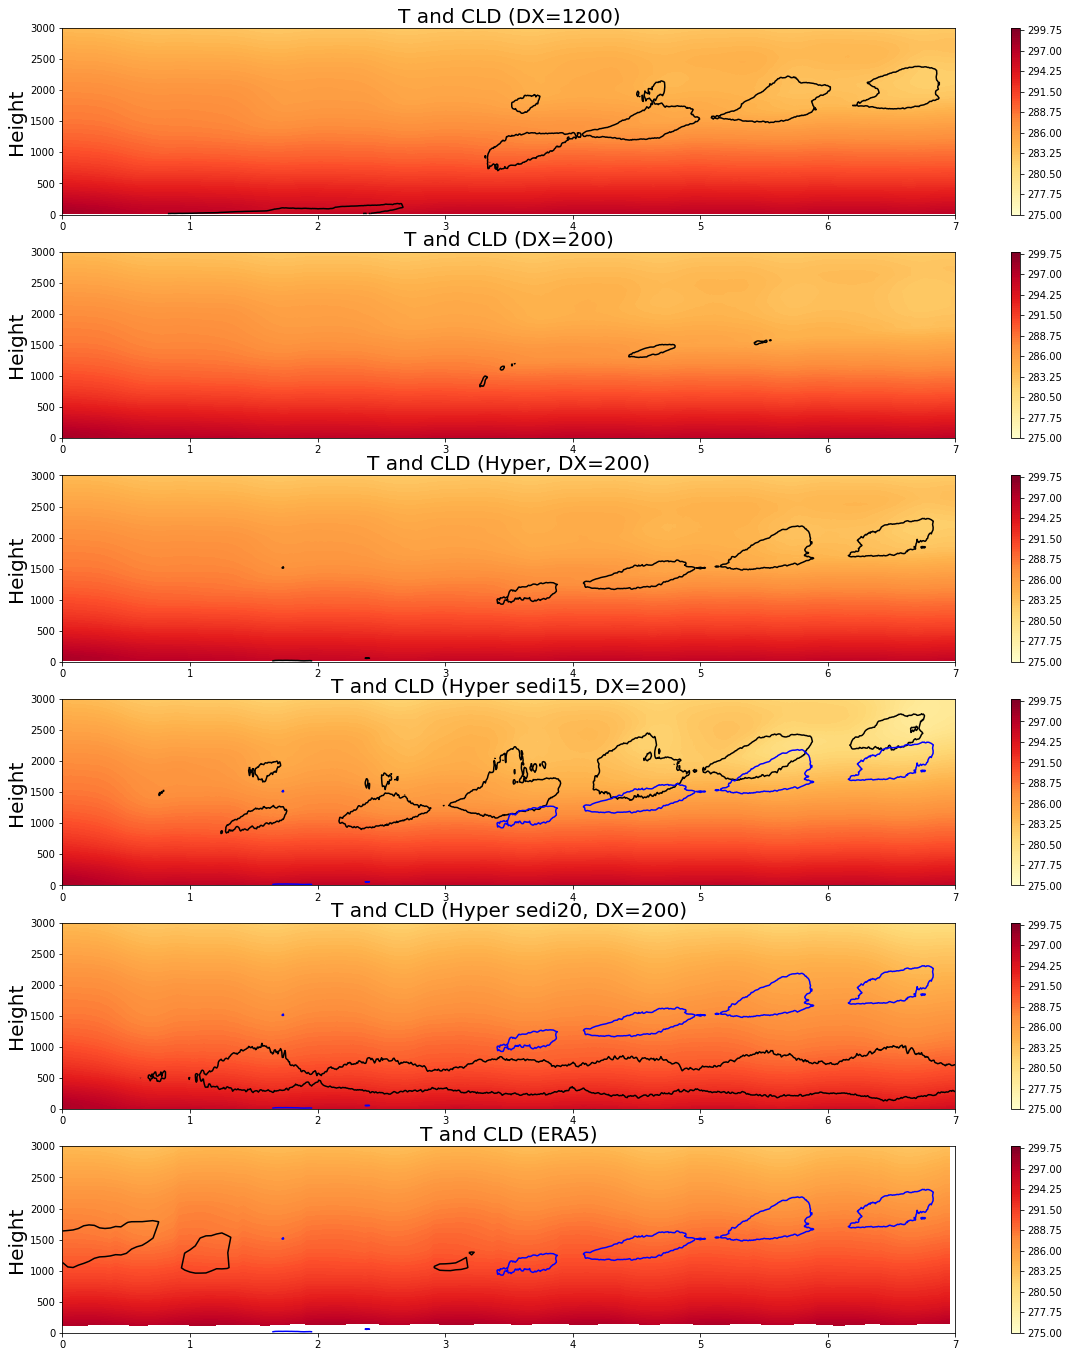

In [57]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [275]
varmax = [300]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPHawaii,T_crossSPHawaii,200, cmap="YlOrRd", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPHawaii,cld_crossSPHawaii,200,colors='k', levels=[0.1], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.set_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPHawaii,T_crossUPHawaii,200, cmap="YlOrRd", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPHawaii,cld_crossUPHawaii,200,colors='k', levels=[0.1], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyHawaii,T_crossUPhyHawaii,200, cmap="YlOrRd", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='k', levels=[0.1], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Hawaii,T_crossUPhysedi15Hawaii,200, cmap="YlOrRd", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Hawaii,cld_crossUPhysedi15Hawaii,200,colors='k', levels=[0.1], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Hawaii,T_crossUPhysedi20Hawaii,200, cmap="YlOrRd", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Hawaii,cld_crossUPhysedi20Hawaii,200,colors='k', levels=[0.1], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zHawaii/9.8,ERA5_tHawaii,200, cmap="YlOrRd", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zHawaii/9.8,ERA5_ccHawaii,200,colors='k', levels=[0.1], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("T and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.set_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Hawaii_Time_Height_Model_ERA5.png')

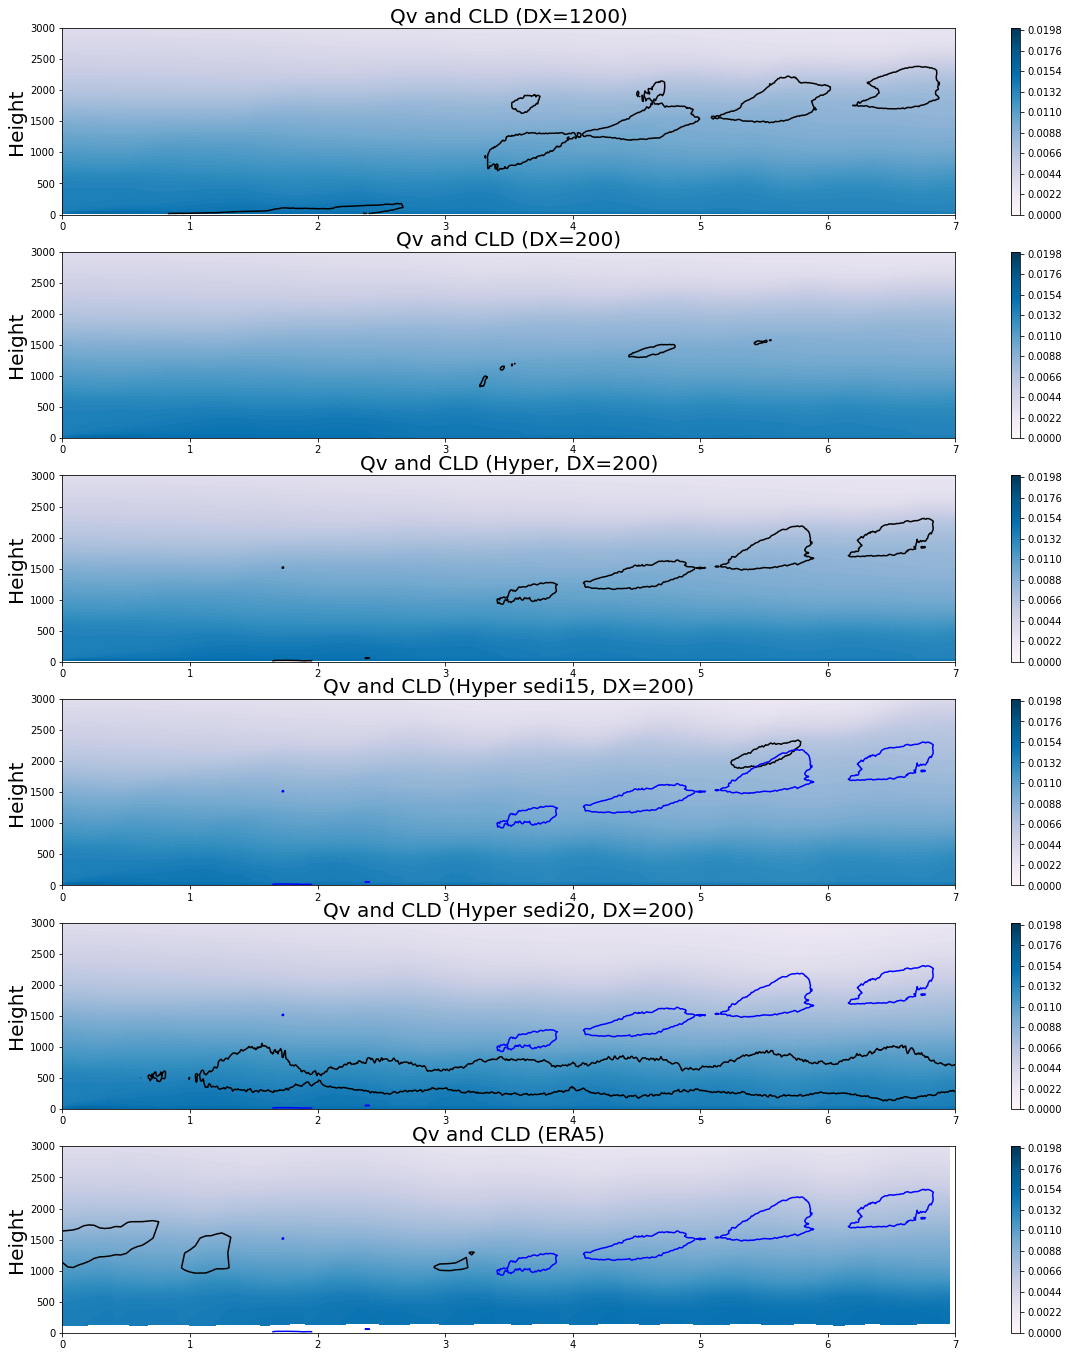

In [58]:
#  For SPCTRL and UPCTRL, both finished 5 day simulation
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(nrows=6, ncols=1, figsize=(20, 24))
varmin = [0]
varmax = [0.02]
varinter = [101]
vardmin = [-4]
vardmax = [4]
vardinter = [101]
num1 = 1009
num2 = 1009
time0 = np.linspace(0, num1, num1)
time2 = np.linspace(0, num2, num2)
time1 = np.zeros([1009,125])
for it in range(125):
    time1[:,it] = time0
time = np.transpose(time1)
levels = np.linspace(varmin[0], varmax[0], varinter[0])
levels2 = np.linspace(vardmin[0], vardmax[0], vardinter[0])

cf = ax1.contourf(time/144,Z3_crossSPHawaii,Q_crossSPHawaii,200, cmap="PuBu", levels=levels)
cf01 = ax1.contour(time/144,Z3_crossSPHawaii,cld_crossSPHawaii,200,colors='k', levels=[0.1], linestyles='-')
#cf0002 = ax1.contour(time/144,Z3p,cld_cross1,200, colors='k', levels=[0.8], linestyles=':')
cb = fig.colorbar(cf, ax=ax1)
ax1.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=1200)")
tx = ax1.set_title(titlestring, fontsize=20)
#ax1.seQ_xlabel('Day', fontsize=20)
ax1.set_ylabel('Height', fontsize=20)

cf2 = ax2.contourf(time/144,Z3_crossUPHawaii,Q_crossUPHawaii,200, cmap="PuBu", levels=levels)
cf02 = ax2.contour(time/144,Z3_crossUPHawaii,cld_crossUPHawaii,200,colors='k', levels=[0.1], linestyles='-')
cb2 = fig.colorbar(cf2, ax=ax2)
ax2.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (DX=200)")
tx = ax2.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax2.set_ylabel('Height', fontsize=20)

cf3 = ax3.contourf(time/144,Z3_crossUPhyHawaii,Q_crossUPhyHawaii,200, cmap="PuBu", levels=levels)
cf03 = ax3.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='k', levels=[0.1], linestyles='-')
cb3 = fig.colorbar(cf3, ax=ax3)
ax3.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper, DX=200)")
tx = ax3.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax3.set_ylabel('Height', fontsize=20)

cf4 = ax4.contourf(time/144,Z3_crossUPhysedi15Hawaii,Q_crossUPhysedi15Hawaii,200, cmap="PuBu", levels=levels)
cf04 = ax4.contour(time/144,Z3_crossUPhysedi15Hawaii,cld_crossUPhysedi15Hawaii,200,colors='k', levels=[0.2], linestyles='-')
cf042 = ax4.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb4 = fig.colorbar(cf4, ax=ax4)
ax4.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi15, DX=200)")
tx = ax4.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax4.set_ylabel('Height', fontsize=20)

cf5 = ax5.contourf(time/144,Z3_crossUPhysedi20Hawaii,Q_crossUPhysedi20Hawaii,200, cmap="PuBu", levels=levels)
cf05 = ax5.contour(time/144,Z3_crossUPhysedi20Hawaii,cld_crossUPhysedi20Hawaii,200,colors='k', levels=[0.1], linestyles='-')
cf052 = ax5.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb5 = fig.colorbar(cf5, ax=ax5)
ax5.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (Hyper sedi20, DX=200)")
tx = ax5.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax5.set_ylabel('Height', fontsize=20)

cf6 = ax6.contourf(ERA_Time,ERA5_zHawaii/9.8,ERA5_qHawaii,200, cmap="PuBu", levels=levels)
cf06 = ax6.contour(ERA_Time,ERA5_zHawaii/9.8,ERA5_ccHawaii,200,colors='k', levels=[0.1], linestyles='-')
cf062 = ax6.contour(time/144,Z3_crossUPhyHawaii,cld_crossUPhyHawaii,200,colors='b', levels=[0.1], linestyles='-')
cb6 = fig.colorbar(cf6, ax=ax6)
ax6.set(xlim=(0, 7), ylim=(0, 3000))
titlestring = ("Qv and CLD (ERA5)")
tx = ax6.set_title(titlestring, fontsize=20)
#ax2.seQ_xlabel('Day', fontsize=20)
ax6.set_ylabel('Height', fontsize=20)

plt.savefig('Hawaii_Time_HeighQv_Model_ERA5.png')